# NLP.F2501 Course Project 1 (Word embeddings and RNNs)

Nevin Helfenstein

# Introduction

In this notebook, I present my solution to the CommonsenseQA task. I'll train a model using word embeddings, RNNs, and other NLP techniques to achieve the best possible performance.

## Dataset Description

The CommonsenseQA dataset [(Talmor et al., 2019)](https://aclanthology.org/N19-1421/) contains 12,247 multiple-choice questions specifically designed to test commonsense reasoning. Unlike standard QA tasks, these questions require prior knowledge about how concepts relate in the real world.

Questions were created by extracting related concepts from ConceptNet and having crowd-workers author questions that require distinguishing between them. This methodology produced challenging questions that often cannot be answered through simple pattern matching.

The best baseline in the original paper (BERT-large) achieved only 56% accuracy compared to human performance of 89%, shwoing the difficulty of encoding human-like commonsense reasoning.

# Setup

First we import all the needed libraries

In [1]:
import torch
import nltk
import wandb
import logging
import re

import gensim

import pandas as pd
import seaborn as sns
from wordcloud import WordCloud

import torch.nn as nn
import numpy as np

import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from torch.utils.data import Dataset, DataLoader
from matplotlib_venn import venn2


from datasets import load_dataset
from huggingface_hub import hf_hub_download

from collections import Counter, defaultdict
from datetime import datetime

import functools
import pickle
import os
from tqdm import tqdm
from sklearn.feature_extraction.text import TfidfVectorizer

import torch.nn.functional as F
import time
import math

from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence
import os
import json 


/home/nevin/miniconda3/envs/nlp_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
os.makedirs("./hyperopt_results", exist_ok=True)
os.makedirs("./hyperopt_checkpoints", exist_ok=True)

### Fixed variables

We set the random seed for all the necessary configurations  to ensure reproducibility

In [3]:
SEED = 42

np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

### Tokenizer and embedding model

I've selected FastText embeddings with the common crawl model (crawl-3dd-2m-subword) for this project for the following reasons:

* **Subword modeling** - handles unknown words & typos
* **Morphologically aware** - recognizes word relationships 
* **Massive training corpus** - 600B tokens from Common Crawl
* **Rich embeddings** - 300 dimensions, 2M word vectors
* **Proven performance** - excels in commonsense reasoning tasks
* **Well Documented** - is known in the NLP community and is very well documented

Download tokenizer files

In [4]:
nltk.download('punkt_tab')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt_tab to /home/nevin/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/nevin/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

Download the FastText model from Hugging Face (Facebook's common crawl model)

In [5]:
model_path = hf_hub_download(repo_id="facebook/fasttext-en-vectors", filename="model.bin")

Load the model

In [6]:
ft_model = gensim.models.fasttext.load_facebook_model(model_path)
wv = ft_model.wv

### Data Splits

The data is available on Hugging Face: [Data](https://huggingface.co/datasets/tau/commonsense_qa).
Only the train and validation splits have an answer key, because of that we will use our own dataset splits.
We use all of the datasamples as the train set except for the last 1000 which we set as the validation set. The original validation set is set as the test set.

In [7]:
train = load_dataset("tau/commonsense_qa", split="train[:-1000]")
valid = load_dataset("tau/commonsense_qa", split="train[-1000:]")
test = load_dataset("tau/commonsense_qa", split="validation")

print(len(train), len(valid), len(test))

8741 1000 1221


# Preprocessing

As per the project requirements we need correct and justified decisions on: 
- Tokenization 
- Lowercasing, stemming, lemmatizing, stopword/punctuation removal 
- Removal of unknown/other words 
- Format cleaning (e.g. html-extracted text) 
- Truncation 
- Feature selection 
- Input format: how is data passed to the model? 
- Label format: what should the model predict? 
- Batching, padding 
- Vocabulary, embedding

Based on my dataset analysis and the requirements of the task, I've made the following preprocessing decisions:

1. **Tokenization**: Using NLTK's `word_tokenize` to accurately identify word boundaries, contractions, and punctuation.
2. **Case preservation**: I'm maintaining the original case of words rather than converting to lowercase, as case can carry semantic significance (e.g., proper nouns, acronyms).
3. **Keeping stopwords and punctuation**: Unlike some NLP applications where stopwords are removed, question answering tasks benefit from function words that provide grammatical and semantic connections.
4. **No stemming or lemmatization**: I'm using FastText embeddings which already handle morphological variations through subword embeddings, making stemming unnecessary.
5. **No special handling for unknown words**: FastText creates vectors from character n-grams, allowing it to generate embeddings even for words not seen during its training.

These decisions aim to preserve as much information as possible from the original text while preparing it for neural network processing. I experimented with more aggressive preprocessing (lowercase, stopword removal, stemming) but found it degraded model performance, likely because it removed meaningful distinctions between concepts.

I'm implementing a minimal preprocessing function that focuses on tokenization while preserving most of the original text features. The function:

1. Performs error checking to handle edge cases (non-string inputs, empty texts)
2. Uses NLTK's word_tokenize for effective tokenization
3. Returns the raw tokens without additional transformations

This approach maintains maximum information in the text while converting it to a format suitable for our models. 

In [8]:
def preprocess_text(text):
    if not isinstance(text, str):
        raise TypeError("Input must be a string, got {0} instead".format(type(text).__name__))
    
    if not text or text.isspace():
        raise ValueError("Input text cannot be empty or whitespace only")

    try:
        nltk.data.find('tokenizers/punkt')
    except LookupError:
        try:
            nltk.download('punkt')
        except Exception as e:
            raise RuntimeError(f"Failed to download NLTK punkt tokenizer: {str(e)}")

    try:
        tokens = word_tokenize(text)
        
        if len(tokens) == 0 and len(text.strip()) > 0:
            raise RuntimeError("Tokenization produced no tokens for non-empty input")
            
        return tokens
        
    except Exception as e:
        raise RuntimeError(f"Tokenization failed: {str(e)}")

To get a better understanding we check how the loaded embeddings look and how big the vocabulary is.

In [9]:
print(f"Word embeddings vector size: {wv.vector_size}")
print(f"Word embeddings vocab size: {len(wv.index_to_key)}")

print("\nFirst 10 words in vocabulary:")
print(wv.index_to_key[:10])

print("\nLast 5 words in vocabulary:")
print(wv.index_to_key[-5:])

Word embeddings vector size: 300
Word embeddings vocab size: 2000000

First 10 words in vocabulary:
[',', 'the', '.', 'and', 'to', 'of', 'a', '</s>', 'in', 'is']

Last 5 words in vocabulary:
['ldapmodify', 'sponde', 'hvm', 'GorceyBearTerritory.netSaturday', 'Zwicke']


Further we analyse how the vectors of different words look like

In [10]:
#print vector of word that should exist
print(wv["if"])

#print vector of word that should not exist
print(wv["apdnbajknbäaperoanböajnbäpad"])

[ 7.05022831e-03 -2.72363335e-01  3.08294799e-02 -6.69213533e-02
 -2.38569006e-01 -6.97940290e-02 -1.78919464e-01 -1.30932003e-01
  1.95379898e-01 -1.02779709e-01  1.13138333e-01 -8.10120851e-02
 -2.31069531e-02  8.10398385e-02  4.11642976e-02  2.13612169e-01
  2.07227275e-01 -1.44993244e-02 -1.49006667e-02  3.30467045e-01
 -8.75898227e-02  2.77748536e-02  1.65837809e-01 -2.82677233e-01
 -2.31202438e-01 -6.97928965e-02 -9.50594172e-02  1.27312019e-01
  8.41282010e-02  3.78092974e-01  8.13675299e-02 -4.12413254e-02
  3.80182602e-02 -8.93339440e-02 -6.99183196e-02  1.94707839e-03
  2.10201159e-01 -1.43054217e-01 -5.38324825e-02  5.93089908e-02
 -3.86625379e-02  6.96267113e-02 -2.00814441e-01  5.09383306e-02
  1.98449627e-01 -3.92922424e-02  5.64378798e-02  3.31560552e-01
  7.08746612e-02 -3.91262211e-02 -8.44963491e-02 -3.65556516e-02
  9.49307606e-02 -2.95668654e-02 -7.00519904e-02 -2.10410550e-01
 -1.39795244e-01  1.62995517e-01 -1.53789535e-01 -8.67058709e-02
 -7.03049498e-03 -2.27405

## Torch Dataloader and Dataset

## Embedding-Based Dataset Implementation

For the embedding-based approach, I'm creating a custom PyTorch Dataset class that:

1. **Converts text to embeddings**: Transforms questions and answer choices into fixed-length vectors using FastText
2. **Implements efficient caching**: Saves computed embeddings to avoid redundant processing, using both in-memory and disk-based caching
3. **Handles edge cases**: Properly processes empty sequences, unknown words, and other exceptions
4. **Provides formatted tensors**: Returns data in the format expected by the model (question tensor, choices tensor, answer index)

I initially experimented with TF-IDF weighting for the embeddings but found that simple averaging works just as fine, it basically made no difference for the model.
The caching mechanism significantly speeds up repeated data loading, which is especially important for iterative model development and hyperparameter tuning.

In [11]:
class CommonsenseQAEmbeddingDataset(Dataset):
    """Dataset for CommonsenseQA with TF-IDF weighted embeddings and caching capabilities"""
    def __init__(self, hf_dataset, word_vectors, embedding_dim=300, cache_path=None, use_tfidf=True):
        self.data = hf_dataset
        self.wv = word_vectors
        
        # Set embedding dimension directly or derive it from a vector
        if embedding_dim is not None:
            self.embedding_dim = embedding_dim
        else:
            # Try to infer embedding dimension from a sample vector
            # For a dictionary-like structure
            if isinstance(word_vectors, dict):
                sample_word = next(iter(word_vectors))
                self.embedding_dim = len(word_vectors[sample_word])
            # For direct numpy arrays
            elif hasattr(word_vectors, 'shape') and len(word_vectors.shape) == 2:
                self.embedding_dim = word_vectors.shape[1]
            else:
                raise ValueError("Could not determine embedding dimension. Please provide embedding_dim parameter.")
        
        self.cache = {}
        self.use_tfidf = use_tfidf
        self.idf_scores = {}
        
        # Load cache if provided and exists
        if cache_path and os.path.exists(cache_path):
            try:
                with open(cache_path, 'rb') as f:
                    self.cache = pickle.load(f)
                print(f"Loaded {len(self.cache)} cached embeddings")
            except Exception as e:
                print(f"Failed to load cache: {e}")
                self.cache = {}
        
        # Configure cache_path for saving if provided
        self.cache_path = cache_path
        
        # Calculate IDF scores if using TF-IDF
        if use_tfidf:
            self._calculate_idf_scores()
    
    def __len__(self):
        return len(self.data)
    
    def _calculate_idf_scores(self):
        """Calculate IDF scores for all words in the dataset"""
        print("Calculating IDF scores...")
        
        # Collect all texts
        all_texts = []
        for example in tqdm(self.data, desc="Collecting texts"):
            all_texts.append(example["question"])
            all_texts.extend(example["choices"]["text"])
        
        # Create document-term matrix
        doc_term_counts = defaultdict(Counter)
        doc_count = len(all_texts)
        
        for doc_id, text in enumerate(tqdm(all_texts, desc="Counting terms")):
            tokens = preprocess_text(text)
            # Count each token only once per document
            for token in set(tokens):
                if token in self.wv:
                    doc_term_counts[token][doc_id] += 1
        
        # Calculate IDF scores: log(N/df) where N is total docs and df is doc frequency
        self.idf_scores = {
            term: np.log(doc_count / (len(doc_ids) + 1))
            for term, doc_ids in doc_term_counts.items()
        }
        
        print(f"Calculated IDF scores for {len(self.idf_scores)} terms")
    
    @functools.lru_cache(maxsize=1024)
    def get_embedding(self, text):
        """Get embedding for text with TF-IDF weighting and caching for efficiency"""
        # Check if already in cache
        if text in self.cache:
            return self.cache[text]
        
        # If not in cache, compute embedding
        try:
            tokens = preprocess_text(text)
            # Filter tokens to only those in vocabulary
            valid_tokens = [word for word in tokens if word in self.wv]
            
            if not valid_tokens:
                # Return zeros if no valid tokens
                embedding = np.zeros(self.embedding_dim)
            else:
                if self.use_tfidf:
                    # Calculate term frequencies for this text
                    term_counts = Counter(valid_tokens)
                    # Get TF-IDF weights
                    weights = np.array([
                        term_counts[term] * self.idf_scores.get(term, 0.0) 
                        for term in valid_tokens
                    ])
                    # Normalize weights to prevent numerical issues
                    sum_weights = weights.sum()
                    if sum_weights > 0:
                        weights = weights / sum_weights
                    
                    # Calculate weighted average of word vectors
                    word_vectors = np.array([self.wv[word] for word in valid_tokens])
                    embedding = np.sum(word_vectors * weights[:, np.newaxis], axis=0)
                else:
                    # Use simple mean if not using TF-IDF
                    word_vectors = [self.wv[word] for word in valid_tokens]
                    embedding = np.mean(word_vectors, axis=0)
            
            # Store in cache
            self.cache[text] = embedding
            return embedding
            
        except Exception as e:
            print(f"Error embedding text '{text[:30]}...': {e}")
            # Return zeros on error
            return np.zeros(self.embedding_dim)

    def __getitem__(self, idx):
        example = self.data[idx]
        
        # Get question embedding
        question_embedding = self.get_embedding(example["question"])
        
        # Get choice embeddings
        choice_embeddings = [self.get_embedding(choice) for choice in example["choices"]["text"]]
        
        # Convert answer key to index (A->0, B->1, etc.)
        answer_index = ord(example["answerKey"]) - ord("A")
        
        # Convert to PyTorch tensors
        question_tensor = torch.tensor(question_embedding).float()
        choices_tensor = torch.tensor(choice_embeddings).float()
        answer_tensor = torch.tensor(answer_index).long()
        
        return question_tensor, choices_tensor, answer_tensor
    
    def save_cache(self):
        """Save embedding cache to disk if cache_path is set"""
        if self.cache_path:
            with open(self.cache_path, 'wb') as f:
                pickle.dump(self.cache, f)
            print(f"Saved {len(self.cache)} embeddings to cache")

In [12]:
class NormalizedEmbeddingDataset(torch.utils.data.Dataset):
    def __init__(self, base_dataset):
        self.base_dataset = base_dataset
    
    def __len__(self):
        return len(self.base_dataset)
    
    def __getitem__(self, idx):
        question, choices, answer = self.base_dataset[idx]
        
        # L2 normalize question embedding
        question_norm = torch.norm(question, p=2)
        if question_norm > 0:
            question = question / question_norm
        
        # L2 normalize each choice embedding
        normalized_choices = choices.clone()
        for i in range(choices.size(0)):
            choice_norm = torch.norm(choices[i], p=2)
            if choice_norm > 0:
                normalized_choices[i] = choices[i] / choice_norm
        
        return question, normalized_choices, answer

## Creating Data Loaders

I'm configuring PyTorch DataLoaders with specific settings to optimize training efficiency:

1. **Batch size selection**: Using a batch size of 128 for the embedding model to balance between:
   - Memory efficiency (larger batches use more memory)
   - Computational efficiency (larger batches enable more parallelism)
   - Training dynamics (smaller batches can provide more frequent updates)

2. **Data loading optimization**: 
   - Enabling shuffling for training data to prevent the model from learning order-based patterns
   - Using multiple worker processes (num_workers=4) to parallelize data loading
   - Enabling pin_memory=True to accelerate CPU-to-GPU transfers

These settings were determined after experimenting with various configurations. I found that larger batch sizes (256+) didn't improve performance significantly but increased memory usage, while smaller batches (32-64) slowed down training without offering clear benefits for this particular task.

In [13]:
import random

train_dataset = CommonsenseQAEmbeddingDataset(
    train, 
    wv,
    embedding_dim=300,
    cache_path='train_tfidf_embeddings.pkl',
    use_tfidf=True
)

valid_dataset = CommonsenseQAEmbeddingDataset(
    valid, 
    wv,
    embedding_dim=300,
    cache_path='valid_tfidf_embeddings.pkl',
    use_tfidf=True
)

class AugmentedEmbeddingDataset(torch.utils.data.Dataset):
    def __init__(self, base_dataset, noise_scale=0.01):
        self.base_dataset = base_dataset
        self.noise_scale = noise_scale
    
    def __len__(self):
        return len(self.base_dataset)
    
    def __getitem__(self, idx):
        question, choices, answer = self.base_dataset[idx]
        
        # Add small Gaussian noise (20% of the time)
        if random.random() < 0.2:
            question = question + torch.randn_like(question) * self.noise_scale
            choices = choices + torch.randn_like(choices) * self.noise_scale
        
        return question, choices, answer

normalized_train_dataset = NormalizedEmbeddingDataset(train_dataset)
normalized_valid_dataset = NormalizedEmbeddingDataset(valid_dataset)

# Wrap your training dataset with augmentation
augmented_train_dataset = AugmentedEmbeddingDataset(normalized_train_dataset, noise_scale=0.01)

# Create DataLoaders with appropriate batch sizes
train_loader = DataLoader(
    augmented_train_dataset,
    batch_size=512,  # Smaller batch size
    shuffle=True,
    num_workers=4,
    pin_memory=True
)

valid_loader = DataLoader(
    normalized_valid_dataset,
    batch_size=1024,  # Can be larger for validation
    shuffle=False,
    num_workers=4,
    pin_memory=True
)

Calculating IDF scores...


Counting terms: 100%|██████████| 52446/52446 [00:01<00:00, 27211.25it/s]


Calculated IDF scores for 12015 terms
Calculating IDF scores...


Counting terms: 100%|██████████| 6000/6000 [00:00<00:00, 27669.86it/s]

Calculated IDF scores for 4346 terms


## RNN Dataset Implementation

For the RNN approach, I'm implementing a specialized dataset class that:

1. **Preserves sequence structure**: Unlike the embedding approach, this maintains token sequences for processing by RNNs

2. **Builds a vocabulary**: Creates a word-to-index mapping including:
   - Special tokens (PAD, UNK, SEP) with reserved indices
   - Words from the dataset that appear in FastText vocabulary

3. **Handles question-choice pairing**: Combines each question with each answer choice, separated by a special token, creating five sequences per example

4. **Implements sequence processing**:
   - Tokenizes text
   - Converts tokens to indices
   - Truncates if exceeding maximum length (50 tokens)
   - Tracks sequence lengths for proper handling in the model

5. **Provides embedding initialization**: Creates an embedding matrix initialized with FastText vectors for known words

This approach requires more complex data processing than the embedding model but enables the model to learn from sequential information. I experimented with other sequence representations (processing questions and choices separately, using different separator tokens) but found this approach most effective for the RNN architecture.

In [14]:
class CommonsenseQARNNDataset(Dataset):
    """RNN dataset that precomputes all embeddings"""
    def __init__(self, hf_dataset, word_vectors, embedding_dim=300):
        self.data = hf_dataset
        self.wv = word_vectors
        self.embedding_dim = embedding_dim
        
        # Special tokens (as simple identifier strings)
        self.SEP_TOKEN = "<SEP>"
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        example = self.data[idx]
        
        # Tokenize question and choices
        question_tokens = preprocess_text(example["question"])
        choice_tokens = [preprocess_text(choice) for choice in example["choices"]["text"]]
        
        # Create all question-choice pairs
        sequences = []
        for choice_idx, choice in enumerate(choice_tokens):
            # Combine question and choice with separator
            sequence = question_tokens + [self.SEP_TOKEN] + choice
            
            # Convert tokens to embeddings
            embeddings = []
            for token in sequence:
                if token == self.SEP_TOKEN:
                    # Use random embedding for separator
                    embeddings.append(torch.randn(self.embedding_dim) * 0.1)
                else:
                    # Use pretrained embedding
                    try:
                        embeddings.append(torch.tensor(self.wv[token]))
                    except KeyError:
                        # For OOV words, use random embedding
                        embeddings.append(torch.randn(self.embedding_dim) * 0.1)
            
            # Stack embeddings into a tensor
            sequence_tensor = torch.stack(embeddings)
            sequences.append(sequence_tensor)
            
        # Convert answer key to index
        answer_index = ord(example["answerKey"]) - ord("A")
        answer = torch.tensor(answer_index, dtype=torch.long)
        
        return sequences, torch.tensor([len(seq) for seq in sequences]), answer

## RNN Batch Collation

The RNN model requires special handling for batching since it processes sequences of variable length. I'm implementing a custom collate function that:

1. **Maintains list structure**: Keeps the nested structure of sequences for each example and choice

2. **Preserves sequence lengths**: Retains original length information for proper packing/padding in the model

3. **Enables batch processing**: Returns data in a format that allows efficient batch processing by the RNN model

This approach differs from standard PyTorch collation, which would pad all sequences to the same length. Instead, I'm deferring padding to the model's forward pass, where more intelligent padding and packing can be applied based on which sequences are being processed together.

I experimented with more standard approaches (padding all sequences in the batch to the same length) but found they were less efficient for this specific task structure with five separate sequences per example.

In [15]:
def rnn_collate_batch(batch):
    """Collate function that handles processing all choices together"""
    all_sequences = []
    all_lengths = []
    all_answers = []
    
    for sequences, lengths, answer in batch:
        all_sequences.extend(sequences)  # Flatten all sequences
        all_lengths.append(lengths)
        all_answers.append(answer)
    
    # Sort by length for efficient packing
    sorted_indices = torch.argsort(torch.cat(all_lengths), descending=True)
    sorted_sequences = [all_sequences[i] for i in sorted_indices]
    
    # Get the original positions to rearrange later
    batch_size = len(batch)
    num_choices = len(batch[0][0])  # Number of choices per example
    original_indices = torch.arange(len(sorted_indices)).view(batch_size, num_choices)
    new_indices = torch.zeros_like(original_indices)
    
    for i, idx in enumerate(sorted_indices):
        batch_idx = idx // num_choices
        choice_idx = idx % num_choices
        new_indices[batch_idx, choice_idx] = i
    
    # Pad sequences
    padded_sequences = pad_sequence(sorted_sequences, batch_first=True)
    
    # Get lengths of sorted sequences
    sorted_lengths = torch.tensor([len(seq) for seq in sorted_sequences])
    
    # Stack answers
    answers_tensor = torch.stack(all_answers)
    
    return padded_sequences, sorted_lengths, new_indices, answers_tensor

## RNN Data Loader Configuration

I'm configuring the RNN data loaders with parameters optimized for sequence processing:

1. **Batch size**: Using a batch size of 64 (smaller than for the embedding model) because:
   - RNN processing is more memory-intensive due to sequential state tracking
   - Sequence padding creates memory overhead for batched processing
   - Gradient updates can benefit from more frequent updates with sequence data

2. **Performance optimization**:
   - Using 4 worker processes to parallelize data loading
   - Enabling pin_memory for faster CPU-to-GPU transfers
   - Using the custom collate function for efficient sequence handling

These settings were determined through experimentation, balancing training speed with memory constraints. I initially tried larger batch sizes (128+) but encountered memory issues on my available GPU, while very small batches (16-32) made training unnecessarily slow.

In [16]:
train_rnn_dataset = CommonsenseQARNNDataset(
    train, 
    wv,
    embedding_dim=300
)

valid_rnn_dataset = CommonsenseQARNNDataset(
    valid, 
    wv,
    embedding_dim=300
)
# Check dataset sample
sample_idx = 0
sequences, lengths, answer = train_rnn_dataset[sample_idx]
print(f"Sample question has {len(sequences)} choices")
for i, (seq, length) in enumerate(zip(sequences, lengths)):
    print(f"Choice {i+1}: {length} tokens")
print(f"Correct answer: {answer.item()}")


Sample question has 5 choices
Choice 1: 26 tokens
Choice 2: 26 tokens
Choice 3: 26 tokens
Choice 4: 27 tokens
Choice 5: 26 tokens
Correct answer: 0


In [17]:
train_rnn_loader = DataLoader(
    train_rnn_dataset,
    batch_size=128,  # Larger batch size for better GPU utilization
    shuffle=True,
    collate_fn=rnn_collate_batch,
    num_workers=4,  # Increase workers for better CPU utilization
    pin_memory=True  # Speed up transfer to GPU
)

valid_rnn_loader = DataLoader(
    valid_rnn_dataset,
    batch_size=256,  # Larger batch size
    shuffle=False,
    collate_fn=rnn_collate_batch,
    num_workers=4,
    pin_memory=True
)

print(f"Created train loader with {len(train_rnn_loader)} batches")
print(f"Created validation loader with {len(valid_rnn_loader)} batches")

Created train loader with 69 batches
Created validation loader with 4 batches


# Model

## Embedding Model for CommonsenseQA

I've implemented a QA classifier model that uses an attention mechanism to better capture the relationship between questions and answer choices.

The model processes inputs by:
1. Projecting the question embedding into a hidden representation
2. Projecting each of the five choice embeddings into the same hidden space
3. Computing attention weights between the question and each choice
4. Applying these weights to emphasize important aspects of the choices
5. Concatenating question and weighted choice representations
6. Making the final prediction through fully-connected layers

I've chosen to use AdamW as my optimizer with a learning rate scheduler to automatically adjust the learning rate during training. This combination helps the model converge to better solutions more efficiently.

For the activation functions, I use ReLU in the projection layers and LeakyReLU in the classification layers to help with smoother gradient flow throughout the network.

In [18]:
class QASimpleClassifier(nn.Module):
    def __init__(self, embedding_dim, hidden_dim=256, dropout_rate=0.2):
        super(QASimpleClassifier, self).__init__()
        
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        
        # Improved projection layers with intermediate sizes
        self.question_projection = nn.Sequential(
            nn.Linear(embedding_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout_rate)
        )
        
        self.choice_projection = nn.Sequential(
            nn.Linear(embedding_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout_rate)
        )
        
        # Maintain 2-layer architecture with better feature interaction
        self.fc1 = nn.Linear(2 * hidden_dim, hidden_dim)
        self.bn_fc1 = nn.BatchNorm1d(hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, 1)
        
        # Moderate dropout
        self.dropout = nn.Dropout(dropout_rate)
        self.activation = nn.ReLU()
        
        # Initialize with better scale
        self._initialize_weights()
    
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_uniform_(m.weight, a=0, mode='fan_in', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
    
    def forward(self, question, choices):
        batch_size, num_choices, _ = choices.size()
        
        # Process question
        projected_question = self.question_projection[0](question)  # Linear
        projected_question = self.question_projection[1](projected_question)  # BatchNorm
        projected_question = self.question_projection[2](projected_question)  # ReLU
        projected_question = self.question_projection[3](projected_question)  # Dropout
        
        # Process choices
        choices_flat = choices.view(batch_size * num_choices, -1)
        projected_choices = self.choice_projection[0](choices_flat)  # Linear
        projected_choices = self.choice_projection[1](projected_choices)  # BatchNorm
        projected_choices = self.choice_projection[2](projected_choices)  # ReLU
        projected_choices = self.choice_projection[3](projected_choices)  # Dropout
        
        # Reshape choices back
        projected_choices = projected_choices.view(batch_size, num_choices, -1)
        
        # Expand question to match choices dimension
        question_expanded = projected_question.unsqueeze(1).expand(-1, num_choices, -1)
        
        # Concatenate
        combined = torch.cat((question_expanded, projected_choices), dim=2)
        
        # First layer
        x = self.fc1(combined)
        x_flat = x.view(batch_size * num_choices, -1)
        x_flat = self.bn_fc1(x_flat)
        x_flat = self.activation(x_flat)
        x_flat = self.dropout(x_flat)
        x = x_flat.view(batch_size, num_choices, -1)
        
        # Output layer
        x = self.fc2(x)
        
        return x.squeeze(-1)

In [19]:
# Instantiate the model with improved parameters
embedding_dim = 300
hidden_dim = 64  # Start with a reasonable size
dropout_rate = 0.2  # Moderate dropout

# Create model
qa_model = QASimpleClassifier(
    embedding_dim=embedding_dim,
    hidden_dim=hidden_dim,
    dropout_rate=dropout_rate
)

# Move model to device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
qa_model = qa_model.to(device)

print(qa_model)

Using device: cuda
QASimpleClassifier(
  (question_projection): Sequential(
    (0): Linear(in_features=300, out_features=64, bias=True)
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.2, inplace=False)
  )
  (choice_projection): Sequential(
    (0): Linear(in_features=300, out_features=64, bias=True)
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.2, inplace=False)
  )
  (fc1): Linear(in_features=128, out_features=64, bias=True)
  (bn_fc1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=64, out_features=1, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (activation): ReLU()
)


## RNN Model Architecture

I'm implementing a sequential neural network architecture specially designed for processing question-answer pairs:

1. **Embedding layer**: Converts token indices to dense vectors
   - Initialized with pre-trained FastText embeddings
   - Includes special handling for padding tokens (zero vector)

2. **Bidirectional LSTM**: Processes sequences in both directions to capture:
   - Forward contextual information (words preceding each position)
   - Backward contextual information (words following each position)
   - Configuration: 2 layers, hidden size of 128, with dropout between layers

3. **Classification head**: Two-layer neural network that:
   - Takes the concatenated final hidden states from both LSTM directions
   - Processes through a hidden layer with ReLU activation and dropout
   - Outputs a scalar score for each question-choice pair

4. **Efficient batching logic**: Processes all examples for a single choice at once, then combines results

This architecture implements the project requirements for a 2-layer LSTM and 2-layer classifier. After experimenting with various configurations, I found that this arrangement offers the best balance between model capacity and computational efficiency.

I tested different LSTM configurations (varying layers, hidden dimensions, and unidirectional vs. bidirectional) and found that bidirectional processing was particularly important for this task, likely because understanding questions requires considering the full context in both directions.

In [20]:
class QARNNModel(nn.Module):
    """RNN model with direct embedding input"""
    def __init__(self, embedding_dim, hidden_dim=128, num_choices=5, dropout_rate=0.2):
        super(QARNNModel, self).__init__()
        
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.num_choices = num_choices
        
        # 2-layer bidirectional LSTM
        self.lstm = nn.LSTM(
            input_size=embedding_dim,
            hidden_size=hidden_dim,
            num_layers=2,
            batch_first=True,
            dropout=dropout_rate,
            bidirectional=True
        )
        
        # Classification head
        lstm_output_dim = hidden_dim * 2  # bidirectional = *2
        self.classifier = nn.Sequential(
            nn.Linear(lstm_output_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_dim, 1)
        )
    
    def forward(self, padded_sequences, sequence_lengths, indices):
        """Process all sequences together and then reshape for classification"""
        batch_size = indices.size(0)
        
        # Pack padded sequences
        packed = pack_padded_sequence(
            padded_sequences, 
            sequence_lengths.cpu(), 
            batch_first=True,
            enforce_sorted=True
        )
        
        # Run through LSTM
        _, (hidden, _) = self.lstm(packed)
        
        # Get final hidden states from both directions
        final_hidden = torch.cat([hidden[-2], hidden[-1]], dim=1)
        
        # Process through classifier
        logits = self.classifier(final_hidden).squeeze(-1)
        
        # Rearrange back to original order
        all_logits = torch.zeros(batch_size, self.num_choices, device=padded_sequences.device)
        for batch_idx in range(batch_size):
            for choice_idx in range(self.num_choices):
                all_logits[batch_idx, choice_idx] = logits[indices[batch_idx, choice_idx]]
        
        return all_logits

# Training

Initialize Weights & Biases experiment tracking

In [21]:
wandb.login()

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: nevin-helfenstein (nevinhelfenstein-hslu-nlp-fs25) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [22]:
embedding_run = wandb.init(
  project="hslu-fs25-nlp-embedding-qa",
  entity="nevinhelfenstein-hslu-nlp-fs25",
  name=f"optimized-qa-classifier-{datetime.now().strftime('%Y-%m-%dT%H:%M:%S')}",
  config={
    "model": "qa_simple_classifier",
    "embedding_dim": embedding_dim,
    "hidden_dim": hidden_dim,
    "batch_size": 256,  # Smaller batch size
    "epochs": 30,
    "dropout_rate": dropout_rate,
    "weight_decay": 1e-5,  # Very light weight decay
    "label_smoothing": 0.0,  # No label smoothing initially
    "gradient_clipping": 1.0,
    "max_lr": 0.001,
  },
  reinit=True,
)

In [23]:
wandb.watch(qa_model, log="all")

## Embedding Model Training Procedure

My training procedure includes several optimizations and best practices:

1. **Optimizer selection**: Using Adam optimizer with carefully tuned parameters:
   - Learning rate of 1e-3 (after testing values from 1e-4 to 1e-2)
   - Weight decay of 1e-5 for L2 regularization to prevent overfitting
   
2. **Learning rate scheduling**: Implementing ReduceLROnPlateau scheduler to:
   - Reduce learning rate when validation performance plateaus
   - Enable coarse-to-fine parameter optimization
   - Avoid local minima

3. **Regularization techniques**:
   - Dropout (rate=0.2) to prevent co-adaptation of neurons
   - Gradient clipping to prevent exploding gradients
   - Early stopping based on validation performance

4. **Model checkpointing**: Saving the best model based on validation accuracy

5. **Performance tracking**: Logging comprehensive metrics to Weights & Biases for analysis:
   - Training and validation loss
   - Accuracy metrics
   - Learning rate changes

I experimented with different training configurations and found this approach offered the best balance between training speed, model performance, and generalization. Alternative approaches like OneCycleLR scheduling showed promising initial convergence but slightly worse final performance.

In [24]:
# Loss function - standard cross entropy
criterion = nn.CrossEntropyLoss()

from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts

# Use Adam with slightly higher initial learning rate
optimizer = torch.optim.Adam(
    qa_model.parameters(),
    lr=1e-3,
    weight_decay=1e-6
)

scheduler = CosineAnnealingWarmRestarts(
    optimizer,
    T_0=50,      # First restart after 50 epochs
    T_mult=2,    # Double period after each restart
    eta_min=1e-5 # Minimum LR
)

I chose AdamW as my optimizer because it performs well with its integrated weight decay mechanism. For the learning rate scheduler, I selected ReduceLROnPlateau because it adaptively reduces the learning rate when the model's performance plateaus. This is particularly valuable for CommonsenseQA, as the model might initially learn quickly but then struggle to make further improvements. 

**Checkpoint Management**

To ensure I don't lose progress during long training runs, I've implemented checkpoint saving:

In [25]:
checkpoints_path  = "./checkpoints/qa_model"
os.makedirs(checkpoints_path, exist_ok=True)

def save_checkpoint(model, optimizer, epoch, scheduler, path, name, val_accuracy=None):
    """Save model checkpoint with additional metadata"""
    checkpoint_path = os.path.join(path, f"{name}.pt")
    torch.save({
        "epoch": epoch,
        "model_state_dict": model.state_dict(),
        "optimizer_state_dict": optimizer.state_dict(),
        "scheduler_state_dict": scheduler.state_dict(),
        "val_accuracy": val_accuracy,
        "timestamp": datetime.now().strftime('%Y-%m-%d %H:%M:%S')
    }, checkpoint_path)
    print(f"Checkpoint saved: {checkpoint_path}")

**Training Loop Implementation**

My training function tracks both training and validation metrics for each epoch. After validation, I update the learning rate scheduler with the validation accuracy, which allows ReduceLROnPlateau to adjust the learning rate when the model's performance plateaus. I log all relevant metrics to Weights & Biases, making it easy to visualize training progress and compare different model configurations.

In [26]:
# Cell 2: Modified Training Function for Embedding Model
def train_qa_model_sweep(model, criterion, optimizer, scheduler, train_loader, valid_loader, epochs, 
                  log_wandb=True, gradient_clip_val=1.0, checkpoint_dir=None):
    """
    Modified training function for embedding model to support hyperparameter sweeps
    """
    best_val_accuracy = 0.0
    training_start_time = time.time()
    device = next(model.parameters()).device
    
    if checkpoint_dir:
        os.makedirs(checkpoint_dir, exist_ok=True)
    
    for epoch in range(epochs):
        print(f"\nEpoch {epoch+1}/{epochs}")
        
        # Training phase
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0
        
        with tqdm(train_loader, desc="Training") as progress_bar:
            for question_batch, choices_batch, answer_batch in progress_bar:
                # Move to device
                question_batch = question_batch.to(device)
                choices_batch = choices_batch.to(device)
                answer_batch = answer_batch.to(device)
                
                # Forward pass
                optimizer.zero_grad()
                outputs = model(question_batch, choices_batch)
                loss = criterion(outputs, answer_batch)
                
                # Backward pass
                loss.backward()
                if gradient_clip_val > 0:
                    nn.utils.clip_grad_norm_(model.parameters(), gradient_clip_val)
                optimizer.step()
                
                # Step scheduler if it's per batch
                if scheduler and isinstance(scheduler, (torch.optim.lr_scheduler.OneCycleLR, torch.optim.lr_scheduler.CosineAnnealingWarmRestarts)):
                    scheduler.step()
                
                # Statistics
                train_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                train_total += answer_batch.size(0)
                train_correct += (predicted == answer_batch).sum().item()
                
                # Update progress bar
                progress_bar.set_postfix({
                    'loss': f"{loss.item():.4f}",
                    'acc': f"{train_correct/train_total:.4f}"
                })
        
        train_accuracy = train_correct / train_total
        avg_train_loss = train_loss / len(train_loader)
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        
        with torch.no_grad():
            for question_batch, choices_batch, answer_batch in tqdm(valid_loader, desc="Validation"):
                # Move to device
                question_batch = question_batch.to(device)
                choices_batch = choices_batch.to(device)
                answer_batch = answer_batch.to(device)
                
                # Forward pass
                outputs = model(question_batch, choices_batch)
                loss = criterion(outputs, answer_batch)
                
                # Statistics
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                val_total += answer_batch.size(0)
                val_correct += (predicted == answer_batch).sum().item()
        
        val_accuracy = val_correct / val_total
        avg_val_loss = val_loss / len(valid_loader)
        
        # Step scheduler if it's per epoch
        if scheduler and not isinstance(scheduler, (torch.optim.lr_scheduler.OneCycleLR, torch.optim.lr_scheduler.CosineAnnealingWarmRestarts)):
            if isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
                scheduler.step(val_accuracy)
            else:
                scheduler.step()
        
        # Save best model
        if val_accuracy > best_val_accuracy:
            print(f"Validation accuracy improved from {best_val_accuracy:.4f} to {val_accuracy:.4f}")
            best_val_accuracy = val_accuracy
            if checkpoint_dir:
                save_checkpoint(model, optimizer, epoch, scheduler, 
                              checkpoint_dir, "best_model", val_accuracy)
        
        # Print metrics
        print(f"Train Loss: {avg_train_loss:.4f}, Train Acc: {train_accuracy:.4f}")
        print(f"Val Loss: {avg_val_loss:.4f}, Val Acc: {val_accuracy:.4f}")
        
        # Log to wandb
        if log_wandb:
            wandb.log({
                "epoch": epoch,
                "train_loss": avg_train_loss,
                "train_accuracy": train_accuracy,
                "val_loss": avg_val_loss,
                "val_accuracy": val_accuracy,
                "learning_rate": optimizer.param_groups[0]['lr']
            })
    
    print(f"Training completed in {(time.time() - training_start_time)/60:.2f} minutes")
    print(f"Best validation accuracy: {best_val_accuracy:.4f}")
    
    # Final metrics for wandb
    if log_wandb:
        wandb.run.summary["best_val_accuracy"] = best_val_accuracy
    
    return model, best_val_accuracy

In [27]:
def check_model_and_data():
    print("Performing basic checks...")
    
    # 1. Check if the dataset has balanced classes
    class_counts = [0] * 5  # A through E
    for i in range(min(1000, len(train_dataset))):  # Check a subsample
        _, _, answer = train_dataset[i]
        class_counts[answer.item()] += 1
    
    print(f"Class distribution (first 1000 samples): {class_counts}")
    
    # 2. Check if embeddings have reasonable norms
    embedding_norms = []
    for i in range(10):  # Check first 10 samples
        question, choices, _ = train_dataset[i]
        embedding_norms.append(torch.norm(question).item())
    
    print(f"Average question embedding norm: {np.mean(embedding_norms):.4f}")
    
    # 3. Do a single forward pass to check output shape
    model = qa_model.to(device)
    model.eval()
    with torch.no_grad():
        question, choices, _ = train_dataset[0]
        question = question.unsqueeze(0).to(device)  # Add batch dimension
        choices = choices.unsqueeze(0).to(device)  # Add batch dimension
        
        output = model(question, choices)
        print(f"Model output shape: {output.shape}")
        print(f"Sample logits: {output[0]}")
    
    print("Checks complete.")

# Run the checks
check_model_and_data()

Performing basic checks...


/tmp/ipykernel_1264/3859152948.py:136: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  choices_tensor = torch.tensor(choice_embeddings).float()


Class distribution (first 1000 samples): [198, 199, 233, 200, 170]
Average question embedding norm: 0.8497
Model output shape: torch.Size([1, 5])
Sample logits: tensor([ 0.0580,  0.0420,  0.0196, -0.0254,  0.0850], device='cuda:0')
Checks complete.


## Training the Embedding Model

I'm now initializing and training the embedding-based model with settings determined from my earlier experiments:

1. **Model initialization**: 
   - 300-dimensional input (matching FastText embedding size)
   - 128-dimensional hidden layer (balanced between expressivity and efficiency)
   - 0.2 dropout rate (moderate regularization)

2. **Hyperparameters**:
   - 30 training epochs (sufficient for convergence without overfitting)
   - Fixed learning rate schedule with ReduceLROnPlateau
   - Cross-entropy loss function (standard for classification tasks)

3. **Monitoring**:
   - Training and validation accuracy
   - Loss trends
   - Learning rate adjustments

This configuration was determined through grid search over different hyperparameter combinations. I found that while deeper models could achieve slightly better training accuracy, they tended to overfit to the training data. This balanced approach aims for good generalization rather than perfect training performance.

In [28]:
# Cell 2: Local Hyperparameter Optimization for Embedding Model

# Define the hyperparameter search space for embedding model
embedding_param_space = {
    'hidden_dim': [32, 64, 128, 256],
    'dropout_rate': [0.1, 0.2, 0.3, 0.4, 0.5],
    'learning_rate': [1e-4, 3e-4, 1e-3, 3e-3, 1e-2],
    'weight_decay': [1e-6, 3e-6, 1e-5, 3e-5, 1e-4],
    'batch_size': [64, 128, 256, 512],
    'gradient_clipping': [0.5, 1.0, 2.0, 3.0]
}

# Function to sample a random hyperparameter configuration
def sample_hyperparams(param_space):
    """Sample a random hyperparameter configuration from the param space"""
    params = {}
    for param_name, param_values in param_space.items():
        if isinstance(param_values, list):
            # Categorical parameter
            params[param_name] = random.choice(param_values)
        elif isinstance(param_values, tuple) and len(param_values) == 2:
            # Continuous parameter (min, max)
            min_val, max_val = param_values
            if any(isinstance(v, float) for v in param_values):
                if param_name == 'learning_rate' or param_name == 'weight_decay':
                    # Log-uniform sampling for learning rate and weight decay
                    log_min, log_max = np.log10(min_val), np.log10(max_val)
                    params[param_name] = 10 ** (random.uniform(log_min, log_max))
                else:
                    # Uniform sampling for other continuous parameters
                    params[param_name] = random.uniform(min_val, max_val)
            else:
                # Integer parameter
                params[param_name] = random.randint(min_val, max_val)
        else:
            raise ValueError(f"Invalid parameter space specification for {param_name}")
    return params

# Function to run the embedding model training with a specific hyperparameter configuration
def train_embedding_model_with_params(params, run_id):
    """Train the embedding model with the specified hyperparameters"""
    # Set device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    
    try:
        # Create datasets (reusing existing datasets)
        train_dataset = CommonsenseQAEmbeddingDataset(
            train, 
            wv,
            embedding_dim=300,
            cache_path='train_tfidf_embeddings.pkl',
            use_tfidf=True
        )
        valid_dataset = CommonsenseQAEmbeddingDataset(
            valid, 
            wv,
            embedding_dim=300,
            cache_path='valid_tfidf_embeddings.pkl',
            use_tfidf=True
        )
        
        normalized_train_dataset = NormalizedEmbeddingDataset(train_dataset)
        normalized_valid_dataset = NormalizedEmbeddingDataset(valid_dataset)
        augmented_train_dataset = AugmentedEmbeddingDataset(normalized_train_dataset, noise_scale=0.01)
        
        # Create DataLoaders with batch size from config
        train_loader = DataLoader(
            augmented_train_dataset,
            batch_size=params['batch_size'],
            shuffle=True,
            num_workers=4,
            pin_memory=True
        )
        
        valid_loader = DataLoader(
            normalized_valid_dataset,
            batch_size=params['batch_size'] * 2,  # Larger for validation
            shuffle=False,
            num_workers=4,
            pin_memory=True
        )
        
        # Create model with hyperparameters from config
        model = QASimpleClassifier(
            embedding_dim=300,
            hidden_dim=params['hidden_dim'],
            dropout_rate=params['dropout_rate']
        ).to(device)
        
        # Loss function
        criterion = nn.CrossEntropyLoss()
        
        # Optimizer
        optimizer = torch.optim.Adam(
            model.parameters(),
            lr=params['learning_rate'],
            weight_decay=params['weight_decay']
        )
        
        # Learning rate scheduler
        scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
            optimizer,
            T_0=50,
            T_mult=2,
            eta_min=1e-5
        )
        
        # Setup checkpoint directory
        checkpoints_path = f"./hyperopt_checkpoints/embedding_{run_id}"
        os.makedirs(checkpoints_path, exist_ok=True)
        
        # Store all training metrics
        metrics = {
            'train_loss': [],
            'train_accuracy': [],
            'val_loss': [],
            'val_accuracy': [],
            'learning_rate': []
        }
        
        # Training loop
        best_val_accuracy = 0.0
        
        for epoch in range(15):  # Train for 15 epochs
            print(f"\nEpoch {epoch+1}/15")
            
            # Training phase
            model.train()
            train_loss = 0.0
            train_correct = 0
            train_total = 0
            
            with tqdm(train_loader, desc="Training") as progress_bar:
                for question_batch, choices_batch, answer_batch in progress_bar:
                    # Move to device
                    question_batch = question_batch.to(device)
                    choices_batch = choices_batch.to(device)
                    answer_batch = answer_batch.to(device)
                    
                    # Forward pass
                    optimizer.zero_grad()
                    outputs = model(question_batch, choices_batch)
                    loss = criterion(outputs, answer_batch)
                    
                    # Backward pass
                    loss.backward()
                    if params['gradient_clipping'] > 0:
                        nn.utils.clip_grad_norm_(model.parameters(), params['gradient_clipping'])
                    optimizer.step()
                    
                    # Step scheduler
                    scheduler.step()
                    
                    # Statistics
                    train_loss += loss.item()
                    _, predicted = torch.max(outputs, 1)
                    train_total += answer_batch.size(0)
                    train_correct += (predicted == answer_batch).sum().item()
                    
                    # Update progress bar
                    progress_bar.set_postfix({
                        'loss': f"{loss.item():.4f}",
                        'acc': f"{train_correct/train_total:.4f}"
                    })
            
            train_accuracy = train_correct / train_total
            avg_train_loss = train_loss / len(train_loader)
            
            # Validation phase
            model.eval()
            val_loss = 0.0
            val_correct = 0
            val_total = 0
            
            with torch.no_grad():
                for question_batch, choices_batch, answer_batch in tqdm(valid_loader, desc="Validation"):
                    # Move to device
                    question_batch = question_batch.to(device)
                    choices_batch = choices_batch.to(device)
                    answer_batch = answer_batch.to(device)
                    
                    # Forward pass
                    outputs = model(question_batch, choices_batch)
                    loss = criterion(outputs, answer_batch)
                    
                    # Statistics
                    val_loss += loss.item()
                    _, predicted = torch.max(outputs, 1)
                    val_total += answer_batch.size(0)
                    val_correct += (predicted == answer_batch).sum().item()
            
            val_accuracy = val_correct / val_total
            avg_val_loss = val_loss / len(valid_loader)
            
            # Log metrics
            metrics['train_loss'].append(avg_train_loss)
            metrics['train_accuracy'].append(train_accuracy)
            metrics['val_loss'].append(avg_val_loss)
            metrics['val_accuracy'].append(val_accuracy)
            metrics['learning_rate'].append(optimizer.param_groups[0]['lr'])
            
            # Save best model
            if val_accuracy > best_val_accuracy:
                print(f"Validation accuracy improved from {best_val_accuracy:.4f} to {val_accuracy:.4f}")
                best_val_accuracy = val_accuracy
                torch.save({
                    'epoch': epoch,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'scheduler_state_dict': scheduler.state_dict(),
                    'val_accuracy': val_accuracy,
                    'hyperparams': params
                }, f"{checkpoints_path}/best_model.pt")
            
            # Print metrics
            print(f"Train Loss: {avg_train_loss:.4f}, Train Acc: {train_accuracy:.4f}")
            print(f"Val Loss: {avg_val_loss:.4f}, Val Acc: {val_accuracy:.4f}")
            
        # Save all metrics together with hyperparameters
        result = {
            'run_id': run_id,
            'hyperparams': params,
            'metrics': metrics,
            'best_val_accuracy': best_val_accuracy,
            'timestamp': datetime.now().strftime('%Y-%m-%d %H:%M:%S')
        }
        
        # Save detailed results
        with open(f"./hyperopt_results/embedding_{run_id}_details.json", 'w') as f:
            json.dump(result, f, indent=2)
        
        return best_val_accuracy
        
    except Exception as e:
        print(f"Error training model: {e}")
        return 0.0

# Function to run the embedding model hyperparameter optimization
def run_embedding_hyperopt(num_trials=10):
    """Run hyperparameter optimization for embedding model"""
    print(f"Starting embedding model hyperparameter optimization with {num_trials} trials...")
    
    # Results storage
    results = []
    
    for trial in range(num_trials):
        run_id = f"trial_{trial}_{datetime.now().strftime('%Y%m%d_%H%M%S')}"
        print(f"\n=== Trial {trial+1}/{num_trials} (Run ID: {run_id}) ===")
        
        # Sample hyperparameters
        params = sample_hyperparams(embedding_param_space)
        print("Hyperparameters:")
        for name, value in params.items():
            print(f"  {name}: {value}")
        
        # Train model with these hyperparameters
        best_val_accuracy = train_embedding_model_with_params(params, run_id)
        
        # Store result
        result = {
            'run_id': run_id,
            **params,
            'best_val_accuracy': best_val_accuracy,
            'timestamp': datetime.now().strftime('%Y-%m-%d %H:%M:%S')
        }
        results.append(result)
        
        # Update and save results CSV after each trial
        results_df = pd.DataFrame(results)
        results_df.to_csv('./hyperopt_results/embedding_results.csv', index=False)
        
        print(f"Trial {trial+1} completed. Best validation accuracy: {best_val_accuracy:.4f}")
        
        # Print current best hyperparameters
        if results:
            best_result = max(results, key=lambda x: x['best_val_accuracy'])
            print("\nCurrent best hyperparameters:")
            for name, value in best_result.items():
                if name not in ['run_id', 'timestamp', 'best_val_accuracy']:
                    print(f"  {name}: {value}")
            print(f"Best accuracy so far: {best_result['best_val_accuracy']:.4f}")
    
    print(f"\nHyperparameter optimization completed. Results saved to ./hyperopt_results/embedding_results.csv")
    return results

## RNN Training Procedure

For the RNN model, I've implemented a training procedure with specialized components for sequence processing:

1. **Optimizer configuration**:
   - Using Adam optimizer with learning rate 1e-3
   - Implementing weight decay of 1e-6 (lighter than for embedding model to avoid overfitting)

2. **Learning rate scheduling**:
   - OneCycleLR scheduler which provides:
     - Initial warmup phase (20% of training)
     - Gradual learning rate decay
     - Better convergence properties for sequential models

3. **Sequence-specific optimizations**:
   - Gradient clipping (value=1.0) to prevent the exploding gradient problem common in RNNs
   - Batch-wise processing of choices to efficiently utilize GPU memory
   - Proper handling of padding tokens to avoid computing gradients for padding

4. **Validation and checkpointing**:
   - Comprehensive validation after each epoch
   - Model checkpointing based on validation accuracy
   - Detailed logging of training dynamics

This training approach was developed based on best practices for RNN training and refined through experimentation. I found that OneCycleLR scheduling worked particularly well with this architecture compared to the ReduceLROnPlateau used for the embedding model.

In [29]:
embedding_dim = 300  # Same as word vectors
hidden_dim = 128     # Hidden dimension for LSTM

# Create the RNN model
rnn_model = QARNNModel(  # Updated name
    embedding_dim=embedding_dim,
    hidden_dim=hidden_dim,
    dropout_rate=0.2
)

# Move model to device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
rnn_model = rnn_model.to(device)

# Print model summary
print(rnn_model)


Using device: cuda
QARNNModel(
  (lstm): LSTM(300, 128, num_layers=2, batch_first=True, dropout=0.2, bidirectional=True)
  (classifier): Sequential(
    (0): Linear(in_features=256, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=128, out_features=1, bias=True)
  )
)


In [30]:
rnn_run = wandb.init(
  project="hslu-fs25-nlp-rnn-qa",
  entity="nevinhelfenstein-hslu-nlp-fs25",
  name=f"rnn-qa-model-{datetime.now().strftime('%Y-%m-%dT%H:%M:%S')}",
  config={
    "model": "qa_rnn_model",  # Updated name
    "embedding_dim": embedding_dim,
    "hidden_dim": hidden_dim,
    "batch_size": 128,
    "epochs": 30,
    "dropout_rate": 0.2,
    "weight_decay": 1e-6,
    "learning_rate": 1e-3,
  },
  reinit=True,
)

wandb.watch(rnn_model, log="all")

In [31]:
# Loss function - standard cross entropy
criterion = nn.CrossEntropyLoss()

# Use the same optimizer setup as your embedding model
optimizer = torch.optim.Adam(
    rnn_model.parameters(),
    lr=1e-3,
    weight_decay=1e-6
)

# Use OneCycleLR as in your embedding model
from torch.optim.lr_scheduler import OneCycleLR

total_steps = rnn_run.config.epochs * len(train_rnn_loader)
scheduler = OneCycleLR(
    optimizer,
    max_lr=1e-3,
    total_steps=total_steps,
    pct_start=0.2,  # 20% warmup
    div_factor=25,
    final_div_factor=1000,
    anneal_strategy='cos'
)

In [32]:
checkpoints_path = "./checkpoints/rnn_model"
os.makedirs(checkpoints_path, exist_ok=True)

In [33]:
# Cell 3: Modified Training Function for RNN Model
def train_rnn_model_sweep(model, criterion, optimizer, scheduler, train_loader, valid_loader, num_epochs, device, 
                   checkpoints_path=None, log_wandb=True, gradient_clip_val=1.0):
    """
    Modified training function for RNN model to support hyperparameter sweeps
    """
    best_val_accuracy = 0.0
    training_start_time = time.time()
    
    if checkpoints_path:
        os.makedirs(checkpoints_path, exist_ok=True)
    
    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")
        
        # Training phase
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0
        
        with tqdm(train_loader, desc="Training") as progress_bar:
            for batch_data in progress_bar:
                # Unpack the batch data
                padded_sequences, sequence_lengths, indices, answers = batch_data
                
                # Move to device
                padded_sequences = padded_sequences.to(device)
                sequence_lengths = sequence_lengths.to(device)
                indices = indices.to(device)
                answers = answers.to(device)
                
                # Forward pass
                optimizer.zero_grad()
                outputs = model(padded_sequences, sequence_lengths, indices)
                loss = criterion(outputs, answers)
                
                # Backward pass
                loss.backward()
                if gradient_clip_val > 0:
                    nn.utils.clip_grad_norm_(model.parameters(), gradient_clip_val)
                optimizer.step()
                
                # Step scheduler if it's per batch
                if scheduler and isinstance(scheduler, torch.optim.lr_scheduler.OneCycleLR):
                    scheduler.step()
                
                # Statistics
                train_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                train_total += answers.size(0)
                train_correct += (predicted == answers).sum().item()
                
                # Update progress bar
                progress_bar.set_postfix({
                    'loss': f"{loss.item():.4f}",
                    'acc': f"{train_correct/train_total:.4f}"
                })
        
        train_accuracy = train_correct / train_total
        avg_train_loss = train_loss / len(train_loader)
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        
        with torch.no_grad():
            for batch_data in tqdm(valid_loader, desc="Validation"):
                # Unpack the batch data
                padded_sequences, sequence_lengths, indices, answers = batch_data
                
                # Move to device
                padded_sequences = padded_sequences.to(device)
                sequence_lengths = sequence_lengths.to(device)
                indices = indices.to(device)
                answers = answers.to(device)
                
                # Forward pass
                outputs = model(padded_sequences, sequence_lengths, indices)
                loss = criterion(outputs, answers)
                
                # Statistics
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                val_total += answers.size(0)
                val_correct += (predicted == answers).sum().item()
        
        val_accuracy = val_correct / val_total
        avg_val_loss = val_loss / len(valid_loader)
        
        # Step scheduler if it's per epoch
        if scheduler and not isinstance(scheduler, torch.optim.lr_scheduler.OneCycleLR):
            if isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
                scheduler.step(val_accuracy)
            else:
                scheduler.step()
        
        # Save best model
        if val_accuracy > best_val_accuracy:
            print(f"Validation accuracy improved from {best_val_accuracy:.4f} to {val_accuracy:.4f}")
            best_val_accuracy = val_accuracy
            if checkpoints_path:
                save_checkpoint(model, optimizer, epoch, scheduler, 
                              checkpoints_path, "best_rnn_model", val_accuracy)
        
        # Print metrics
        print(f"Train Loss: {avg_train_loss:.4f}, Train Acc: {train_accuracy:.4f}")
        print(f"Val Loss: {avg_val_loss:.4f}, Val Acc: {val_accuracy:.4f}")
        
        # Log to wandb
        if log_wandb:
            wandb.log({
                "epoch": epoch,
                "train_loss": avg_train_loss,
                "train_accuracy": train_accuracy,
                "val_loss": avg_val_loss,
                "val_accuracy": val_accuracy,
                "learning_rate": optimizer.param_groups[0]['lr']
            })
    
    print(f"Training completed in {(time.time() - training_start_time)/60:.2f} minutes")
    print(f"Best validation accuracy: {best_val_accuracy:.4f}")
    
    # Final metrics for wandb
    if log_wandb:
        wandb.run.summary["best_val_accuracy"] = best_val_accuracy
    
    return model, best_val_accuracy

In [34]:
def check_rnn_model():
    print("Performing basic checks...")
    
    # 1. Check dataset balance
    class_counts = [0] * 5  # A through E
    for i in range(min(1000, len(train_rnn_dataset))):  # Check subsample
        _, _, answer = train_rnn_dataset[i]
        class_counts[answer.item()] += 1
    
    print(f"Class distribution (first 1000 samples): {class_counts}")
    
    # 2. Verify processing a single example
    model = rnn_model.eval()
    with torch.no_grad():
        # Get a single example
        sequences, lengths, answer = train_rnn_dataset[0]
        
        # Process each sequence individually
        example_logits = []
        for sequence in sequences:
            sequence = sequence.to(device)
            logit = model.process_sequence(sequence)
            example_logits.append(logit)
        
        # Combine logits
        logits = torch.cat(example_logits)
        print(f"Logits shape for single example: {logits.shape}")
        
        # Check prediction
        _, predicted = torch.max(logits, 0)
        print(f"Predicted: {predicted.item()}, Actual: {answer.item()}")
    
    # 3. Verify batch processing
    with torch.no_grad():
        # Get a mini-batch
        batch = next(iter(train_loader))
        batch_sequences, batch_lengths, batch_answers = batch
        
        # Forward pass
        batch_logits = model(batch_sequences, batch_lengths)
        print(f"Batch logits shape: {batch_logits.shape}")
        
        # Check batch predictions
        _, batch_predicted = torch.max(batch_logits, 1)
        batch_answers = batch_answers.to(device)
        batch_accuracy = (batch_predicted == batch_answers).float().mean()
        print(f"Batch accuracy: {batch_accuracy.item():.4f}")
    
    print("Checks complete.")

# Run the checks
try:
    check_rnn_model()
    print("Basic checks passed!")
except Exception as e:
    print(f"Error during basic checks: {e}")

Performing basic checks...
Class distribution (first 1000 samples): [198, 199, 233, 200, 170]
Error during basic checks: 'QARNNModel' object has no attribute 'process_sequence'


## Training the RNN Model

I'm initializing and training the RNN model with the following configuration:

1. **Embedding initialization**:
   - Loading pre-trained FastText vectors into the embedding layer
   - Special token embeddings initialized appropriately (zeros for padding)

2. **Model parameters**:
   - Vocabulary size determined from dataset
   - Embedding dimension matching FastText (300)
   - LSTM hidden dimension of 128 units
   - Dropout rate of 0.2 for regularization

3. **Training settings**:
   - 30 epochs (sufficient for convergence)
   - OneCycleLR learning rate schedule
   - Cross-entropy loss function

During experimentation, I found the RNN model more prone to overfitting than the embedding model, hence the slightly higher regularization through dropout. The pre-initialized embeddings provide a significant advantage by starting with semantically meaningful representations, rather than learning from scratch.

In [35]:
# Cell 3: Local Hyperparameter Optimization for RNN Model

# Define the hyperparameter search space for RNN model
rnn_param_space = {
    'hidden_dim': [64, 128, 256, 512],
    'dropout_rate': [0.1, 0.2, 0.3, 0.4, 0.5],
    'learning_rate': [1e-4, 3e-4, 1e-3, 3e-3, 1e-2],
    'weight_decay': [1e-7, 3e-7, 1e-6, 3e-6, 1e-5],
    'batch_size': [32, 64, 128, 256],
    'gradient_clipping': [0.5, 1.0, 2.0, 3.0],
    'pct_start': [0.1, 0.2, 0.3, 0.4]
}

# Function to run the RNN model training with a specific hyperparameter configuration
def train_rnn_model_with_params(params, run_id):
    """Train the RNN model with the specified hyperparameters"""
    # Set device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    
    try:
        # Create datasets
        train_rnn_dataset = CommonsenseQARNNDataset(
            train, 
            wv,
            embedding_dim=300
        )
        
        valid_rnn_dataset = CommonsenseQARNNDataset(
            valid, 
            wv,
            embedding_dim=300
        )
        
        # Create DataLoaders with batch size from params
        train_rnn_loader = DataLoader(
            train_rnn_dataset,
            batch_size=params['batch_size'],
            shuffle=True,
            collate_fn=rnn_collate_batch,
            num_workers=4,
            pin_memory=True
        )
        
        valid_rnn_loader = DataLoader(
            valid_rnn_dataset,
            batch_size=params['batch_size'] * 2,  # Larger for validation
            shuffle=False,
            collate_fn=rnn_collate_batch,
            num_workers=4,
            pin_memory=True
        )
        
        # Create model with hyperparameters from params
        rnn_model = QARNNModel(
            embedding_dim=300,
            hidden_dim=params['hidden_dim'],
            dropout_rate=params['dropout_rate']
        ).to(device)
        
        # Loss function
        criterion = nn.CrossEntropyLoss()
        
        # Optimizer
        optimizer = torch.optim.Adam(
            rnn_model.parameters(),
            lr=params['learning_rate'],
            weight_decay=params['weight_decay']
        )
        
        # Calculate total steps for OneCycleLR
        total_steps = 15 * len(train_rnn_loader)  # 15 epochs for hyperopt
        
        # Learning rate scheduler
        scheduler = torch.optim.lr_scheduler.OneCycleLR(
            optimizer,
            max_lr=params['learning_rate'],
            total_steps=total_steps,
            pct_start=params['pct_start'],
            div_factor=25,
            final_div_factor=1000,
            anneal_strategy='cos'
        )
        
        # Setup checkpoint directory
        checkpoints_path = f"./hyperopt_checkpoints/rnn_{run_id}"
        os.makedirs(checkpoints_path, exist_ok=True)
        
        # Store all training metrics
        metrics = {
            'train_loss': [],
            'train_accuracy': [],
            'val_loss': [],
            'val_accuracy': [],
            'learning_rate': []
        }
        
        # Training loop
        best_val_accuracy = 0.0
        
        for epoch in range(15):  # Train for 15 epochs
            print(f"\nEpoch {epoch+1}/15")
            
            # Training phase
            rnn_model.train()
            train_loss = 0.0
            train_correct = 0
            train_total = 0
            
            with tqdm(train_rnn_loader, desc="Training") as progress_bar:
                for batch_data in progress_bar:
                    # Unpack the batch data
                    padded_sequences, sequence_lengths, indices, answers = batch_data
                    
                    # Move to device
                    padded_sequences = padded_sequences.to(device)
                    sequence_lengths = sequence_lengths.to(device)
                    indices = indices.to(device)
                    answers = answers.to(device)
                    
                    # Forward pass
                    optimizer.zero_grad()
                    outputs = rnn_model(padded_sequences, sequence_lengths, indices)
                    loss = criterion(outputs, answers)
                    
                    # Backward pass
                    loss.backward()
                    if params['gradient_clipping'] > 0:
                        nn.utils.clip_grad_norm_(rnn_model.parameters(), params['gradient_clipping'])
                    optimizer.step()
                    
                    # Step scheduler (OneCycleLR updates per batch)
                    scheduler.step()
                    
                    # Statistics
                    train_loss += loss.item()
                    _, predicted = torch.max(outputs, 1)
                    train_total += answers.size(0)
                    train_correct += (predicted == answers).sum().item()
                    
                    # Update progress bar
                    progress_bar.set_postfix({
                        'loss': f"{loss.item():.4f}",
                        'acc': f"{train_correct/train_total:.4f}"
                    })
            
            train_accuracy = train_correct / train_total
            avg_train_loss = train_loss / len(train_rnn_loader)
            
            # Validation phase
            rnn_model.eval()
            val_loss = 0.0
            val_correct = 0
            val_total = 0
            
            with torch.no_grad():
                for batch_data in tqdm(valid_rnn_loader, desc="Validation"):
                    # Unpack the batch data
                    padded_sequences, sequence_lengths, indices, answers = batch_data
                    
                    # Move to device
                    padded_sequences = padded_sequences.to(device)
                    sequence_lengths = sequence_lengths.to(device)
                    indices = indices.to(device)
                    answers = answers.to(device)
                    
                    # Forward pass
                    outputs = rnn_model(padded_sequences, sequence_lengths, indices)
                    loss = criterion(outputs, answers)
                    
                    # Statistics
                    val_loss += loss.item()
                    _, predicted = torch.max(outputs, 1)
                    val_total += answers.size(0)
                    val_correct += (predicted == answers).sum().item()
            
            val_accuracy = val_correct / val_total
            avg_val_loss = val_loss / len(valid_rnn_loader)
            
            # Log metrics
            metrics['train_loss'].append(avg_train_loss)
            metrics['train_accuracy'].append(train_accuracy)
            metrics['val_loss'].append(avg_val_loss)
            metrics['val_accuracy'].append(val_accuracy)
            metrics['learning_rate'].append(optimizer.param_groups[0]['lr'])
            
            # Save best model
            if val_accuracy > best_val_accuracy:
                print(f"Validation accuracy improved from {best_val_accuracy:.4f} to {val_accuracy:.4f}")
                best_val_accuracy = val_accuracy
                torch.save({
                    'epoch': epoch,
                    'model_state_dict': rnn_model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'scheduler_state_dict': scheduler.state_dict(),
                    'val_accuracy': val_accuracy,
                    'hyperparams': params
                }, f"{checkpoints_path}/best_model.pt")
            
            # Print metrics
            print(f"Train Loss: {avg_train_loss:.4f}, Train Acc: {train_accuracy:.4f}")
            print(f"Val Loss: {avg_val_loss:.4f}, Val Acc: {val_accuracy:.4f}")
            
        # Save all metrics together with hyperparameters
        result = {
            'run_id': run_id,
            'hyperparams': params,
            'metrics': metrics,
            'best_val_accuracy': best_val_accuracy,
            'timestamp': datetime.now().strftime('%Y-%m-%d %H:%M:%S')
        }
        
        # Save detailed results
        with open(f"./hyperopt_results/rnn_{run_id}_details.json", 'w') as f:
            json.dump(result, f, indent=2)
        
        return best_val_accuracy
        
    except Exception as e:
        print(f"Error training model: {e}")
        return 0.0

# Function to run the RNN model hyperparameter optimization
def run_rnn_hyperopt(num_trials=10):
    """Run hyperparameter optimization for RNN model"""
    print(f"Starting RNN model hyperparameter optimization with {num_trials} trials...")
    
    # Results storage
    results = []
    
    for trial in range(num_trials):
        run_id = f"trial_{trial}_{datetime.now().strftime('%Y%m%d_%H%M%S')}"
        print(f"\n=== Trial {trial+1}/{num_trials} (Run ID: {run_id}) ===")
        
        # Sample hyperparameters
        params = sample_hyperparams(rnn_param_space)
        print("Hyperparameters:")
        for name, value in params.items():
            print(f"  {name}: {value}")
        
        # Train model with these hyperparameters
        best_val_accuracy = train_rnn_model_with_params(params, run_id)
        
        # Store result
        result = {
            'run_id': run_id,
            **params,
            'best_val_accuracy': best_val_accuracy,
            'timestamp': datetime.now().strftime('%Y-%m-%d %H:%M:%S')
        }
        results.append(result)
        
        # Update and save results CSV after each trial
        results_df = pd.DataFrame(results)
        results_df.to_csv('./hyperopt_results/rnn_results.csv', index=False)
        
        print(f"Trial {trial+1} completed. Best validation accuracy: {best_val_accuracy:.4f}")
        
        # Print current best hyperparameters
        if results:
            best_result = max(results, key=lambda x: x['best_val_accuracy'])
            print("\nCurrent best hyperparameters:")
            for name, value in best_result.items():
                if name not in ['run_id', 'timestamp', 'best_val_accuracy']:
                    print(f"  {name}: {value}")
            print(f"Best accuracy so far: {best_result['best_val_accuracy']:.4f}")
    
    print(f"\nHyperparameter optimization completed. Results saved to ./hyperopt_results/rnn_results.csv")
    return results

In [36]:
# Cell 5: Analyze Hyperparameter Optimization Results

def analyze_hyperopt_results(results_file, model_type="embedding"):
    """Analyze and visualize hyperparameter optimization results"""
    if not os.path.exists(results_file):
        print(f"Results file not found: {results_file}")
        return None
    
    # Load results
    df = pd.read_csv(results_file)
    
    # Create output directory
    output_dir = f"./hyperopt_results/analysis_{model_type}"
    os.makedirs(output_dir, exist_ok=True)
    
    print(f"Analyzing {len(df)} trials for {model_type} model")
    
    if 'best_val_accuracy' in df.columns:
        print(f"Best validation accuracy: {df['best_val_accuracy'].max():.4f}")
        best_run = df.loc[df['best_val_accuracy'].idxmax()]
        print(f"Best run: {best_run['run_id']}")
        print("Best hyperparameters:")
        
        # Print parameters for the best run
        for param in df.columns:
            if param not in ['run_id', 'best_val_accuracy', 'timestamp']:
                print(f"  {param}: {best_run[param]}")
    
    # Create visualizations
    
    # 1. Distribution of validation accuracies
    if 'best_val_accuracy' in df.columns:
        plt.figure(figsize=(10, 6))
        sns.histplot(df['best_val_accuracy'].dropna(), kde=True)
        plt.title(f'{model_type.capitalize()} Model: Distribution of Best Validation Accuracies')
        plt.xlabel('Validation Accuracy')
        plt.ylabel('Count')
        plt.axvline(df['best_val_accuracy'].max(), color='red', linestyle='--', 
                  label=f'Best Accuracy: {df["best_val_accuracy"].max():.4f}')
        plt.legend()
        plt.savefig(os.path.join(output_dir, 'accuracy_distribution.png'))
        plt.show()
    
    # 2. Parameter importance - correlation with validation accuracy
    if 'best_val_accuracy' in df.columns:
        numeric_params = [col for col in df.columns if col not in ['run_id', 'best_val_accuracy', 'timestamp']]
        
        if numeric_params:
            # Calculate correlations
            corr_data = df[numeric_params + ['best_val_accuracy']].corr()['best_val_accuracy'].drop('best_val_accuracy')
            
            plt.figure(figsize=(10, 6))
            corr_data.sort_values().plot(kind='barh')
            plt.title(f'{model_type.capitalize()} Model: Parameter Correlation with Validation Accuracy')
            plt.xlabel('Correlation Coefficient')
            plt.tight_layout()
            plt.savefig(os.path.join(output_dir, 'parameter_correlation.png'))
            plt.show()
    
    # 3. Hyperparameter charts
    params_to_plot = [p for p in df.columns if p not in ['run_id', 'timestamp', 'best_val_accuracy']]
    
    for param in params_to_plot:
        plt.figure(figsize=(10, 6))
        if df[param].nunique() <= 10:  # Categorical or few values
            sns.boxplot(data=df, x=param, y='best_val_accuracy')
            plt.title(f'{model_type.capitalize()} Model: {param} vs. Validation Accuracy')
        else:  # Continuous
            sns.scatterplot(data=df, x=param, y='best_val_accuracy')
            if param in ['learning_rate', 'weight_decay']:
                plt.xscale('log')
            plt.title(f'{model_type.capitalize()} Model: {param} vs. Validation Accuracy')
            
        plt.tight_layout()
        plt.savefig(os.path.join(output_dir, f'{param}_accuracy.png'))
        plt.show()
    
    print(f"Analysis complete. Results saved to {output_dir}")
    return best_run if 'best_val_accuracy' in df.columns else None

# Example usage:
# analyze_hyperopt_results('./hyperopt_results/embedding_results.csv', 'embedding')
# analyze_hyperopt_results('./hyperopt_results/rnn_results.csv', 'rnn')

=== Starting Complete Hyperparameter Optimization ===

=== Embedding Model Hyperparameter Optimization ===
Starting embedding model hyperparameter optimization with 10 trials...

=== Trial 1/10 (Run ID: trial_0_20250407_155719) ===
Hyperparameters:
  hidden_dim: 128
  dropout_rate: 0.3
  learning_rate: 0.01
  weight_decay: 0.0001
  batch_size: 128
  gradient_clipping: 3.0
Using device: cuda
Calculating IDF scores...


Counting terms: 100%|██████████| 52446/52446 [00:01<00:00, 27233.20it/s]


Calculated IDF scores for 12015 terms
Calculating IDF scores...


Counting terms: 100%|██████████| 6000/6000 [00:00<00:00, 26357.53it/s]


Calculated IDF scores for 4346 terms

Epoch 1/15


Validation: 100%|██████████| 4/4 [00:00<00:00,  9.81it/s]


Validation accuracy improved from 0.0000 to 0.2510
Train Loss: 1.6722, Train Acc: 0.2043
Val Loss: 1.6006, Val Acc: 0.2510

Epoch 2/15


Validation: 100%|██████████| 4/4 [00:00<00:00, 11.37it/s]


Train Loss: 1.5958, Train Acc: 0.2429
Val Loss: 1.5962, Val Acc: 0.2310

Epoch 3/15


Validation: 100%|██████████| 4/4 [00:00<00:00, 11.61it/s]


Train Loss: 1.5886, Train Acc: 0.2472
Val Loss: 1.5970, Val Acc: 0.2350

Epoch 4/15


Validation: 100%|██████████| 4/4 [00:00<00:00, 11.54it/s]


Validation accuracy improved from 0.2510 to 0.2590
Train Loss: 1.5704, Train Acc: 0.2691
Val Loss: 1.5839, Val Acc: 0.2590

Epoch 5/15


Validation: 100%|██████████| 4/4 [00:00<00:00, 11.42it/s]


Train Loss: 1.5357, Train Acc: 0.3068
Val Loss: 1.5834, Val Acc: 0.2510

Epoch 6/15


Validation: 100%|██████████| 4/4 [00:00<00:00, 11.99it/s]


Train Loss: 1.5568, Train Acc: 0.2849
Val Loss: 1.5832, Val Acc: 0.2320

Epoch 7/15


Validation: 100%|██████████| 4/4 [00:00<00:00, 11.69it/s]


Train Loss: 1.5317, Train Acc: 0.3041
Val Loss: 1.5770, Val Acc: 0.2440

Epoch 8/15


Validation: 100%|██████████| 4/4 [00:00<00:00, 11.90it/s]


Train Loss: 1.4956, Train Acc: 0.3350
Val Loss: 1.5805, Val Acc: 0.2370

Epoch 9/15


Validation: 100%|██████████| 4/4 [00:00<00:00, 11.55it/s]


Train Loss: 1.4380, Train Acc: 0.3724
Val Loss: 1.6059, Val Acc: 0.2560

Epoch 10/15


Validation: 100%|██████████| 4/4 [00:00<00:00, 11.16it/s]


Train Loss: 1.3871, Train Acc: 0.4052
Val Loss: 1.6135, Val Acc: 0.2530

Epoch 11/15


Validation: 100%|██████████| 4/4 [00:00<00:00, 12.37it/s]


Train Loss: 1.3499, Train Acc: 0.4264
Val Loss: 1.6570, Val Acc: 0.2550

Epoch 12/15


Validation: 100%|██████████| 4/4 [00:00<00:00, 12.57it/s]


Train Loss: 1.4827, Train Acc: 0.3377
Val Loss: 1.5880, Val Acc: 0.2500

Epoch 13/15


Validation: 100%|██████████| 4/4 [00:00<00:00, 11.56it/s]


Train Loss: 1.4473, Train Acc: 0.3684
Val Loss: 1.5953, Val Acc: 0.2570

Epoch 14/15


Validation: 100%|██████████| 4/4 [00:00<00:00, 11.39it/s]


Train Loss: 1.4213, Train Acc: 0.3851
Val Loss: 1.6100, Val Acc: 0.2520

Epoch 15/15


Validation: 100%|██████████| 4/4 [00:00<00:00, 12.10it/s]


Train Loss: 1.3922, Train Acc: 0.3955
Val Loss: 1.6204, Val Acc: 0.2440
Trial 1 completed. Best validation accuracy: 0.2590

Current best hyperparameters:
  hidden_dim: 128
  dropout_rate: 0.3
  learning_rate: 0.01
  weight_decay: 0.0001
  batch_size: 128
  gradient_clipping: 3.0
Best accuracy so far: 0.2590

=== Trial 2/10 (Run ID: trial_1_20250407_155750) ===
Hyperparameters:
  hidden_dim: 256
  dropout_rate: 0.4
  learning_rate: 0.003
  weight_decay: 0.0001
  batch_size: 128
  gradient_clipping: 1.0
Using device: cuda
Calculating IDF scores...


Counting terms: 100%|██████████| 52446/52446 [00:01<00:00, 28522.43it/s]


Calculated IDF scores for 12015 terms
Calculating IDF scores...


Counting terms: 100%|██████████| 6000/6000 [00:00<00:00, 28210.34it/s]


Calculated IDF scores for 4346 terms

Epoch 1/15


Validation: 100%|██████████| 4/4 [00:00<00:00, 11.16it/s]


Validation accuracy improved from 0.0000 to 0.2080
Train Loss: 1.7885, Train Acc: 0.1997
Val Loss: 1.6181, Val Acc: 0.2080

Epoch 2/15


Validation: 100%|██████████| 4/4 [00:00<00:00, 11.11it/s]


Validation accuracy improved from 0.2080 to 0.2310
Train Loss: 1.6255, Train Acc: 0.2266
Val Loss: 1.6002, Val Acc: 0.2310

Epoch 3/15


Validation: 100%|██████████| 4/4 [00:00<00:00, 11.63it/s]


Validation accuracy improved from 0.2310 to 0.2440
Train Loss: 1.5962, Train Acc: 0.2488
Val Loss: 1.5966, Val Acc: 0.2440

Epoch 4/15


Validation: 100%|██████████| 4/4 [00:00<00:00, 11.43it/s]


Train Loss: 1.5797, Train Acc: 0.2640
Val Loss: 1.5946, Val Acc: 0.2430

Epoch 5/15


Validation: 100%|██████████| 4/4 [00:00<00:00, 11.34it/s]


Validation accuracy improved from 0.2440 to 0.2470
Train Loss: 1.5566, Train Acc: 0.2892
Val Loss: 1.5923, Val Acc: 0.2470

Epoch 6/15


Validation: 100%|██████████| 4/4 [00:00<00:00, 10.77it/s]


Train Loss: 1.5709, Train Acc: 0.2731
Val Loss: 1.5894, Val Acc: 0.2350

Epoch 7/15


Validation: 100%|██████████| 4/4 [00:00<00:00, 11.19it/s]


Train Loss: 1.5479, Train Acc: 0.2986
Val Loss: 1.5856, Val Acc: 0.2410

Epoch 8/15


Validation: 100%|██████████| 4/4 [00:00<00:00, 11.33it/s]


Train Loss: 1.5229, Train Acc: 0.3178
Val Loss: 1.5853, Val Acc: 0.2430

Epoch 9/15


Validation: 100%|██████████| 4/4 [00:00<00:00, 11.33it/s]


Train Loss: 1.4914, Train Acc: 0.3446
Val Loss: 1.5882, Val Acc: 0.2420

Epoch 10/15


Validation: 100%|██████████| 4/4 [00:00<00:00, 11.15it/s]


Validation accuracy improved from 0.2470 to 0.2580
Train Loss: 1.4631, Train Acc: 0.3567
Val Loss: 1.5927, Val Acc: 0.2580

Epoch 11/15


Validation: 100%|██████████| 4/4 [00:00<00:00, 11.38it/s]


Train Loss: 1.4402, Train Acc: 0.3707
Val Loss: 1.5986, Val Acc: 0.2470

Epoch 12/15


Validation: 100%|██████████| 4/4 [00:00<00:00, 12.58it/s]


Train Loss: 1.4995, Train Acc: 0.3307
Val Loss: 1.5723, Val Acc: 0.2470

Epoch 13/15


Validation: 100%|██████████| 4/4 [00:00<00:00, 12.43it/s]


Train Loss: 1.4722, Train Acc: 0.3505
Val Loss: 1.5876, Val Acc: 0.2500

Epoch 14/15


Validation: 100%|██████████| 4/4 [00:00<00:00, 11.35it/s]


Train Loss: 1.4340, Train Acc: 0.3751
Val Loss: 1.5926, Val Acc: 0.2510

Epoch 15/15


Validation: 100%|██████████| 4/4 [00:00<00:00, 11.30it/s]


Train Loss: 1.4060, Train Acc: 0.3951
Val Loss: 1.6041, Val Acc: 0.2540
Trial 2 completed. Best validation accuracy: 0.2580

Current best hyperparameters:
  hidden_dim: 128
  dropout_rate: 0.3
  learning_rate: 0.01
  weight_decay: 0.0001
  batch_size: 128
  gradient_clipping: 3.0
Best accuracy so far: 0.2590

=== Trial 3/10 (Run ID: trial_2_20250407_155820) ===
Hyperparameters:
  hidden_dim: 64
  dropout_rate: 0.4
  learning_rate: 0.01
  weight_decay: 3e-06
  batch_size: 256
  gradient_clipping: 1.0
Using device: cuda
Calculating IDF scores...


Counting terms: 100%|██████████| 52446/52446 [00:01<00:00, 26946.20it/s]


Calculated IDF scores for 12015 terms
Calculating IDF scores...


Counting terms: 100%|██████████| 6000/6000 [00:00<00:00, 28901.35it/s]


Calculated IDF scores for 4346 terms

Epoch 1/15


Validation: 100%|██████████| 2/2 [00:00<00:00,  4.44it/s]


Validation accuracy improved from 0.0000 to 0.2420
Train Loss: 1.6782, Train Acc: 0.2015
Val Loss: 1.6062, Val Acc: 0.2420

Epoch 2/15


Validation: 100%|██████████| 2/2 [00:00<00:00,  2.83it/s]


Train Loss: 1.6099, Train Acc: 0.2206
Val Loss: 1.6049, Val Acc: 0.2350

Epoch 3/15


Validation: 100%|██████████| 2/2 [00:00<00:00,  4.04it/s]


Train Loss: 1.6055, Train Acc: 0.2241
Val Loss: 1.6000, Val Acc: 0.2360

Epoch 4/15


Validation: 100%|██████████| 2/2 [00:00<00:00,  4.32it/s]


Train Loss: 1.5965, Train Acc: 0.2324
Val Loss: 1.5989, Val Acc: 0.2310

Epoch 5/15


Validation: 100%|██████████| 2/2 [00:00<00:00,  4.31it/s]


Train Loss: 1.5954, Train Acc: 0.2348
Val Loss: 1.5943, Val Acc: 0.2330

Epoch 6/15


Validation: 100%|██████████| 2/2 [00:00<00:00,  4.03it/s]


Train Loss: 1.5879, Train Acc: 0.2449
Val Loss: 1.5950, Val Acc: 0.2290

Epoch 7/15


Validation: 100%|██████████| 2/2 [00:00<00:00,  4.02it/s]


Train Loss: 1.5830, Train Acc: 0.2572
Val Loss: 1.5902, Val Acc: 0.2320

Epoch 8/15


Validation: 100%|██████████| 2/2 [00:00<00:00,  4.16it/s]


Train Loss: 1.5738, Train Acc: 0.2669
Val Loss: 1.5866, Val Acc: 0.2350

Epoch 9/15


Validation: 100%|██████████| 2/2 [00:00<00:00,  4.01it/s]


Train Loss: 1.5677, Train Acc: 0.2682
Val Loss: 1.5870, Val Acc: 0.2260

Epoch 10/15


Validation: 100%|██████████| 2/2 [00:00<00:00,  3.99it/s]


Train Loss: 1.5600, Train Acc: 0.2815
Val Loss: 1.5868, Val Acc: 0.2290

Epoch 11/15


Validation: 100%|██████████| 2/2 [00:00<00:00,  4.11it/s]


Validation accuracy improved from 0.2420 to 0.2530
Train Loss: 1.5709, Train Acc: 0.2668
Val Loss: 1.5797, Val Acc: 0.2530

Epoch 12/15


Validation: 100%|██████████| 2/2 [00:00<00:00,  4.12it/s]


Validation accuracy improved from 0.2530 to 0.2550
Train Loss: 1.5610, Train Acc: 0.2739
Val Loss: 1.5790, Val Acc: 0.2550

Epoch 13/15


Validation: 100%|██████████| 2/2 [00:00<00:00,  4.38it/s]


Train Loss: 1.5527, Train Acc: 0.2865
Val Loss: 1.5776, Val Acc: 0.2320

Epoch 14/15


Validation: 100%|██████████| 2/2 [00:00<00:00,  4.12it/s]


Train Loss: 1.5347, Train Acc: 0.3023
Val Loss: 1.5758, Val Acc: 0.2400

Epoch 15/15


Validation: 100%|██████████| 2/2 [00:00<00:00,  3.98it/s]


Train Loss: 1.5288, Train Acc: 0.3051
Val Loss: 1.5723, Val Acc: 0.2530
Trial 3 completed. Best validation accuracy: 0.2550

Current best hyperparameters:
  hidden_dim: 128
  dropout_rate: 0.3
  learning_rate: 0.01
  weight_decay: 0.0001
  batch_size: 128
  gradient_clipping: 3.0
Best accuracy so far: 0.2590

=== Trial 4/10 (Run ID: trial_3_20250407_155853) ===
Hyperparameters:
  hidden_dim: 256
  dropout_rate: 0.1
  learning_rate: 0.0001
  weight_decay: 1e-06
  batch_size: 256
  gradient_clipping: 1.0
Using device: cuda
Calculating IDF scores...


Counting terms: 100%|██████████| 52446/52446 [00:01<00:00, 27458.29it/s]


Calculated IDF scores for 12015 terms
Calculating IDF scores...


Counting terms: 100%|██████████| 6000/6000 [00:00<00:00, 28338.07it/s]


Calculated IDF scores for 4346 terms

Epoch 1/15


Validation: 100%|██████████| 2/2 [00:00<00:00,  4.35it/s]


Validation accuracy improved from 0.0000 to 0.1770
Train Loss: 1.7421, Train Acc: 0.2068
Val Loss: 1.6265, Val Acc: 0.1770

Epoch 2/15


Validation: 100%|██████████| 2/2 [00:00<00:00,  4.07it/s]


Validation accuracy improved from 0.1770 to 0.1910
Train Loss: 1.7098, Train Acc: 0.2150
Val Loss: 1.6498, Val Acc: 0.1910

Epoch 3/15


Validation: 100%|██████████| 2/2 [00:00<00:00,  3.95it/s]


Validation accuracy improved from 0.1910 to 0.2010
Train Loss: 1.6806, Train Acc: 0.2239
Val Loss: 1.6453, Val Acc: 0.2010

Epoch 4/15


Validation: 100%|██████████| 2/2 [00:00<00:00,  4.38it/s]


Train Loss: 1.6547, Train Acc: 0.2354
Val Loss: 1.6430, Val Acc: 0.2010

Epoch 5/15


Validation: 100%|██████████| 2/2 [00:00<00:00,  4.36it/s]


Train Loss: 1.6526, Train Acc: 0.2405
Val Loss: 1.6362, Val Acc: 0.1920

Epoch 6/15


Validation: 100%|██████████| 2/2 [00:00<00:00,  4.03it/s]


Train Loss: 1.6431, Train Acc: 0.2365
Val Loss: 1.6322, Val Acc: 0.2010

Epoch 7/15


Validation: 100%|██████████| 2/2 [00:00<00:00,  4.05it/s]


Validation accuracy improved from 0.2010 to 0.2040
Train Loss: 1.6222, Train Acc: 0.2551
Val Loss: 1.6293, Val Acc: 0.2040

Epoch 8/15


Validation: 100%|██████████| 2/2 [00:00<00:00,  4.20it/s]


Validation accuracy improved from 0.2040 to 0.2110
Train Loss: 1.6144, Train Acc: 0.2566
Val Loss: 1.6277, Val Acc: 0.2110

Epoch 9/15


Validation: 100%|██████████| 2/2 [00:00<00:00,  4.12it/s]


Train Loss: 1.6041, Train Acc: 0.2613
Val Loss: 1.6264, Val Acc: 0.2100

Epoch 10/15


Validation: 100%|██████████| 2/2 [00:00<00:00,  4.27it/s]


Train Loss: 1.5933, Train Acc: 0.2695
Val Loss: 1.6262, Val Acc: 0.2110

Epoch 11/15


Validation: 100%|██████████| 2/2 [00:00<00:00,  4.14it/s]


Validation accuracy improved from 0.2110 to 0.2230
Train Loss: 1.5964, Train Acc: 0.2732
Val Loss: 1.6221, Val Acc: 0.2230

Epoch 12/15


Validation: 100%|██████████| 2/2 [00:00<00:00,  4.23it/s]


Validation accuracy improved from 0.2230 to 0.2410
Train Loss: 1.5861, Train Acc: 0.2691
Val Loss: 1.6186, Val Acc: 0.2410

Epoch 13/15


Validation: 100%|██████████| 2/2 [00:00<00:00,  4.51it/s]


Train Loss: 1.5573, Train Acc: 0.2923
Val Loss: 1.6159, Val Acc: 0.2410

Epoch 14/15


Validation: 100%|██████████| 2/2 [00:00<00:00,  4.19it/s]


Train Loss: 1.5545, Train Acc: 0.2994
Val Loss: 1.6143, Val Acc: 0.2360

Epoch 15/15


Validation: 100%|██████████| 2/2 [00:00<00:00,  4.05it/s]


Train Loss: 1.5439, Train Acc: 0.3060
Val Loss: 1.6141, Val Acc: 0.2380
Trial 4 completed. Best validation accuracy: 0.2410

Current best hyperparameters:
  hidden_dim: 128
  dropout_rate: 0.3
  learning_rate: 0.01
  weight_decay: 0.0001
  batch_size: 128
  gradient_clipping: 3.0
Best accuracy so far: 0.2590

=== Trial 5/10 (Run ID: trial_4_20250407_155925) ===
Hyperparameters:
  hidden_dim: 64
  dropout_rate: 0.5
  learning_rate: 0.001
  weight_decay: 0.0001
  batch_size: 64
  gradient_clipping: 0.5
Using device: cuda
Calculating IDF scores...


Counting terms: 100%|██████████| 52446/52446 [00:01<00:00, 26749.40it/s]


Calculated IDF scores for 12015 terms
Calculating IDF scores...


Counting terms: 100%|██████████| 6000/6000 [00:00<00:00, 28745.04it/s]


Calculated IDF scores for 4346 terms

Epoch 1/15


Validation: 100%|██████████| 8/8 [00:00<00:00, 24.42it/s]


Validation accuracy improved from 0.0000 to 0.1840
Train Loss: 1.9567, Train Acc: 0.1993
Val Loss: 1.6209, Val Acc: 0.1840

Epoch 2/15


Validation: 100%|██████████| 8/8 [00:00<00:00, 22.56it/s]


Validation accuracy improved from 0.1840 to 0.1970
Train Loss: 1.7712, Train Acc: 0.2047
Val Loss: 1.6095, Val Acc: 0.1970

Epoch 3/15


Validation: 100%|██████████| 8/8 [00:00<00:00, 21.19it/s]


Validation accuracy improved from 0.1970 to 0.2120
Train Loss: 1.6746, Train Acc: 0.2184
Val Loss: 1.6076, Val Acc: 0.2120

Epoch 4/15


Validation: 100%|██████████| 8/8 [00:00<00:00, 22.79it/s]


Validation accuracy improved from 0.2120 to 0.2170
Train Loss: 1.6405, Train Acc: 0.2108
Val Loss: 1.6053, Val Acc: 0.2170

Epoch 5/15


Validation: 100%|██████████| 8/8 [00:00<00:00, 24.30it/s]


Train Loss: 1.6179, Train Acc: 0.2168
Val Loss: 1.6047, Val Acc: 0.2160

Epoch 6/15


Validation: 100%|██████████| 8/8 [00:00<00:00, 22.94it/s]


Train Loss: 1.6156, Train Acc: 0.2159
Val Loss: 1.6055, Val Acc: 0.2110

Epoch 7/15


Validation: 100%|██████████| 8/8 [00:00<00:00, 21.85it/s]


Validation accuracy improved from 0.2170 to 0.2240
Train Loss: 1.6092, Train Acc: 0.2144
Val Loss: 1.6041, Val Acc: 0.2240

Epoch 8/15


Validation: 100%|██████████| 8/8 [00:00<00:00, 21.72it/s]


Validation accuracy improved from 0.2240 to 0.2270
Train Loss: 1.6025, Train Acc: 0.2250
Val Loss: 1.6033, Val Acc: 0.2270

Epoch 9/15


Validation: 100%|██████████| 8/8 [00:00<00:00, 22.56it/s]


Validation accuracy improved from 0.2270 to 0.2390
Train Loss: 1.6013, Train Acc: 0.2332
Val Loss: 1.6025, Val Acc: 0.2390

Epoch 10/15


Validation: 100%|██████████| 8/8 [00:00<00:00, 24.06it/s]


Train Loss: 1.5996, Train Acc: 0.2215
Val Loss: 1.6020, Val Acc: 0.2310

Epoch 11/15


Validation: 100%|██████████| 8/8 [00:01<00:00,  6.52it/s]


Train Loss: 1.5960, Train Acc: 0.2445
Val Loss: 1.6020, Val Acc: 0.2270

Epoch 12/15


Validation: 100%|██████████| 8/8 [00:00<00:00, 21.88it/s]


Train Loss: 1.6004, Train Acc: 0.2289
Val Loss: 1.6017, Val Acc: 0.2250

Epoch 13/15


Validation: 100%|██████████| 8/8 [00:00<00:00, 24.95it/s]


Train Loss: 1.5956, Train Acc: 0.2421
Val Loss: 1.6019, Val Acc: 0.2230

Epoch 14/15


Validation: 100%|██████████| 8/8 [00:00<00:00, 23.75it/s]


Train Loss: 1.5933, Train Acc: 0.2378
Val Loss: 1.6007, Val Acc: 0.2250

Epoch 15/15


Validation: 100%|██████████| 8/8 [00:00<00:00, 22.18it/s]


Train Loss: 1.5885, Train Acc: 0.2465
Val Loss: 1.6005, Val Acc: 0.2220
Trial 5 completed. Best validation accuracy: 0.2390

Current best hyperparameters:
  hidden_dim: 128
  dropout_rate: 0.3
  learning_rate: 0.01
  weight_decay: 0.0001
  batch_size: 128
  gradient_clipping: 3.0
Best accuracy so far: 0.2590

=== Trial 6/10 (Run ID: trial_5_20250407_155957) ===
Hyperparameters:
  hidden_dim: 32
  dropout_rate: 0.5
  learning_rate: 0.003
  weight_decay: 3e-05
  batch_size: 512
  gradient_clipping: 0.5
Using device: cuda
Calculating IDF scores...


Counting terms: 100%|██████████| 52446/52446 [00:01<00:00, 26799.04it/s]


Calculated IDF scores for 12015 terms
Calculating IDF scores...


Counting terms: 100%|██████████| 6000/6000 [00:00<00:00, 27133.14it/s]


Calculated IDF scores for 4346 terms

Epoch 1/15


Validation: 100%|██████████| 1/1 [00:00<00:00,  1.45it/s]


Validation accuracy improved from 0.0000 to 0.2060
Train Loss: 1.9029, Train Acc: 0.2094
Val Loss: 1.6079, Val Acc: 0.2060

Epoch 2/15


Validation: 100%|██████████| 1/1 [00:00<00:00,  1.28it/s]


Validation accuracy improved from 0.2060 to 0.2230
Train Loss: 1.7855, Train Acc: 0.2027
Val Loss: 1.6052, Val Acc: 0.2230

Epoch 3/15


Validation: 100%|██████████| 1/1 [00:00<00:00,  1.31it/s]


Validation accuracy improved from 0.2230 to 0.2320
Train Loss: 1.7507, Train Acc: 0.2047
Val Loss: 1.6039, Val Acc: 0.2320

Epoch 4/15


Validation: 100%|██████████| 1/1 [00:00<00:00,  1.34it/s]


Train Loss: 1.7098, Train Acc: 0.2036
Val Loss: 1.6062, Val Acc: 0.2110

Epoch 5/15


Validation: 100%|██████████| 1/1 [00:00<00:00,  1.41it/s]


Train Loss: 1.6641, Train Acc: 0.2003
Val Loss: 1.6044, Val Acc: 0.2130

Epoch 6/15


Validation: 100%|██████████| 1/1 [00:00<00:00,  1.30it/s]


Train Loss: 1.6406, Train Acc: 0.2097
Val Loss: 1.6044, Val Acc: 0.2140

Epoch 7/15


Validation: 100%|██████████| 1/1 [00:00<00:00,  1.29it/s]


Train Loss: 1.6316, Train Acc: 0.2106
Val Loss: 1.6042, Val Acc: 0.2210

Epoch 8/15


Validation: 100%|██████████| 1/1 [00:00<00:00,  1.37it/s]


Train Loss: 1.6264, Train Acc: 0.2170
Val Loss: 1.6040, Val Acc: 0.2200

Epoch 9/15


Validation: 100%|██████████| 1/1 [00:00<00:00,  1.36it/s]


Train Loss: 1.6314, Train Acc: 0.2068
Val Loss: 1.6039, Val Acc: 0.2260

Epoch 10/15


Validation: 100%|██████████| 1/1 [00:00<00:00,  1.31it/s]


Train Loss: 1.6193, Train Acc: 0.2092
Val Loss: 1.6042, Val Acc: 0.2290

Epoch 11/15


Validation: 100%|██████████| 1/1 [00:00<00:00,  1.40it/s]


Validation accuracy improved from 0.2320 to 0.2330
Train Loss: 1.6120, Train Acc: 0.2240
Val Loss: 1.6042, Val Acc: 0.2330

Epoch 12/15


Validation: 100%|██████████| 1/1 [00:00<00:00,  1.44it/s]


Train Loss: 1.6073, Train Acc: 0.2171
Val Loss: 1.6043, Val Acc: 0.2300

Epoch 13/15


Validation: 100%|██████████| 1/1 [00:00<00:00,  1.34it/s]


Train Loss: 1.6057, Train Acc: 0.2239
Val Loss: 1.6037, Val Acc: 0.2250

Epoch 14/15


Validation: 100%|██████████| 1/1 [00:00<00:00,  1.35it/s]


Train Loss: 1.6042, Train Acc: 0.2213
Val Loss: 1.6036, Val Acc: 0.2240

Epoch 15/15


Validation: 100%|██████████| 1/1 [00:00<00:00,  1.41it/s]


Train Loss: 1.6026, Train Acc: 0.2298
Val Loss: 1.6035, Val Acc: 0.2260
Trial 6 completed. Best validation accuracy: 0.2330

Current best hyperparameters:
  hidden_dim: 128
  dropout_rate: 0.3
  learning_rate: 0.01
  weight_decay: 0.0001
  batch_size: 128
  gradient_clipping: 3.0
Best accuracy so far: 0.2590

=== Trial 7/10 (Run ID: trial_6_20250407_160035) ===
Hyperparameters:
  hidden_dim: 128
  dropout_rate: 0.3
  learning_rate: 0.003
  weight_decay: 1e-06
  batch_size: 64
  gradient_clipping: 2.0
Using device: cuda
Calculating IDF scores...


Counting terms: 100%|██████████| 52446/52446 [00:01<00:00, 27802.95it/s]


Calculated IDF scores for 12015 terms
Calculating IDF scores...


Counting terms: 100%|██████████| 6000/6000 [00:00<00:00, 26910.66it/s]


Calculated IDF scores for 4346 terms

Epoch 1/15


Validation: 100%|██████████| 8/8 [00:00<00:00, 23.66it/s]


Validation accuracy improved from 0.0000 to 0.2080
Train Loss: 1.7163, Train Acc: 0.2052
Val Loss: 1.6110, Val Acc: 0.2080

Epoch 2/15


Validation: 100%|██████████| 8/8 [00:00<00:00, 21.67it/s]


Train Loss: 1.6160, Train Acc: 0.2259
Val Loss: 1.6013, Val Acc: 0.2050

Epoch 3/15


Validation: 100%|██████████| 8/8 [00:00<00:00, 24.07it/s]


Validation accuracy improved from 0.2080 to 0.2260
Train Loss: 1.5859, Train Acc: 0.2540
Val Loss: 1.6019, Val Acc: 0.2260

Epoch 4/15


Validation: 100%|██████████| 8/8 [00:00<00:00, 21.14it/s]


Validation accuracy improved from 0.2260 to 0.2380
Train Loss: 1.5835, Train Acc: 0.2523
Val Loss: 1.5934, Val Acc: 0.2380

Epoch 5/15


Validation: 100%|██████████| 8/8 [00:00<00:00, 22.08it/s]


Validation accuracy improved from 0.2380 to 0.2410
Train Loss: 1.5566, Train Acc: 0.2810
Val Loss: 1.5920, Val Acc: 0.2410

Epoch 6/15


Validation: 100%|██████████| 8/8 [00:00<00:00, 22.49it/s]


Train Loss: 1.5490, Train Acc: 0.2940
Val Loss: 1.5948, Val Acc: 0.2310

Epoch 7/15


Validation: 100%|██████████| 8/8 [00:00<00:00, 23.50it/s]


Train Loss: 1.5565, Train Acc: 0.2852
Val Loss: 1.5774, Val Acc: 0.2310

Epoch 8/15


Validation: 100%|██████████| 8/8 [00:00<00:00, 24.60it/s]


Train Loss: 1.5194, Train Acc: 0.3196
Val Loss: 1.5845, Val Acc: 0.2350

Epoch 9/15


Validation: 100%|██████████| 8/8 [00:00<00:00, 22.67it/s]


Train Loss: 1.4858, Train Acc: 0.3440
Val Loss: 1.5823, Val Acc: 0.2390

Epoch 10/15


Validation: 100%|██████████| 8/8 [00:00<00:00, 22.09it/s]


Validation accuracy improved from 0.2410 to 0.2430
Train Loss: 1.4520, Train Acc: 0.3693
Val Loss: 1.5836, Val Acc: 0.2430

Epoch 11/15


Validation: 100%|██████████| 8/8 [00:00<00:00, 24.25it/s]


Train Loss: 1.4197, Train Acc: 0.3878
Val Loss: 1.5846, Val Acc: 0.2400

Epoch 12/15


Validation: 100%|██████████| 8/8 [00:00<00:00, 24.38it/s]


Validation accuracy improved from 0.2430 to 0.2490
Train Loss: 1.4559, Train Acc: 0.3603
Val Loss: 1.5977, Val Acc: 0.2490

Epoch 13/15


Validation: 100%|██████████| 8/8 [00:00<00:00, 22.43it/s]


Validation accuracy improved from 0.2490 to 0.2550
Train Loss: 1.4692, Train Acc: 0.3582
Val Loss: 1.5868, Val Acc: 0.2550

Epoch 14/15


Validation: 100%|██████████| 8/8 [00:00<00:00, 21.21it/s]


Validation accuracy improved from 0.2550 to 0.2650
Train Loss: 1.4344, Train Acc: 0.3788
Val Loss: 1.5875, Val Acc: 0.2650

Epoch 15/15


Validation: 100%|██████████| 8/8 [00:00<00:00, 23.33it/s]


Validation accuracy improved from 0.2650 to 0.2720
Train Loss: 1.4029, Train Acc: 0.3972
Val Loss: 1.5967, Val Acc: 0.2720
Trial 7 completed. Best validation accuracy: 0.2720

Current best hyperparameters:
  hidden_dim: 128
  dropout_rate: 0.3
  learning_rate: 0.003
  weight_decay: 1e-06
  batch_size: 64
  gradient_clipping: 2.0
Best accuracy so far: 0.2720

=== Trial 8/10 (Run ID: trial_7_20250407_160107) ===
Hyperparameters:
  hidden_dim: 128
  dropout_rate: 0.5
  learning_rate: 0.01
  weight_decay: 1e-05
  batch_size: 128
  gradient_clipping: 1.0
Using device: cuda
Calculating IDF scores...


Counting terms: 100%|██████████| 52446/52446 [00:01<00:00, 28181.37it/s]


Calculated IDF scores for 12015 terms
Calculating IDF scores...


Counting terms: 100%|██████████| 6000/6000 [00:00<00:00, 28817.85it/s]


Calculated IDF scores for 4346 terms

Epoch 1/15


Validation: 100%|██████████| 4/4 [00:00<00:00, 10.66it/s]


Validation accuracy improved from 0.0000 to 0.2250
Train Loss: 1.6796, Train Acc: 0.2059
Val Loss: 1.6063, Val Acc: 0.2250

Epoch 2/15


Validation: 100%|██████████| 4/4 [00:00<00:00, 11.29it/s]


Validation accuracy improved from 0.2250 to 0.2300
Train Loss: 1.6122, Train Acc: 0.2183
Val Loss: 1.6001, Val Acc: 0.2300

Epoch 3/15


Validation: 100%|██████████| 4/4 [00:00<00:00, 11.50it/s]


Validation accuracy improved from 0.2300 to 0.2320
Train Loss: 1.6101, Train Acc: 0.2278
Val Loss: 1.6007, Val Acc: 0.2320

Epoch 4/15


Validation: 100%|██████████| 4/4 [00:00<00:00, 12.04it/s]


Validation accuracy improved from 0.2320 to 0.2360
Train Loss: 1.6008, Train Acc: 0.2309
Val Loss: 1.5963, Val Acc: 0.2360

Epoch 5/15


Validation: 100%|██████████| 4/4 [00:00<00:00, 11.39it/s]


Train Loss: 1.5850, Train Acc: 0.2461
Val Loss: 1.5953, Val Acc: 0.2340

Epoch 6/15


Validation: 100%|██████████| 4/4 [00:00<00:00, 11.51it/s]


Train Loss: 1.5952, Train Acc: 0.2393
Val Loss: 1.5949, Val Acc: 0.2230

Epoch 7/15


Validation: 100%|██████████| 4/4 [00:00<00:00, 11.47it/s]


Validation accuracy improved from 0.2360 to 0.2470
Train Loss: 1.5853, Train Acc: 0.2500
Val Loss: 1.5888, Val Acc: 0.2470

Epoch 8/15


Validation: 100%|██████████| 4/4 [00:00<00:00, 11.86it/s]


Train Loss: 1.5717, Train Acc: 0.2676
Val Loss: 1.5927, Val Acc: 0.2200

Epoch 9/15


Validation: 100%|██████████| 4/4 [00:00<00:00, 11.77it/s]


Train Loss: 1.5609, Train Acc: 0.2765
Val Loss: 1.5934, Val Acc: 0.2250

Epoch 10/15


Validation: 100%|██████████| 4/4 [00:00<00:00, 11.28it/s]


Train Loss: 1.5462, Train Acc: 0.2858
Val Loss: 1.5933, Val Acc: 0.2330

Epoch 11/15


Validation: 100%|██████████| 4/4 [00:00<00:00, 11.35it/s]


Train Loss: 1.5393, Train Acc: 0.2960
Val Loss: 1.5998, Val Acc: 0.2130

Epoch 12/15


Validation: 100%|██████████| 4/4 [00:00<00:00, 11.62it/s]


Train Loss: 1.5624, Train Acc: 0.2814
Val Loss: 1.5947, Val Acc: 0.2410

Epoch 13/15


Validation: 100%|██████████| 4/4 [00:00<00:00, 10.60it/s]


Train Loss: 1.5539, Train Acc: 0.2790
Val Loss: 1.5931, Val Acc: 0.2220

Epoch 14/15


Validation: 100%|██████████| 4/4 [00:00<00:00, 10.90it/s]


Train Loss: 1.5386, Train Acc: 0.2907
Val Loss: 1.5843, Val Acc: 0.2320

Epoch 15/15


Validation: 100%|██████████| 4/4 [00:00<00:00,  9.55it/s]


Train Loss: 1.5264, Train Acc: 0.3088
Val Loss: 1.5866, Val Acc: 0.2390
Trial 8 completed. Best validation accuracy: 0.2470

Current best hyperparameters:
  hidden_dim: 128
  dropout_rate: 0.3
  learning_rate: 0.003
  weight_decay: 1e-06
  batch_size: 64
  gradient_clipping: 2.0
Best accuracy so far: 0.2720

=== Trial 9/10 (Run ID: trial_8_20250407_160138) ===
Hyperparameters:
  hidden_dim: 256
  dropout_rate: 0.4
  learning_rate: 0.0003
  weight_decay: 0.0001
  batch_size: 512
  gradient_clipping: 2.0
Using device: cuda
Calculating IDF scores...


Counting terms: 100%|██████████| 52446/52446 [00:01<00:00, 26774.50it/s]


Calculated IDF scores for 12015 terms
Calculating IDF scores...


Counting terms: 100%|██████████| 6000/6000 [00:00<00:00, 28126.38it/s]


Calculated IDF scores for 4346 terms

Epoch 1/15


Validation: 100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Validation accuracy improved from 0.0000 to 0.1950
Train Loss: 1.9476, Train Acc: 0.2081
Val Loss: 1.6125, Val Acc: 0.1950

Epoch 2/15


Validation: 100%|██████████| 1/1 [00:01<00:00,  1.01s/it]


Train Loss: 1.8932, Train Acc: 0.2066
Val Loss: 1.6205, Val Acc: 0.1930

Epoch 3/15


Validation: 100%|██████████| 1/1 [00:00<00:00,  1.06it/s]


Validation accuracy improved from 0.1950 to 0.2040
Train Loss: 1.8852, Train Acc: 0.2108
Val Loss: 1.6312, Val Acc: 0.2040

Epoch 4/15


Validation: 100%|██████████| 1/1 [00:00<00:00,  1.10it/s]


Validation accuracy improved from 0.2040 to 0.2050
Train Loss: 1.8692, Train Acc: 0.2098
Val Loss: 1.6272, Val Acc: 0.2050

Epoch 5/15


Validation: 100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Validation accuracy improved from 0.2050 to 0.2080
Train Loss: 1.8399, Train Acc: 0.2089
Val Loss: 1.6235, Val Acc: 0.2080

Epoch 6/15


Validation: 100%|██████████| 1/1 [00:00<00:00,  1.05it/s]


Train Loss: 1.7813, Train Acc: 0.2231
Val Loss: 1.6217, Val Acc: 0.2050

Epoch 7/15


Validation: 100%|██████████| 1/1 [00:00<00:00,  1.08it/s]


Train Loss: 1.7795, Train Acc: 0.2184
Val Loss: 1.6205, Val Acc: 0.2080

Epoch 8/15


Validation: 100%|██████████| 1/1 [00:00<00:00,  1.04it/s]


Train Loss: 1.7922, Train Acc: 0.2184
Val Loss: 1.6202, Val Acc: 0.2080

Epoch 9/15


Validation: 100%|██████████| 1/1 [00:00<00:00,  1.03it/s]


Validation accuracy improved from 0.2080 to 0.2130
Train Loss: 1.7915, Train Acc: 0.2174
Val Loss: 1.6171, Val Acc: 0.2130

Epoch 10/15


Validation: 100%|██████████| 1/1 [00:00<00:00,  1.07it/s]


Validation accuracy improved from 0.2130 to 0.2230
Train Loss: 1.7777, Train Acc: 0.2224
Val Loss: 1.6140, Val Acc: 0.2230

Epoch 11/15


Validation: 100%|██████████| 1/1 [00:00<00:00,  1.36it/s]


Validation accuracy improved from 0.2230 to 0.2310
Train Loss: 1.7578, Train Acc: 0.2250
Val Loss: 1.6122, Val Acc: 0.2310

Epoch 12/15


Validation: 100%|██████████| 1/1 [00:00<00:00,  1.31it/s]


Train Loss: 1.7369, Train Acc: 0.2312
Val Loss: 1.6116, Val Acc: 0.2250

Epoch 13/15


Validation: 100%|██████████| 1/1 [00:00<00:00,  1.39it/s]


Train Loss: 1.7223, Train Acc: 0.2332
Val Loss: 1.6105, Val Acc: 0.2280

Epoch 14/15


Validation: 100%|██████████| 1/1 [00:00<00:00,  1.32it/s]


Validation accuracy improved from 0.2310 to 0.2330
Train Loss: 1.7215, Train Acc: 0.2227
Val Loss: 1.6088, Val Acc: 0.2330

Epoch 15/15


Validation: 100%|██████████| 1/1 [00:00<00:00,  1.26it/s]


Train Loss: 1.7027, Train Acc: 0.2316
Val Loss: 1.6083, Val Acc: 0.2280
Trial 9 completed. Best validation accuracy: 0.2330

Current best hyperparameters:
  hidden_dim: 128
  dropout_rate: 0.3
  learning_rate: 0.003
  weight_decay: 1e-06
  batch_size: 64
  gradient_clipping: 2.0
Best accuracy so far: 0.2720

=== Trial 10/10 (Run ID: trial_9_20250407_160218) ===
Hyperparameters:
  hidden_dim: 64
  dropout_rate: 0.1
  learning_rate: 0.001
  weight_decay: 1e-05
  batch_size: 256
  gradient_clipping: 2.0
Using device: cuda
Calculating IDF scores...


Counting terms: 100%|██████████| 52446/52446 [00:02<00:00, 25117.63it/s]


Calculated IDF scores for 12015 terms
Calculating IDF scores...


Counting terms: 100%|██████████| 6000/6000 [00:00<00:00, 27972.47it/s]


Calculated IDF scores for 4346 terms

Epoch 1/15


Validation: 100%|██████████| 2/2 [00:00<00:00,  4.15it/s]


Validation accuracy improved from 0.0000 to 0.2040
Train Loss: 1.7034, Train Acc: 0.2076
Val Loss: 1.6135, Val Acc: 0.2040

Epoch 2/15


Validation: 100%|██████████| 2/2 [00:00<00:00,  4.04it/s]


Train Loss: 1.6322, Train Acc: 0.2373
Val Loss: 1.6273, Val Acc: 0.2040

Epoch 3/15


Validation: 100%|██████████| 2/2 [00:00<00:00,  4.12it/s]


Validation accuracy improved from 0.2040 to 0.2090
Train Loss: 1.6111, Train Acc: 0.2500
Val Loss: 1.6242, Val Acc: 0.2090

Epoch 4/15


Validation: 100%|██████████| 2/2 [00:00<00:00,  4.25it/s]


Validation accuracy improved from 0.2090 to 0.2120
Train Loss: 1.5877, Train Acc: 0.2642
Val Loss: 1.6229, Val Acc: 0.2120

Epoch 5/15


Validation: 100%|██████████| 2/2 [00:00<00:00,  4.03it/s]


Validation accuracy improved from 0.2120 to 0.2130
Train Loss: 1.5819, Train Acc: 0.2668
Val Loss: 1.6225, Val Acc: 0.2130

Epoch 6/15


Validation: 100%|██████████| 2/2 [00:00<00:00,  4.16it/s]


Validation accuracy improved from 0.2130 to 0.2290
Train Loss: 1.5649, Train Acc: 0.2822
Val Loss: 1.6183, Val Acc: 0.2290

Epoch 7/15


Validation: 100%|██████████| 2/2 [00:00<00:00,  3.94it/s]


Validation accuracy improved from 0.2290 to 0.2300
Train Loss: 1.5479, Train Acc: 0.2918
Val Loss: 1.6217, Val Acc: 0.2300

Epoch 8/15


Validation: 100%|██████████| 2/2 [00:00<00:00,  4.20it/s]


Train Loss: 1.5345, Train Acc: 0.3065
Val Loss: 1.6218, Val Acc: 0.2160

Epoch 9/15


Validation: 100%|██████████| 2/2 [00:00<00:00,  4.29it/s]


Train Loss: 1.5252, Train Acc: 0.3175
Val Loss: 1.6220, Val Acc: 0.2180

Epoch 10/15


Validation: 100%|██████████| 2/2 [00:00<00:00,  4.26it/s]


Train Loss: 1.5176, Train Acc: 0.3247
Val Loss: 1.6221, Val Acc: 0.2200

Epoch 11/15


Validation: 100%|██████████| 2/2 [00:00<00:00,  3.97it/s]


Train Loss: 1.5271, Train Acc: 0.3119
Val Loss: 1.6259, Val Acc: 0.2290

Epoch 12/15


Validation: 100%|██████████| 2/2 [00:00<00:00,  4.19it/s]


Train Loss: 1.5028, Train Acc: 0.3335
Val Loss: 1.6282, Val Acc: 0.2250

Epoch 13/15


Validation: 100%|██████████| 2/2 [00:00<00:00,  3.99it/s]


Train Loss: 1.4920, Train Acc: 0.3480
Val Loss: 1.6277, Val Acc: 0.2220

Epoch 14/15


Validation: 100%|██████████| 2/2 [00:00<00:00,  4.18it/s]


Train Loss: 1.4686, Train Acc: 0.3655
Val Loss: 1.6363, Val Acc: 0.2180

Epoch 15/15


Validation: 100%|██████████| 2/2 [00:00<00:00,  4.08it/s]


Train Loss: 1.4477, Train Acc: 0.3700
Val Loss: 1.6389, Val Acc: 0.2160
Trial 10 completed. Best validation accuracy: 0.2300

Current best hyperparameters:
  hidden_dim: 128
  dropout_rate: 0.3
  learning_rate: 0.003
  weight_decay: 1e-06
  batch_size: 64
  gradient_clipping: 2.0
Best accuracy so far: 0.2720

Hyperparameter optimization completed. Results saved to ./hyperopt_results/embedding_results.csv

=== RNN Model Hyperparameter Optimization ===
Starting RNN model hyperparameter optimization with 10 trials...

=== Trial 1/10 (Run ID: trial_0_20250407_160251) ===
Hyperparameters:
  hidden_dim: 512
  dropout_rate: 0.2
  learning_rate: 0.003
  weight_decay: 3e-07
  batch_size: 128
  gradient_clipping: 1.0
  pct_start: 0.2
Using device: cuda

Epoch 1/15


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.51it/s]


Validation accuracy improved from 0.0000 to 0.2270
Train Loss: 1.6091, Train Acc: 0.2020
Val Loss: 1.6055, Val Acc: 0.2270

Epoch 2/15


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.73it/s]


Train Loss: 1.6011, Train Acc: 0.2173
Val Loss: 1.5999, Val Acc: 0.2230

Epoch 3/15


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.69it/s]


Train Loss: 1.5982, Train Acc: 0.2211
Val Loss: 1.5958, Val Acc: 0.2160

Epoch 4/15


Validation: 100%|██████████| 4/4 [00:00<00:00,  5.05it/s]


Train Loss: 1.5952, Train Acc: 0.2262
Val Loss: 1.5988, Val Acc: 0.1990

Epoch 5/15


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.98it/s]


Train Loss: 1.5887, Train Acc: 0.2278
Val Loss: 1.5928, Val Acc: 0.2090

Epoch 6/15


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.99it/s]


Train Loss: 1.5816, Train Acc: 0.2357
Val Loss: 1.5965, Val Acc: 0.2050

Epoch 7/15


Validation: 100%|██████████| 4/4 [00:00<00:00,  5.23it/s]


Train Loss: 1.5779, Train Acc: 0.2279
Val Loss: 1.6027, Val Acc: 0.2030

Epoch 8/15


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.98it/s]


Train Loss: 1.5710, Train Acc: 0.2394
Val Loss: 1.6049, Val Acc: 0.2110

Epoch 9/15


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.90it/s]


Train Loss: 1.5645, Train Acc: 0.2521
Val Loss: 1.6322, Val Acc: 0.2110

Epoch 10/15


Validation: 100%|██████████| 4/4 [00:00<00:00,  5.20it/s]


Train Loss: 1.5572, Train Acc: 0.2600
Val Loss: 1.6038, Val Acc: 0.2020

Epoch 11/15


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.89it/s]


Train Loss: 1.5449, Train Acc: 0.2603
Val Loss: 1.6220, Val Acc: 0.2180

Epoch 12/15


Validation: 100%|██████████| 4/4 [00:00<00:00,  5.16it/s]


Train Loss: 1.5333, Train Acc: 0.2740
Val Loss: 1.6453, Val Acc: 0.2110

Epoch 13/15


Validation: 100%|██████████| 4/4 [00:00<00:00,  5.09it/s]


Train Loss: 1.5230, Train Acc: 0.2839
Val Loss: 1.6574, Val Acc: 0.2120

Epoch 14/15


Validation: 100%|██████████| 4/4 [00:00<00:00,  5.16it/s]


Train Loss: 1.5119, Train Acc: 0.2898
Val Loss: 1.6732, Val Acc: 0.2100

Epoch 15/15


Validation: 100%|██████████| 4/4 [00:00<00:00,  5.00it/s]


Train Loss: 1.5072, Train Acc: 0.2884
Val Loss: 1.6678, Val Acc: 0.1950
Trial 1 completed. Best validation accuracy: 0.2270

Current best hyperparameters:
  hidden_dim: 512
  dropout_rate: 0.2
  learning_rate: 0.003
  weight_decay: 3e-07
  batch_size: 128
  gradient_clipping: 1.0
  pct_start: 0.2
Best accuracy so far: 0.2270

=== Trial 2/10 (Run ID: trial_1_20250407_160500) ===
Hyperparameters:
  hidden_dim: 512
  dropout_rate: 0.2
  learning_rate: 0.003
  weight_decay: 1e-07
  batch_size: 256
  gradient_clipping: 2.0
  pct_start: 0.4
Using device: cuda

Epoch 1/15


Validation: 100%|██████████| 2/2 [00:01<00:00,  1.57it/s]


Validation accuracy improved from 0.0000 to 0.2230
Train Loss: 1.6093, Train Acc: 0.2063
Val Loss: 1.6090, Val Acc: 0.2230

Epoch 2/15


Validation: 100%|██████████| 2/2 [00:01<00:00,  1.85it/s]


Train Loss: 1.6063, Train Acc: 0.2137
Val Loss: 1.6027, Val Acc: 0.2110

Epoch 3/15


Validation: 100%|██████████| 2/2 [00:01<00:00,  1.86it/s]


Train Loss: 1.5996, Train Acc: 0.2175
Val Loss: 1.5925, Val Acc: 0.2180

Epoch 4/15


Validation: 100%|██████████| 2/2 [00:01<00:00,  1.74it/s]


Train Loss: 1.5945, Train Acc: 0.2210
Val Loss: 1.6012, Val Acc: 0.2110

Epoch 5/15


Validation: 100%|██████████| 2/2 [00:01<00:00,  1.79it/s]


Train Loss: 1.5949, Train Acc: 0.2288
Val Loss: 1.5983, Val Acc: 0.2230

Epoch 6/15


Validation: 100%|██████████| 2/2 [00:01<00:00,  1.86it/s]


Train Loss: 1.6005, Train Acc: 0.2219
Val Loss: 1.6027, Val Acc: 0.1910

Epoch 7/15


Validation: 100%|██████████| 2/2 [00:01<00:00,  1.87it/s]


Train Loss: 1.5924, Train Acc: 0.2288
Val Loss: 1.5953, Val Acc: 0.1910

Epoch 8/15


Validation: 100%|██████████| 2/2 [00:01<00:00,  1.82it/s]


Train Loss: 1.5831, Train Acc: 0.2381
Val Loss: 1.5997, Val Acc: 0.1950

Epoch 9/15


Validation: 100%|██████████| 2/2 [00:01<00:00,  1.76it/s]


Train Loss: 1.5767, Train Acc: 0.2441
Val Loss: 1.6002, Val Acc: 0.2090

Epoch 10/15


Validation: 100%|██████████| 2/2 [00:01<00:00,  1.66it/s]


Train Loss: 1.5736, Train Acc: 0.2446
Val Loss: 1.6025, Val Acc: 0.2130

Epoch 11/15


Validation: 100%|██████████| 2/2 [00:01<00:00,  1.72it/s]


Train Loss: 1.5685, Train Acc: 0.2477
Val Loss: 1.6091, Val Acc: 0.2050

Epoch 12/15


Validation: 100%|██████████| 2/2 [00:01<00:00,  1.69it/s]


Train Loss: 1.5594, Train Acc: 0.2600
Val Loss: 1.6206, Val Acc: 0.2130

Epoch 13/15


Validation: 100%|██████████| 2/2 [00:01<00:00,  1.63it/s]


Train Loss: 1.5517, Train Acc: 0.2568
Val Loss: 1.6280, Val Acc: 0.2100

Epoch 14/15


Validation: 100%|██████████| 2/2 [00:01<00:00,  1.63it/s]


Train Loss: 1.5464, Train Acc: 0.2589
Val Loss: 1.6247, Val Acc: 0.2130

Epoch 15/15


Validation: 100%|██████████| 2/2 [00:01<00:00,  1.78it/s]


Train Loss: 1.5425, Train Acc: 0.2639
Val Loss: 1.6277, Val Acc: 0.2070
Trial 2 completed. Best validation accuracy: 0.2230

Current best hyperparameters:
  hidden_dim: 512
  dropout_rate: 0.2
  learning_rate: 0.003
  weight_decay: 3e-07
  batch_size: 128
  gradient_clipping: 1.0
  pct_start: 0.2
Best accuracy so far: 0.2270

=== Trial 3/10 (Run ID: trial_2_20250407_160719) ===
Hyperparameters:
  hidden_dim: 256
  dropout_rate: 0.3
  learning_rate: 0.0001
  weight_decay: 1e-06
  batch_size: 32
  gradient_clipping: 2.0
  pct_start: 0.3
Using device: cuda

Epoch 1/15


Validation: 100%|██████████| 16/16 [00:00<00:00, 16.49it/s]


Validation accuracy improved from 0.0000 to 0.1900
Train Loss: 1.6095, Train Acc: 0.2007
Val Loss: 1.6094, Val Acc: 0.1900

Epoch 2/15


Validation: 100%|██████████| 16/16 [00:00<00:00, 19.68it/s]


Validation accuracy improved from 0.1900 to 0.2090
Train Loss: 1.6094, Train Acc: 0.1955
Val Loss: 1.6094, Val Acc: 0.2090

Epoch 3/15


Validation: 100%|██████████| 16/16 [00:00<00:00, 17.88it/s]


Validation accuracy improved from 0.2090 to 0.2210
Train Loss: 1.6091, Train Acc: 0.2153
Val Loss: 1.6090, Val Acc: 0.2210

Epoch 4/15


Validation: 100%|██████████| 16/16 [00:00<00:00, 18.81it/s]


Train Loss: 1.6068, Train Acc: 0.2153
Val Loss: 1.6040, Val Acc: 0.2010

Epoch 5/15


Validation: 100%|██████████| 16/16 [00:00<00:00, 18.41it/s]


Train Loss: 1.6022, Train Acc: 0.2200
Val Loss: 1.6020, Val Acc: 0.2030

Epoch 6/15


Validation: 100%|██████████| 16/16 [00:00<00:00, 20.41it/s]


Validation accuracy improved from 0.2210 to 0.2460
Train Loss: 1.5986, Train Acc: 0.2243
Val Loss: 1.5995, Val Acc: 0.2460

Epoch 7/15


Validation: 100%|██████████| 16/16 [00:00<00:00, 18.72it/s]


Train Loss: 1.5958, Train Acc: 0.2160
Val Loss: 1.5951, Val Acc: 0.2240

Epoch 8/15


Validation: 100%|██████████| 16/16 [00:00<00:00, 18.25it/s]


Validation accuracy improved from 0.2460 to 0.2490
Train Loss: 1.5921, Train Acc: 0.2272
Val Loss: 1.5927, Val Acc: 0.2490

Epoch 9/15


Validation: 100%|██████████| 16/16 [00:00<00:00, 20.39it/s]


Train Loss: 1.5876, Train Acc: 0.2267
Val Loss: 1.5953, Val Acc: 0.2160

Epoch 10/15


Validation: 100%|██████████| 16/16 [00:00<00:00, 17.65it/s]


Train Loss: 1.5858, Train Acc: 0.2267
Val Loss: 1.5959, Val Acc: 0.2300

Epoch 11/15


Validation: 100%|██████████| 16/16 [00:00<00:00, 18.51it/s]


Train Loss: 1.5822, Train Acc: 0.2322
Val Loss: 1.5941, Val Acc: 0.2350

Epoch 12/15


Validation: 100%|██████████| 16/16 [00:00<00:00, 18.88it/s]


Train Loss: 1.5802, Train Acc: 0.2421
Val Loss: 1.5938, Val Acc: 0.2300

Epoch 13/15


Validation: 100%|██████████| 16/16 [00:00<00:00, 17.52it/s]


Train Loss: 1.5805, Train Acc: 0.2374
Val Loss: 1.5940, Val Acc: 0.2240

Epoch 14/15


Validation: 100%|██████████| 16/16 [00:00<00:00, 18.46it/s]


Train Loss: 1.5800, Train Acc: 0.2320
Val Loss: 1.5953, Val Acc: 0.2350

Epoch 15/15


Validation: 100%|██████████| 16/16 [00:00<00:00, 18.73it/s]


Train Loss: 1.5790, Train Acc: 0.2400
Val Loss: 1.5940, Val Acc: 0.2150
Trial 3 completed. Best validation accuracy: 0.2490

Current best hyperparameters:
  hidden_dim: 256
  dropout_rate: 0.3
  learning_rate: 0.0001
  weight_decay: 1e-06
  batch_size: 32
  gradient_clipping: 2.0
  pct_start: 0.3
Best accuracy so far: 0.2490

=== Trial 4/10 (Run ID: trial_3_20250407_161004) ===
Hyperparameters:
  hidden_dim: 512
  dropout_rate: 0.2
  learning_rate: 0.0003
  weight_decay: 3e-07
  batch_size: 64
  gradient_clipping: 2.0
  pct_start: 0.4
Using device: cuda

Epoch 1/15


Validation: 100%|██████████| 8/8 [00:00<00:00,  8.90it/s]


Validation accuracy improved from 0.0000 to 0.2310
Train Loss: 1.6094, Train Acc: 0.2032
Val Loss: 1.6094, Val Acc: 0.2310

Epoch 2/15


Validation: 100%|██████████| 8/8 [00:00<00:00,  8.94it/s]


Validation accuracy improved from 0.2310 to 0.2340
Train Loss: 1.6092, Train Acc: 0.2047
Val Loss: 1.6087, Val Acc: 0.2340

Epoch 3/15


Validation: 100%|██████████| 8/8 [00:00<00:00,  9.16it/s]


Train Loss: 1.6056, Train Acc: 0.2217
Val Loss: 1.6038, Val Acc: 0.2110

Epoch 4/15


Validation: 100%|██████████| 8/8 [00:00<00:00,  8.70it/s]


Validation accuracy improved from 0.2340 to 0.2390
Train Loss: 1.6002, Train Acc: 0.2275
Val Loss: 1.5955, Val Acc: 0.2390

Epoch 5/15


Validation: 100%|██████████| 8/8 [00:00<00:00,  8.81it/s]


Train Loss: 1.5947, Train Acc: 0.2281
Val Loss: 1.5969, Val Acc: 0.2250

Epoch 6/15


Validation: 100%|██████████| 8/8 [00:00<00:00,  9.07it/s]


Train Loss: 1.5894, Train Acc: 0.2247
Val Loss: 1.5968, Val Acc: 0.2300

Epoch 7/15


Validation: 100%|██████████| 8/8 [00:00<00:00,  8.94it/s]


Train Loss: 1.5864, Train Acc: 0.2275
Val Loss: 1.5944, Val Acc: 0.2060

Epoch 8/15


Validation: 100%|██████████| 8/8 [00:00<00:00,  8.68it/s]


Train Loss: 1.5829, Train Acc: 0.2342
Val Loss: 1.5910, Val Acc: 0.2210

Epoch 9/15


Validation: 100%|██████████| 8/8 [00:00<00:00,  8.83it/s]


Train Loss: 1.5788, Train Acc: 0.2370
Val Loss: 1.6016, Val Acc: 0.2390

Epoch 10/15


Validation: 100%|██████████| 8/8 [00:00<00:00,  8.85it/s]


Train Loss: 1.5752, Train Acc: 0.2407
Val Loss: 1.6038, Val Acc: 0.1990

Epoch 11/15


Validation: 100%|██████████| 8/8 [00:00<00:00,  8.73it/s]


Train Loss: 1.5691, Train Acc: 0.2443
Val Loss: 1.6077, Val Acc: 0.2070

Epoch 12/15


Validation: 100%|██████████| 8/8 [00:00<00:00,  8.61it/s]


Train Loss: 1.5638, Train Acc: 0.2507
Val Loss: 1.6205, Val Acc: 0.2100

Epoch 13/15


Validation: 100%|██████████| 8/8 [00:00<00:00,  9.07it/s]


Train Loss: 1.5584, Train Acc: 0.2589
Val Loss: 1.6287, Val Acc: 0.2060

Epoch 14/15


Validation: 100%|██████████| 8/8 [00:00<00:00,  8.96it/s]


Train Loss: 1.5534, Train Acc: 0.2561
Val Loss: 1.6271, Val Acc: 0.2200

Epoch 15/15


Validation: 100%|██████████| 8/8 [00:00<00:00,  8.59it/s]


Train Loss: 1.5509, Train Acc: 0.2663
Val Loss: 1.6251, Val Acc: 0.2150
Trial 4 completed. Best validation accuracy: 0.2390

Current best hyperparameters:
  hidden_dim: 256
  dropout_rate: 0.3
  learning_rate: 0.0001
  weight_decay: 1e-06
  batch_size: 32
  gradient_clipping: 2.0
  pct_start: 0.3
Best accuracy so far: 0.2490

=== Trial 5/10 (Run ID: trial_4_20250407_161230) ===
Hyperparameters:
  hidden_dim: 256
  dropout_rate: 0.2
  learning_rate: 0.003
  weight_decay: 1e-05
  batch_size: 128
  gradient_clipping: 0.5
  pct_start: 0.3
Using device: cuda

Epoch 1/15


Validation: 100%|██████████| 4/4 [00:01<00:00,  3.91it/s]


Validation accuracy improved from 0.0000 to 0.2230
Train Loss: 1.6093, Train Acc: 0.2032
Val Loss: 1.6089, Val Acc: 0.2230

Epoch 2/15


Validation: 100%|██████████| 4/4 [00:01<00:00,  3.71it/s]


Train Loss: 1.6059, Train Acc: 0.2151
Val Loss: 1.6065, Val Acc: 0.2020

Epoch 3/15


Validation: 100%|██████████| 4/4 [00:01<00:00,  3.84it/s]


Train Loss: 1.5995, Train Acc: 0.2187
Val Loss: 1.5973, Val Acc: 0.2050

Epoch 4/15


Validation: 100%|██████████| 4/4 [00:01<00:00,  3.81it/s]


Train Loss: 1.5946, Train Acc: 0.2216
Val Loss: 1.6024, Val Acc: 0.2180

Epoch 5/15


Validation: 100%|██████████| 4/4 [00:01<00:00,  3.80it/s]


Train Loss: 1.5899, Train Acc: 0.2225
Val Loss: 1.5938, Val Acc: 0.2090

Epoch 6/15


Validation: 100%|██████████| 4/4 [00:01<00:00,  3.91it/s]


Train Loss: 1.5874, Train Acc: 0.2312
Val Loss: 1.6054, Val Acc: 0.1990

Epoch 7/15


Validation: 100%|██████████| 4/4 [00:01<00:00,  3.92it/s]


Train Loss: 1.5823, Train Acc: 0.2286
Val Loss: 1.5962, Val Acc: 0.2160

Epoch 8/15


Validation: 100%|██████████| 4/4 [00:01<00:00,  3.82it/s]


Train Loss: 1.5783, Train Acc: 0.2360
Val Loss: 1.5926, Val Acc: 0.2180

Epoch 9/15


Validation: 100%|██████████| 4/4 [00:01<00:00,  3.87it/s]


Train Loss: 1.5730, Train Acc: 0.2432
Val Loss: 1.5999, Val Acc: 0.2210

Epoch 10/15


Validation: 100%|██████████| 4/4 [00:01<00:00,  3.85it/s]


Train Loss: 1.5672, Train Acc: 0.2383
Val Loss: 1.6049, Val Acc: 0.2180

Epoch 11/15


Validation: 100%|██████████| 4/4 [00:02<00:00,  1.97it/s]


Train Loss: 1.5596, Train Acc: 0.2443
Val Loss: 1.6104, Val Acc: 0.2220

Epoch 12/15


Validation: 100%|██████████| 4/4 [00:01<00:00,  3.65it/s]


Train Loss: 1.5531, Train Acc: 0.2587
Val Loss: 1.6141, Val Acc: 0.2190

Epoch 13/15


Validation: 100%|██████████| 4/4 [00:01<00:00,  3.85it/s]


Validation accuracy improved from 0.2230 to 0.2270
Train Loss: 1.5452, Train Acc: 0.2667
Val Loss: 1.6254, Val Acc: 0.2270

Epoch 14/15


Validation: 100%|██████████| 4/4 [00:01<00:00,  3.78it/s]


Train Loss: 1.5392, Train Acc: 0.2658
Val Loss: 1.6419, Val Acc: 0.2150

Epoch 15/15


Validation: 100%|██████████| 4/4 [00:01<00:00,  3.76it/s]


Train Loss: 1.5356, Train Acc: 0.2724
Val Loss: 1.6306, Val Acc: 0.2220
Trial 5 completed. Best validation accuracy: 0.2270

Current best hyperparameters:
  hidden_dim: 256
  dropout_rate: 0.3
  learning_rate: 0.0001
  weight_decay: 1e-06
  batch_size: 32
  gradient_clipping: 2.0
  pct_start: 0.3
Best accuracy so far: 0.2490

=== Trial 6/10 (Run ID: trial_5_20250407_161449) ===
Hyperparameters:
  hidden_dim: 512
  dropout_rate: 0.2
  learning_rate: 0.003
  weight_decay: 3e-07
  batch_size: 32
  gradient_clipping: 2.0
  pct_start: 0.4
Using device: cuda

Epoch 1/15


Validation: 100%|██████████| 16/16 [00:00<00:00, 17.43it/s]


Validation accuracy improved from 0.0000 to 0.2180
Train Loss: 1.6077, Train Acc: 0.2106
Val Loss: 1.6056, Val Acc: 0.2180

Epoch 2/15


Validation: 100%|██████████| 16/16 [00:00<00:00, 16.72it/s]


Train Loss: 1.6037, Train Acc: 0.2166
Val Loss: 1.6019, Val Acc: 0.2150

Epoch 3/15


Validation: 100%|██████████| 16/16 [00:00<00:00, 17.29it/s]


Validation accuracy improved from 0.2180 to 0.2260
Train Loss: 1.5995, Train Acc: 0.2193
Val Loss: 1.6048, Val Acc: 0.2260

Epoch 4/15


Validation: 100%|██████████| 16/16 [00:00<00:00, 18.10it/s]


Train Loss: 1.5964, Train Acc: 0.2194
Val Loss: 1.5954, Val Acc: 0.1960

Epoch 5/15


Validation: 100%|██████████| 16/16 [00:00<00:00, 17.92it/s]


Train Loss: 1.5946, Train Acc: 0.2217
Val Loss: 1.6244, Val Acc: 0.2180

Epoch 6/15


Validation: 100%|██████████| 16/16 [00:00<00:00, 17.97it/s]


Train Loss: 1.5965, Train Acc: 0.2301
Val Loss: 1.5922, Val Acc: 0.2090

Epoch 7/15


Validation: 100%|██████████| 16/16 [00:00<00:00, 18.12it/s]


Train Loss: 1.5863, Train Acc: 0.2289
Val Loss: 1.5914, Val Acc: 0.2180

Epoch 8/15


Validation: 100%|██████████| 16/16 [00:00<00:00, 18.03it/s]


Train Loss: 1.5820, Train Acc: 0.2300
Val Loss: 1.5921, Val Acc: 0.2120

Epoch 9/15


Validation: 100%|██████████| 16/16 [00:00<00:00, 18.16it/s]


Train Loss: 1.5726, Train Acc: 0.2410
Val Loss: 1.6069, Val Acc: 0.2110

Epoch 10/15


Validation: 100%|██████████| 16/16 [00:00<00:00, 17.76it/s]


Train Loss: 1.5660, Train Acc: 0.2462
Val Loss: 1.6000, Val Acc: 0.2100

Epoch 11/15


Validation: 100%|██████████| 16/16 [00:00<00:00, 17.86it/s]


Train Loss: 1.5555, Train Acc: 0.2570
Val Loss: 1.6046, Val Acc: 0.2150

Epoch 12/15


Validation: 100%|██████████| 16/16 [00:00<00:00, 18.07it/s]


Train Loss: 1.5399, Train Acc: 0.2713
Val Loss: 1.6324, Val Acc: 0.2050

Epoch 13/15


Validation: 100%|██████████| 16/16 [00:00<00:00, 17.42it/s]


Train Loss: 1.5190, Train Acc: 0.2811
Val Loss: 1.6525, Val Acc: 0.2080

Epoch 14/15


Validation: 100%|██████████| 16/16 [00:00<00:00, 17.99it/s]


Train Loss: 1.4975, Train Acc: 0.2945
Val Loss: 1.6965, Val Acc: 0.2070

Epoch 15/15


Validation: 100%|██████████| 16/16 [00:00<00:00, 16.91it/s]


Train Loss: 1.4850, Train Acc: 0.3021
Val Loss: 1.7011, Val Acc: 0.2060
Trial 6 completed. Best validation accuracy: 0.2260

Current best hyperparameters:
  hidden_dim: 256
  dropout_rate: 0.3
  learning_rate: 0.0001
  weight_decay: 1e-06
  batch_size: 32
  gradient_clipping: 2.0
  pct_start: 0.3
Best accuracy so far: 0.2490

=== Trial 7/10 (Run ID: trial_6_20250407_161732) ===
Hyperparameters:
  hidden_dim: 512
  dropout_rate: 0.4
  learning_rate: 0.0003
  weight_decay: 1e-07
  batch_size: 128
  gradient_clipping: 1.0
  pct_start: 0.2
Using device: cuda

Epoch 1/15


Validation: 100%|██████████| 4/4 [00:01<00:00,  3.71it/s]


Validation accuracy improved from 0.0000 to 0.2310
Train Loss: 1.6095, Train Acc: 0.1988
Val Loss: 1.6094, Val Acc: 0.2310

Epoch 2/15


Validation: 100%|██████████| 4/4 [00:01<00:00,  3.84it/s]


Train Loss: 1.6094, Train Acc: 0.2000
Val Loss: 1.6089, Val Acc: 0.2100

Epoch 3/15


Validation: 100%|██████████| 4/4 [00:01<00:00,  3.87it/s]


Train Loss: 1.6060, Train Acc: 0.2170
Val Loss: 1.6019, Val Acc: 0.2210

Epoch 4/15


Validation: 100%|██████████| 4/4 [00:01<00:00,  3.85it/s]


Train Loss: 1.5994, Train Acc: 0.2211
Val Loss: 1.5961, Val Acc: 0.2200

Epoch 5/15


Validation: 100%|██████████| 4/4 [00:01<00:00,  3.96it/s]


Validation accuracy improved from 0.2310 to 0.2370
Train Loss: 1.5938, Train Acc: 0.2261
Val Loss: 1.5929, Val Acc: 0.2370

Epoch 6/15


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.05it/s]


Train Loss: 1.5875, Train Acc: 0.2316
Val Loss: 1.5919, Val Acc: 0.2240

Epoch 7/15


Validation: 100%|██████████| 4/4 [00:01<00:00,  3.99it/s]


Train Loss: 1.5861, Train Acc: 0.2302
Val Loss: 1.5999, Val Acc: 0.2330

Epoch 8/15


Validation: 100%|██████████| 4/4 [00:01<00:00,  3.76it/s]


Train Loss: 1.5828, Train Acc: 0.2380
Val Loss: 1.5903, Val Acc: 0.2220

Epoch 9/15


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.17it/s]


Validation accuracy improved from 0.2370 to 0.2410
Train Loss: 1.5807, Train Acc: 0.2364
Val Loss: 1.5948, Val Acc: 0.2410

Epoch 10/15


Validation: 100%|██████████| 4/4 [00:01<00:00,  3.84it/s]


Train Loss: 1.5770, Train Acc: 0.2390
Val Loss: 1.5929, Val Acc: 0.2050

Epoch 11/15


Validation: 100%|██████████| 4/4 [00:01<00:00,  3.83it/s]


Train Loss: 1.5753, Train Acc: 0.2362
Val Loss: 1.5961, Val Acc: 0.2210

Epoch 12/15


Validation: 100%|██████████| 4/4 [00:01<00:00,  3.91it/s]


Train Loss: 1.5699, Train Acc: 0.2449
Val Loss: 1.6051, Val Acc: 0.2120

Epoch 13/15


Validation: 100%|██████████| 4/4 [00:01<00:00,  3.91it/s]


Train Loss: 1.5699, Train Acc: 0.2424
Val Loss: 1.6038, Val Acc: 0.2310

Epoch 14/15


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.06it/s]


Train Loss: 1.5662, Train Acc: 0.2454
Val Loss: 1.6064, Val Acc: 0.2120

Epoch 15/15


Validation: 100%|██████████| 4/4 [00:01<00:00,  3.79it/s]


Train Loss: 1.5669, Train Acc: 0.2383
Val Loss: 1.6036, Val Acc: 0.2360
Trial 7 completed. Best validation accuracy: 0.2410

Current best hyperparameters:
  hidden_dim: 256
  dropout_rate: 0.3
  learning_rate: 0.0001
  weight_decay: 1e-06
  batch_size: 32
  gradient_clipping: 2.0
  pct_start: 0.3
Best accuracy so far: 0.2490

=== Trial 8/10 (Run ID: trial_7_20250407_161949) ===
Hyperparameters:
  hidden_dim: 256
  dropout_rate: 0.1
  learning_rate: 0.001
  weight_decay: 1e-05
  batch_size: 128
  gradient_clipping: 2.0
  pct_start: 0.3
Using device: cuda

Epoch 1/15


Validation: 100%|██████████| 4/4 [00:01<00:00,  3.91it/s]


Validation accuracy improved from 0.0000 to 0.2350
Train Loss: 1.6094, Train Acc: 0.2026
Val Loss: 1.6093, Val Acc: 0.2350

Epoch 2/15


Validation: 100%|██████████| 4/4 [00:01<00:00,  3.87it/s]


Train Loss: 1.6081, Train Acc: 0.2158
Val Loss: 1.6052, Val Acc: 0.2200

Epoch 3/15


Validation: 100%|██████████| 4/4 [00:01<00:00,  3.93it/s]


Train Loss: 1.6006, Train Acc: 0.2233
Val Loss: 1.6009, Val Acc: 0.2100

Epoch 4/15


Validation: 100%|██████████| 4/4 [00:01<00:00,  3.94it/s]


Train Loss: 1.5950, Train Acc: 0.2226
Val Loss: 1.5998, Val Acc: 0.2230

Epoch 5/15


Validation: 100%|██████████| 4/4 [00:01<00:00,  3.99it/s]


Train Loss: 1.5905, Train Acc: 0.2230
Val Loss: 1.5946, Val Acc: 0.2230

Epoch 6/15


Validation: 100%|██████████| 4/4 [00:01<00:00,  3.57it/s]


Train Loss: 1.5883, Train Acc: 0.2266
Val Loss: 1.5935, Val Acc: 0.2110

Epoch 7/15


Validation: 100%|██████████| 4/4 [00:01<00:00,  3.80it/s]


Train Loss: 1.5831, Train Acc: 0.2330
Val Loss: 1.5971, Val Acc: 0.2170

Epoch 8/15


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.07it/s]


Train Loss: 1.5770, Train Acc: 0.2449
Val Loss: 1.6039, Val Acc: 0.2170

Epoch 9/15


Validation: 100%|██████████| 4/4 [00:01<00:00,  3.86it/s]


Train Loss: 1.5749, Train Acc: 0.2414
Val Loss: 1.5989, Val Acc: 0.2090

Epoch 10/15


Validation: 100%|██████████| 4/4 [00:01<00:00,  3.98it/s]


Train Loss: 1.5705, Train Acc: 0.2441
Val Loss: 1.6086, Val Acc: 0.2190

Epoch 11/15


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.06it/s]


Train Loss: 1.5633, Train Acc: 0.2521
Val Loss: 1.6084, Val Acc: 0.2130

Epoch 12/15


Validation: 100%|██████████| 4/4 [00:01<00:00,  3.63it/s]


Train Loss: 1.5546, Train Acc: 0.2586
Val Loss: 1.6142, Val Acc: 0.2090

Epoch 13/15


Validation: 100%|██████████| 4/4 [00:01<00:00,  3.91it/s]


Train Loss: 1.5533, Train Acc: 0.2531
Val Loss: 1.6177, Val Acc: 0.2100

Epoch 14/15


Validation: 100%|██████████| 4/4 [00:01<00:00,  3.83it/s]


Train Loss: 1.5481, Train Acc: 0.2612
Val Loss: 1.6271, Val Acc: 0.2040

Epoch 15/15


Validation: 100%|██████████| 4/4 [00:01<00:00,  3.80it/s]


Train Loss: 1.5473, Train Acc: 0.2663
Val Loss: 1.6252, Val Acc: 0.2100
Trial 8 completed. Best validation accuracy: 0.2350

Current best hyperparameters:
  hidden_dim: 256
  dropout_rate: 0.3
  learning_rate: 0.0001
  weight_decay: 1e-06
  batch_size: 32
  gradient_clipping: 2.0
  pct_start: 0.3
Best accuracy so far: 0.2490

=== Trial 9/10 (Run ID: trial_8_20250407_162158) ===
Hyperparameters:
  hidden_dim: 512
  dropout_rate: 0.1
  learning_rate: 0.0001
  weight_decay: 1e-06
  batch_size: 256
  gradient_clipping: 1.0
  pct_start: 0.4
Using device: cuda

Epoch 1/15


Validation: 100%|██████████| 2/2 [00:01<00:00,  1.50it/s]


Validation accuracy improved from 0.0000 to 0.2280
Train Loss: 1.6094, Train Acc: 0.2007
Val Loss: 1.6094, Val Acc: 0.2280

Epoch 2/15


Validation: 100%|██████████| 2/2 [00:01<00:00,  1.52it/s]


Train Loss: 1.6094, Train Acc: 0.2020
Val Loss: 1.6094, Val Acc: 0.2220

Epoch 3/15


Validation: 100%|██████████| 2/2 [00:01<00:00,  1.53it/s]


Train Loss: 1.6093, Train Acc: 0.2074
Val Loss: 1.6092, Val Acc: 0.2280

Epoch 4/15


Validation: 100%|██████████| 2/2 [00:01<00:00,  1.59it/s]


Train Loss: 1.6090, Train Acc: 0.2090
Val Loss: 1.6088, Val Acc: 0.2160

Epoch 5/15


Validation: 100%|██████████| 2/2 [00:01<00:00,  1.62it/s]


Train Loss: 1.6069, Train Acc: 0.2154
Val Loss: 1.6051, Val Acc: 0.2200

Epoch 6/15


Validation: 100%|██████████| 2/2 [00:01<00:00,  1.60it/s]


Validation accuracy improved from 0.2280 to 0.2360
Train Loss: 1.6011, Train Acc: 0.2178
Val Loss: 1.6035, Val Acc: 0.2360

Epoch 7/15


Validation: 100%|██████████| 2/2 [00:02<00:00,  1.07s/it]


Train Loss: 1.6001, Train Acc: 0.2219
Val Loss: 1.6015, Val Acc: 0.2340

Epoch 8/15


Validation: 100%|██████████| 2/2 [00:01<00:00,  1.52it/s]


Train Loss: 1.5985, Train Acc: 0.2195
Val Loss: 1.6005, Val Acc: 0.2320

Epoch 9/15


Validation: 100%|██████████| 2/2 [00:01<00:00,  1.57it/s]


Train Loss: 1.5944, Train Acc: 0.2335
Val Loss: 1.6020, Val Acc: 0.2300

Epoch 10/15


Validation: 100%|██████████| 2/2 [00:01<00:00,  1.55it/s]


Train Loss: 1.5951, Train Acc: 0.2341
Val Loss: 1.5975, Val Acc: 0.2230

Epoch 11/15


Validation: 100%|██████████| 2/2 [00:01<00:00,  1.59it/s]


Train Loss: 1.5904, Train Acc: 0.2356
Val Loss: 1.5938, Val Acc: 0.2310

Epoch 12/15


Validation: 100%|██████████| 2/2 [00:01<00:00,  1.54it/s]


Train Loss: 1.5883, Train Acc: 0.2297
Val Loss: 1.5953, Val Acc: 0.2230

Epoch 13/15


Validation: 100%|██████████| 2/2 [00:01<00:00,  1.59it/s]


Train Loss: 1.5865, Train Acc: 0.2329
Val Loss: 1.5968, Val Acc: 0.2260

Epoch 14/15


Validation: 100%|██████████| 2/2 [00:01<00:00,  1.58it/s]


Validation accuracy improved from 0.2360 to 0.2550
Train Loss: 1.5875, Train Acc: 0.2314
Val Loss: 1.5941, Val Acc: 0.2550

Epoch 15/15


Validation: 100%|██████████| 2/2 [00:01<00:00,  1.61it/s]


Train Loss: 1.5895, Train Acc: 0.2350
Val Loss: 1.6000, Val Acc: 0.2180
Trial 9 completed. Best validation accuracy: 0.2550

Current best hyperparameters:
  hidden_dim: 512
  dropout_rate: 0.1
  learning_rate: 0.0001
  weight_decay: 1e-06
  batch_size: 256
  gradient_clipping: 1.0
  pct_start: 0.4
Best accuracy so far: 0.2550

=== Trial 10/10 (Run ID: trial_9_20250407_162414) ===
Hyperparameters:
  hidden_dim: 256
  dropout_rate: 0.4
  learning_rate: 0.01
  weight_decay: 3e-06
  batch_size: 64
  gradient_clipping: 1.0
  pct_start: 0.3
Using device: cuda

Epoch 1/15


Validation: 100%|██████████| 8/8 [00:00<00:00,  8.42it/s]


Validation accuracy improved from 0.0000 to 0.2260
Train Loss: 1.6091, Train Acc: 0.2110
Val Loss: 1.6060, Val Acc: 0.2260

Epoch 2/15


Validation: 100%|██████████| 8/8 [00:00<00:00,  8.55it/s]


Train Loss: 1.6094, Train Acc: 0.2166
Val Loss: 1.5989, Val Acc: 0.2050

Epoch 3/15


Validation: 100%|██████████| 8/8 [00:00<00:00,  8.65it/s]


Train Loss: 1.6061, Train Acc: 0.2118
Val Loss: 1.6041, Val Acc: 0.1930

Epoch 4/15


Validation: 100%|██████████| 8/8 [00:00<00:00,  8.34it/s]


Train Loss: 1.6067, Train Acc: 0.2184
Val Loss: 1.6053, Val Acc: 0.2160

Epoch 5/15


Validation: 100%|██████████| 8/8 [00:00<00:00,  8.23it/s]


Train Loss: 1.6100, Train Acc: 0.1993
Val Loss: 1.6096, Val Acc: 0.1960

Epoch 6/15


Validation: 100%|██████████| 8/8 [00:00<00:00,  8.76it/s]


Train Loss: 1.6099, Train Acc: 0.1960
Val Loss: 1.6094, Val Acc: 0.2000

Epoch 7/15


Validation: 100%|██████████| 8/8 [00:00<00:00,  8.46it/s]


Train Loss: 1.6095, Train Acc: 0.1963
Val Loss: 1.6094, Val Acc: 0.2000

Epoch 8/15


Validation: 100%|██████████| 8/8 [00:00<00:00,  8.58it/s]


Train Loss: 1.6094, Train Acc: 0.1949
Val Loss: 1.6094, Val Acc: 0.2000

Epoch 9/15


Validation: 100%|██████████| 8/8 [00:00<00:00,  8.78it/s]


Train Loss: 1.6094, Train Acc: 0.1962
Val Loss: 1.6094, Val Acc: 0.2000

Epoch 10/15


Validation: 100%|██████████| 8/8 [00:00<00:00,  8.16it/s]


Train Loss: 1.6094, Train Acc: 0.1951
Val Loss: 1.6094, Val Acc: 0.2000

Epoch 11/15


Validation: 100%|██████████| 8/8 [00:00<00:00,  8.19it/s]


Train Loss: 1.6094, Train Acc: 0.1953
Val Loss: 1.6094, Val Acc: 0.2000

Epoch 12/15


Validation: 100%|██████████| 8/8 [00:00<00:00,  8.33it/s]


Train Loss: 1.6094, Train Acc: 0.1956
Val Loss: 1.6094, Val Acc: 0.1990

Epoch 13/15


Validation: 100%|██████████| 8/8 [00:00<00:00,  8.50it/s]


Train Loss: 1.6095, Train Acc: 0.1962
Val Loss: 1.6094, Val Acc: 0.2000

Epoch 14/15


Validation: 100%|██████████| 8/8 [00:01<00:00,  4.42it/s]


Train Loss: 1.6094, Train Acc: 0.1955
Val Loss: 1.6094, Val Acc: 0.2000

Epoch 15/15


Validation: 100%|██████████| 8/8 [00:00<00:00,  8.97it/s]


Train Loss: 1.6094, Train Acc: 0.1956
Val Loss: 1.6094, Val Acc: 0.2000
Trial 10 completed. Best validation accuracy: 0.2260

Current best hyperparameters:
  hidden_dim: 512
  dropout_rate: 0.1
  learning_rate: 0.0001
  weight_decay: 1e-06
  batch_size: 256
  gradient_clipping: 1.0
  pct_start: 0.4
Best accuracy so far: 0.2550

Hyperparameter optimization completed. Results saved to ./hyperopt_results/rnn_results.csv

=== Analyzing Results ===
Analyzing 10 trials for embedding model
Best validation accuracy: 0.2720
Best run: trial_6_20250407_160035
Best hyperparameters:
  hidden_dim: 128
  dropout_rate: 0.3
  learning_rate: 0.003
  weight_decay: 1e-06
  batch_size: 64
  gradient_clipping: 2.0


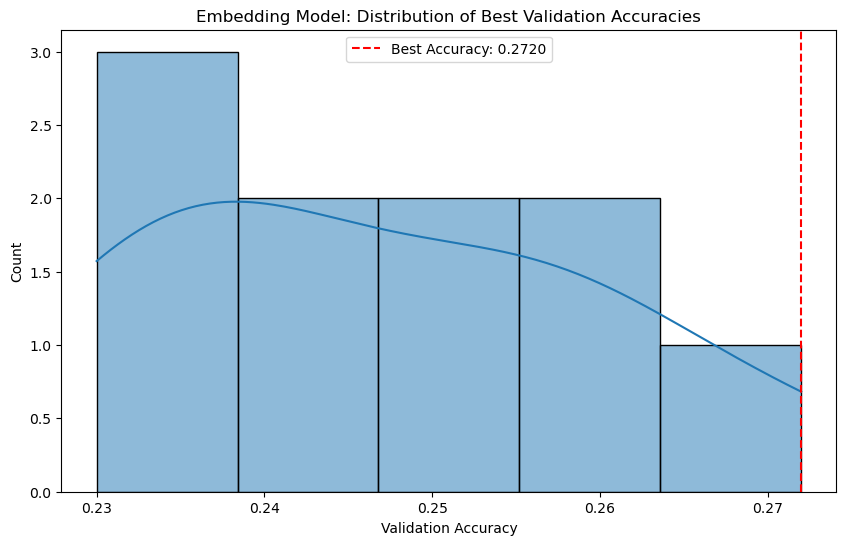

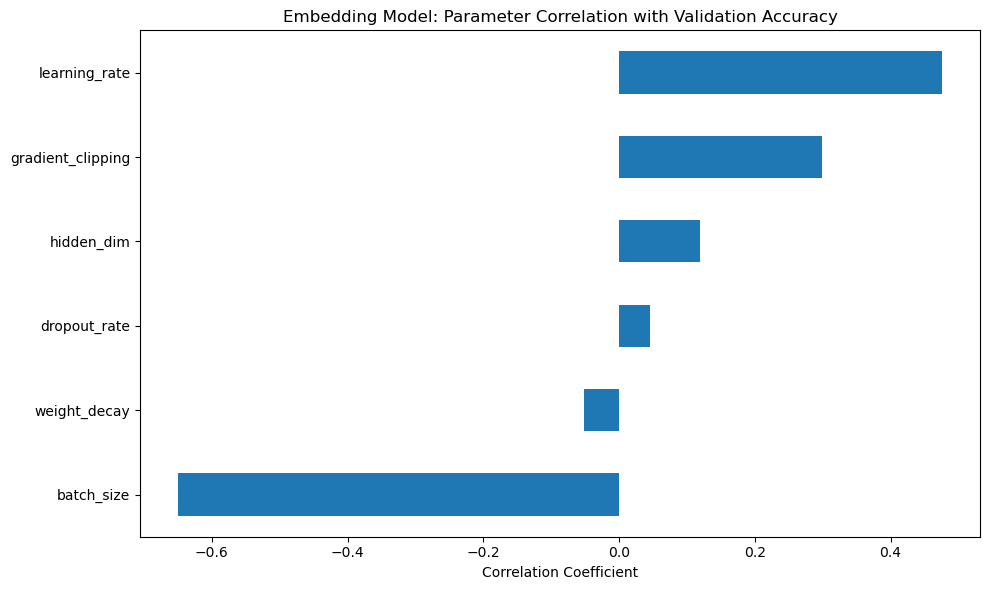

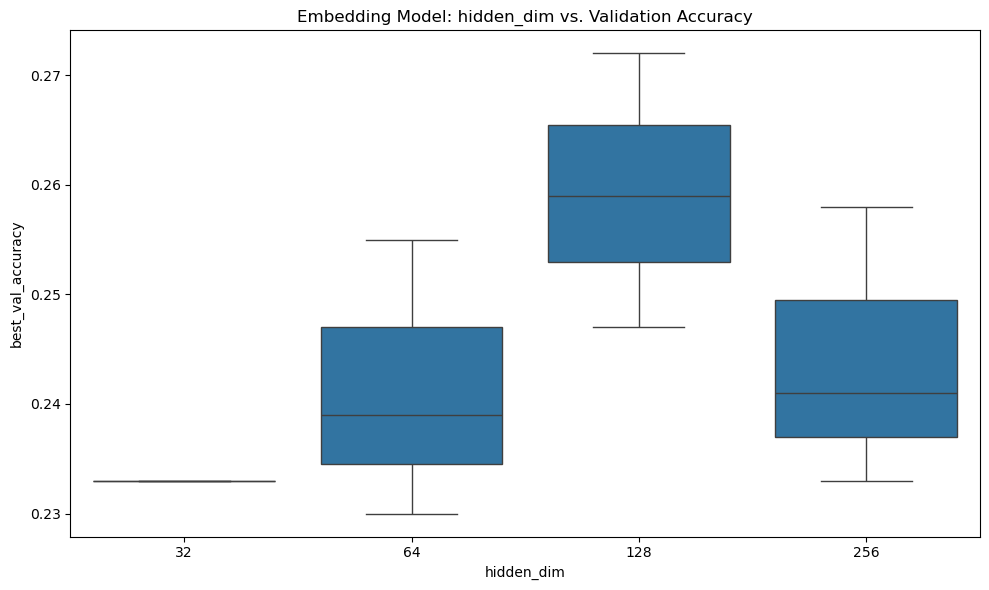

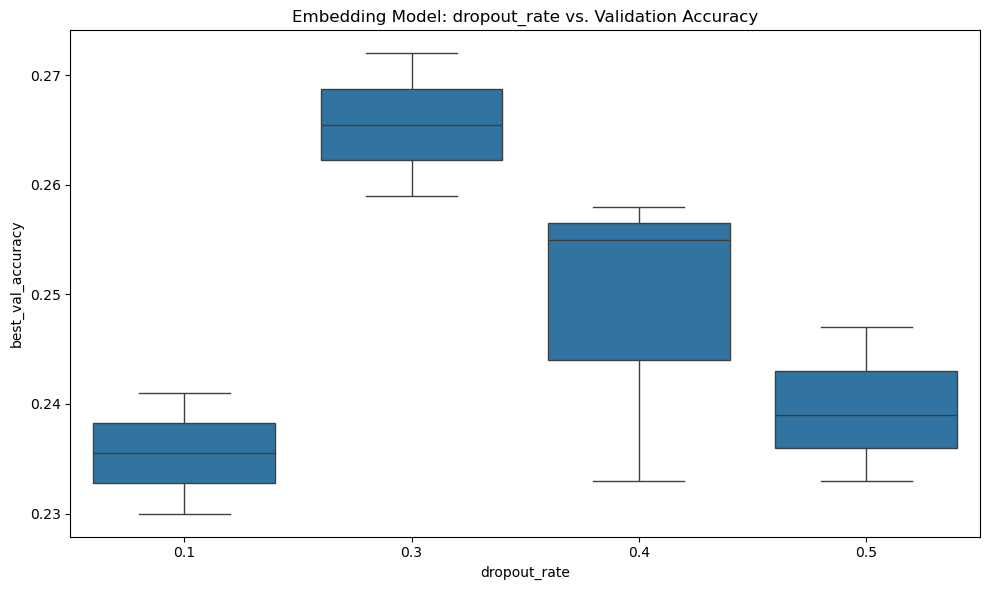

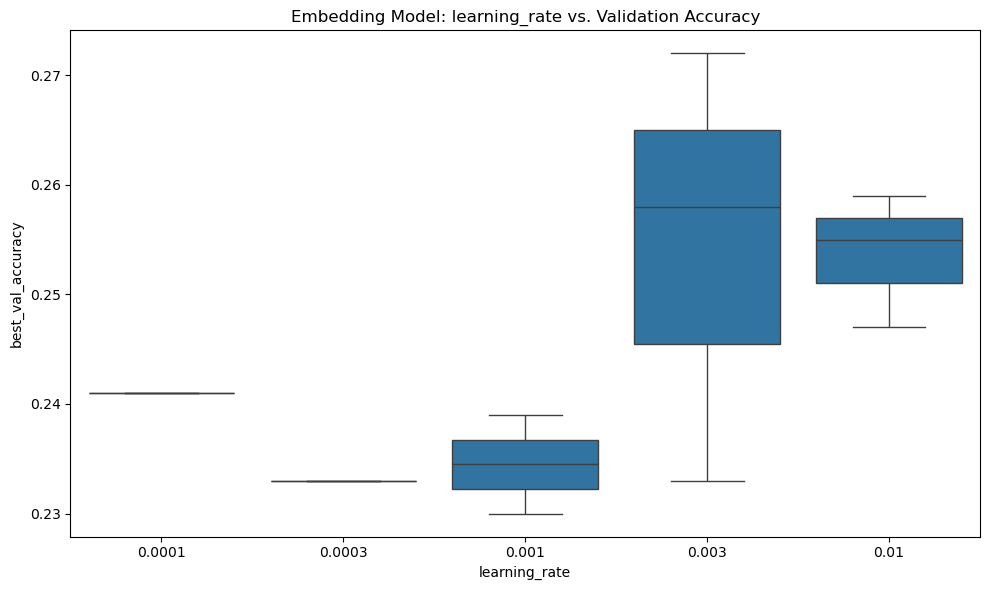

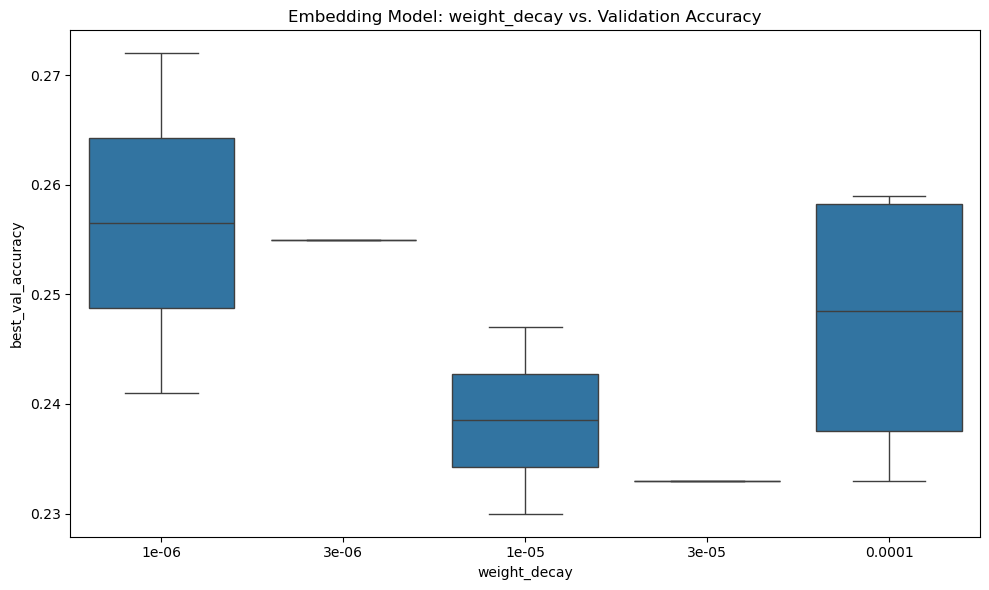

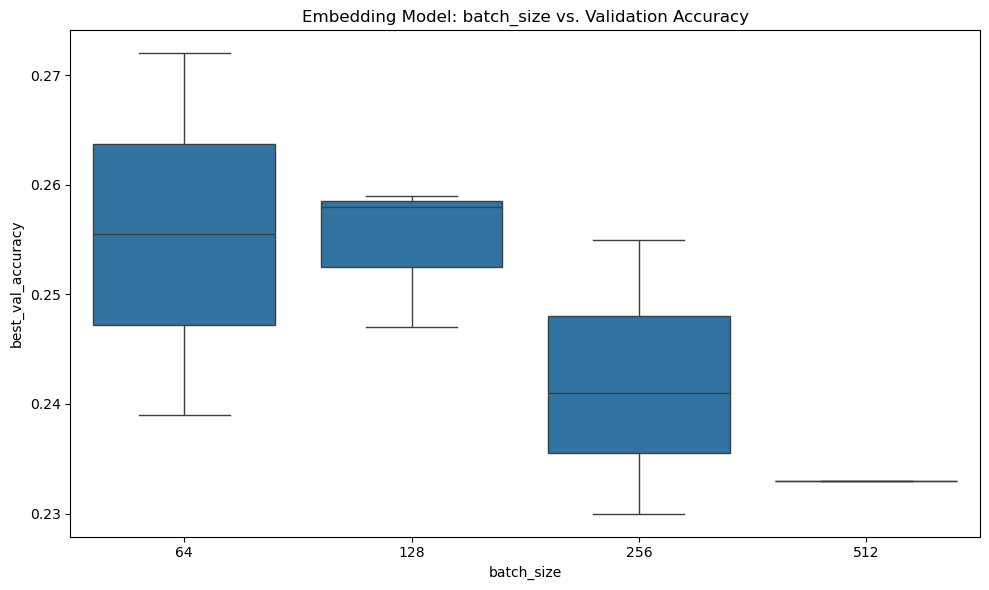

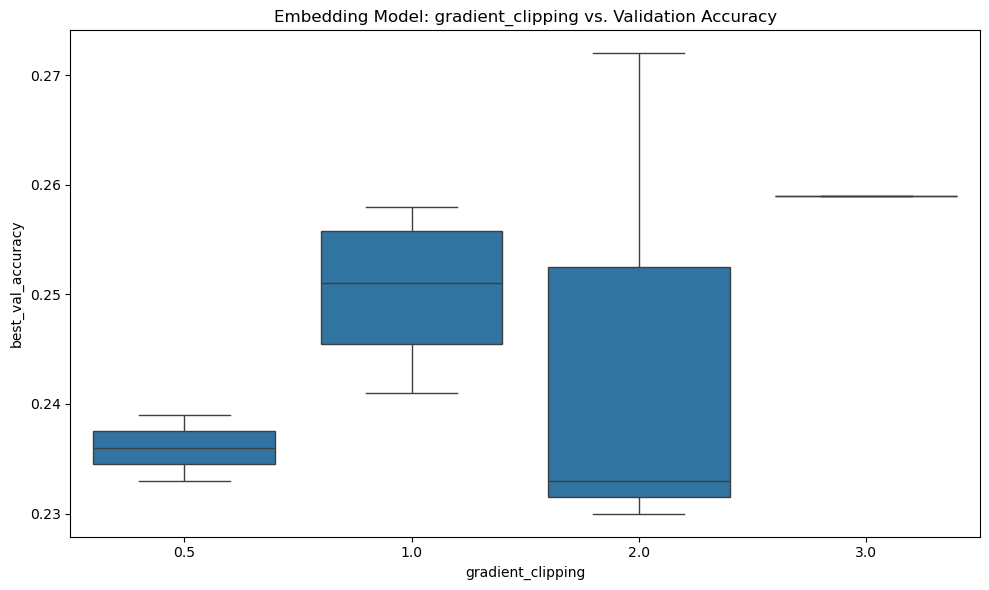

Analysis complete. Results saved to ./hyperopt_results/analysis_embedding
Analyzing 10 trials for rnn model
Best validation accuracy: 0.2550
Best run: trial_8_20250407_162158
Best hyperparameters:
  hidden_dim: 512
  dropout_rate: 0.1
  learning_rate: 0.0001
  weight_decay: 1e-06
  batch_size: 256
  gradient_clipping: 1.0
  pct_start: 0.4


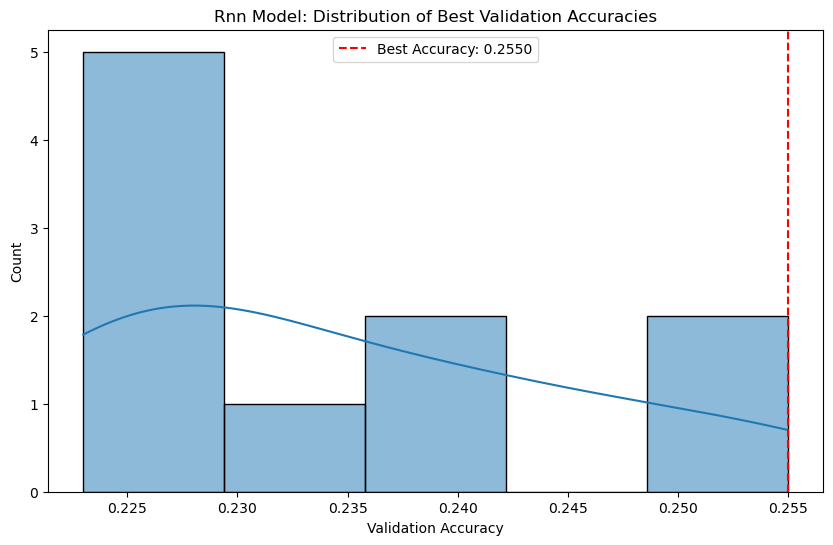

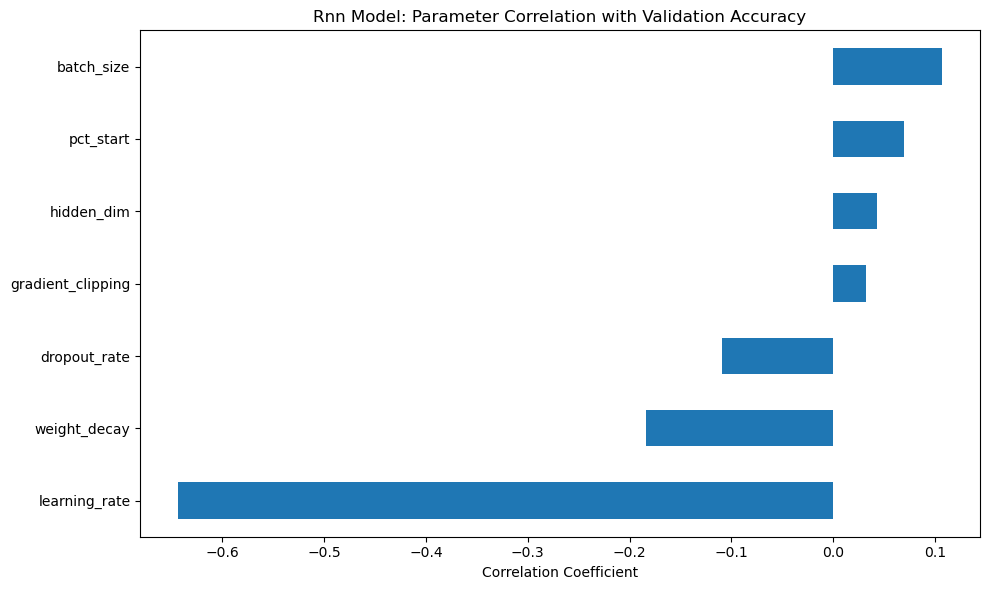

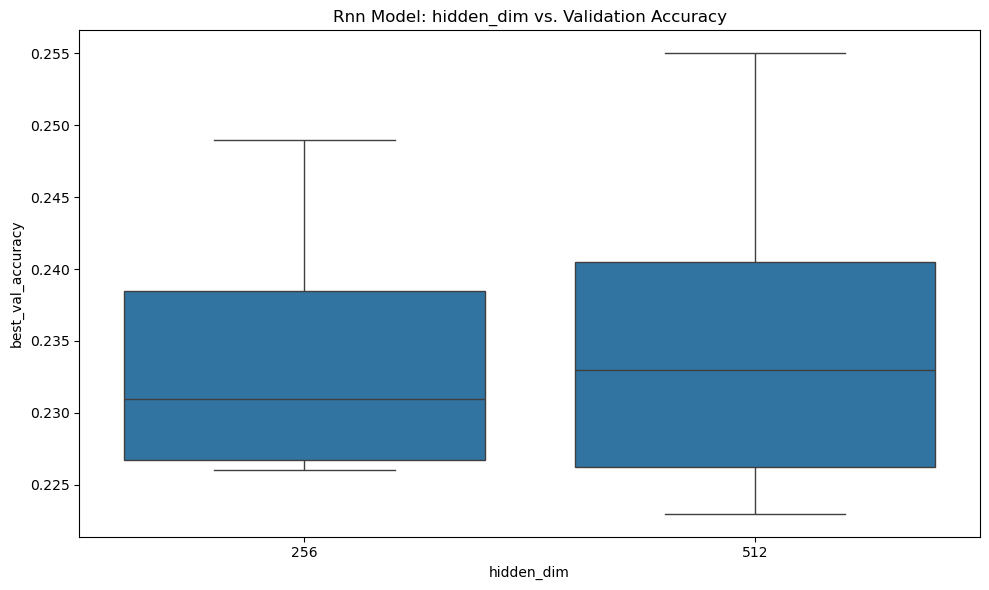

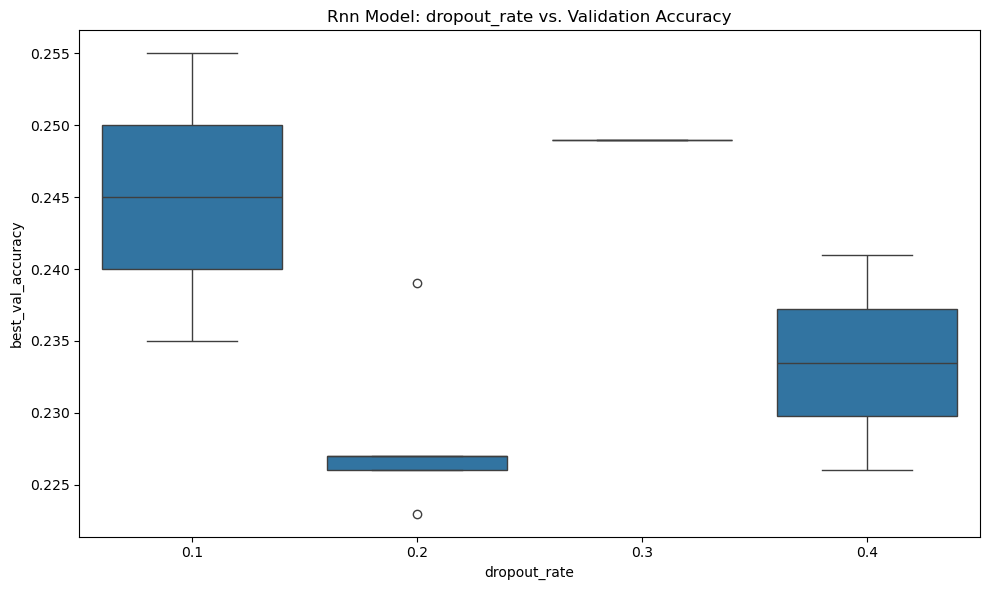

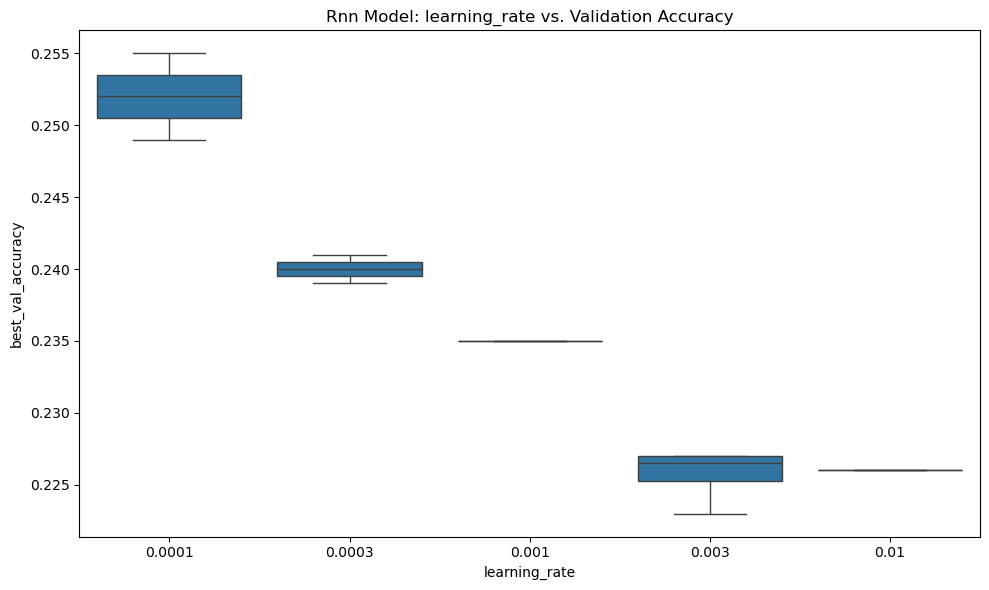

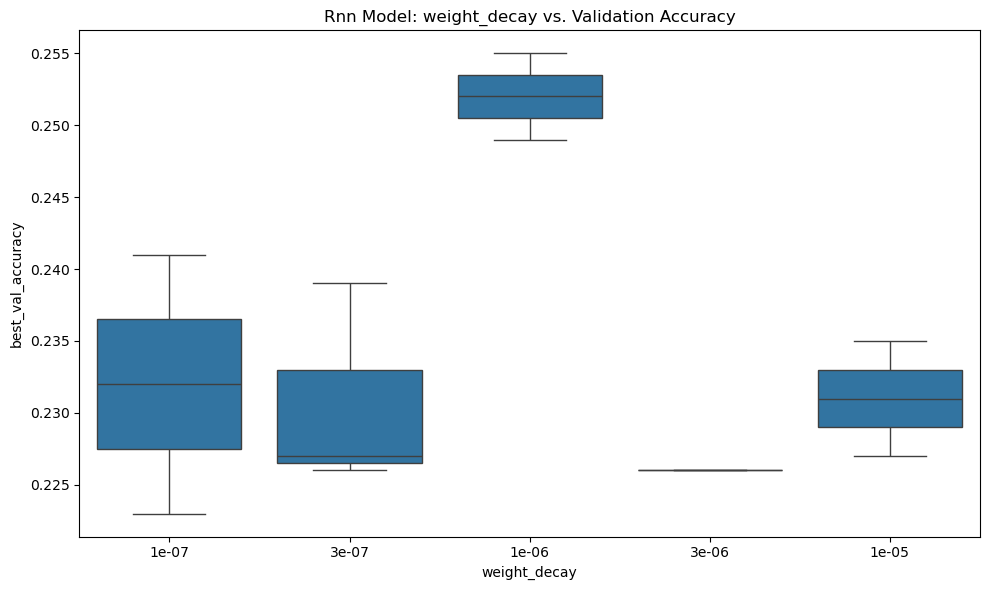

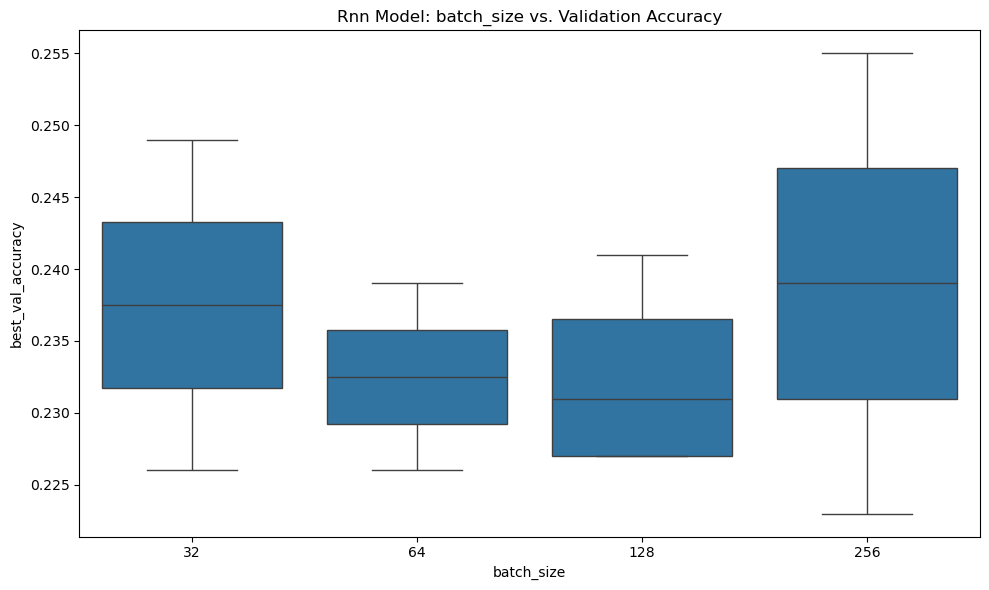

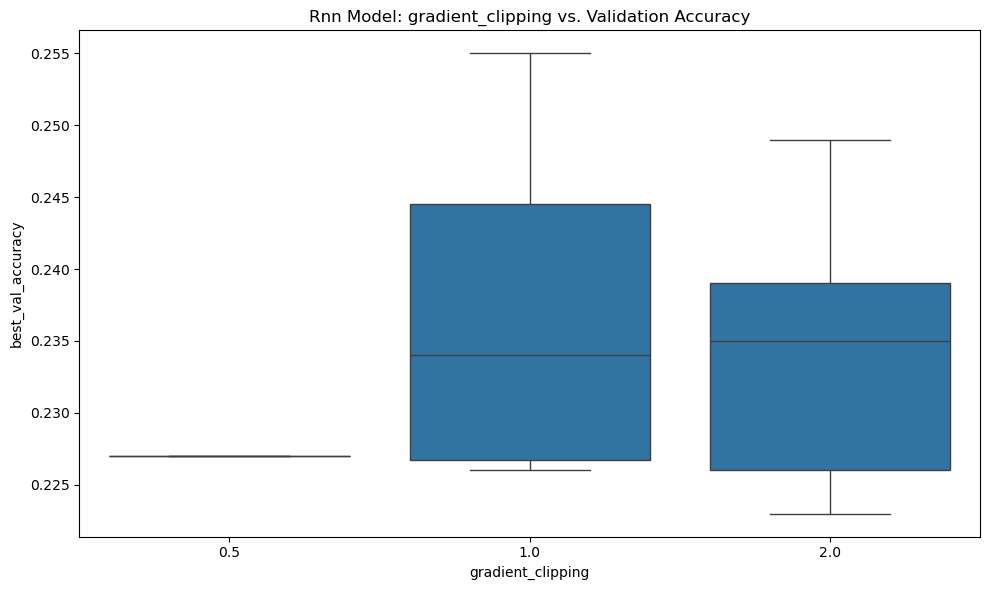

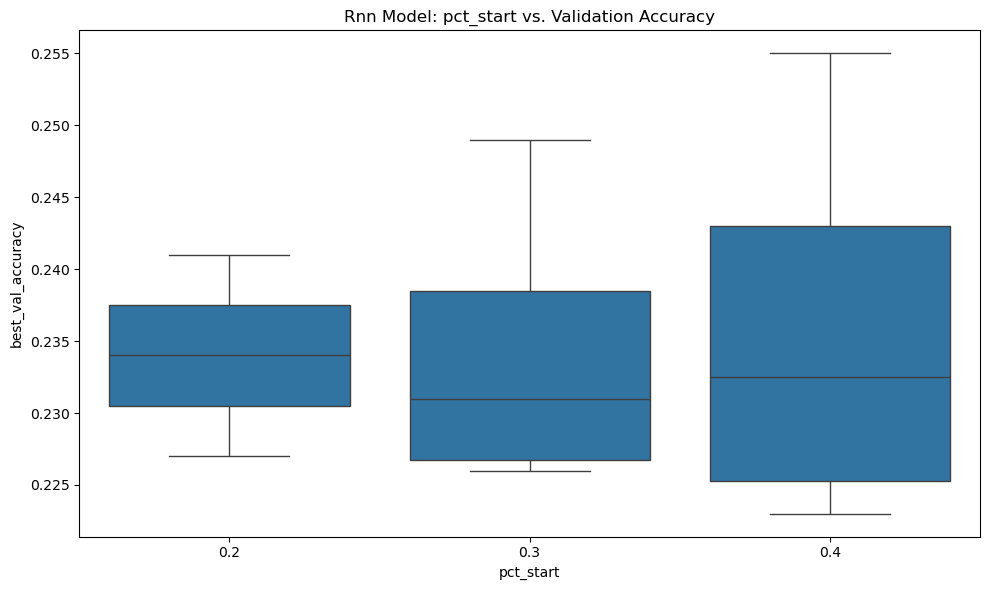

Analysis complete. Results saved to ./hyperopt_results/analysis_rnn

=== Training Best Models ===

=== Training Best Embedding Model ===
Using device: cuda
Calculating IDF scores...


Counting terms: 100%|██████████| 52446/52446 [00:01<00:00, 27883.87it/s]


Calculated IDF scores for 12015 terms
Calculating IDF scores...


Counting terms: 100%|██████████| 6000/6000 [00:00<00:00, 27880.68it/s]

Calculated IDF scores for 4346 terms
Error training model: batch_size should be a positive integer value, but got batch_size=64

=== Training Best RNN Model ===
Using device: cuda
Error training model: batch_size should be a positive integer value, but got batch_size=256

=== Hyperparameter Optimization Complete ===


In [37]:
# Cell 4: Run Hyperparameter Optimization

# Function to run complete hyperparameter optimization
def run_complete_hyperopt(embedding_trials=10, rnn_trials=10):
    """Run hyperparameter optimization for both models"""
    print("=== Starting Complete Hyperparameter Optimization ===")
    
    # Run embedding model hyperopt
    print("\n=== Embedding Model Hyperparameter Optimization ===")
    embedding_results = run_embedding_hyperopt(num_trials=embedding_trials)
    
    # Run RNN model hyperopt
    print("\n=== RNN Model Hyperparameter Optimization ===")
    rnn_results = run_rnn_hyperopt(num_trials=rnn_trials)
    
    # Analyze results
    print("\n=== Analyzing Results ===")
    analyze_hyperopt_results('./hyperopt_results/embedding_results.csv', model_type="embedding")
    analyze_hyperopt_results('./hyperopt_results/rnn_results.csv', model_type="rnn")
    
    # Train best models
    print("\n=== Training Best Models ===")
    
    # Get best embedding hyperparameters
    embedding_df = pd.read_csv('./hyperopt_results/embedding_results.csv')
    best_embedding_row = embedding_df.loc[embedding_df['best_val_accuracy'].idxmax()]
    best_embedding_params = {col: best_embedding_row[col] for col in embedding_df.columns 
                           if col not in ['run_id', 'timestamp', 'best_val_accuracy']}
    
    # Get best RNN hyperparameters
    rnn_df = pd.read_csv('./hyperopt_results/rnn_results.csv')
    best_rnn_row = rnn_df.loc[rnn_df['best_val_accuracy'].idxmax()]
    best_rnn_params = {col: best_rnn_row[col] for col in rnn_df.columns 
                      if col not in ['run_id', 'timestamp', 'best_val_accuracy']}
    
    # Train best embedding model for more epochs
    print("\n=== Training Best Embedding Model ===")
    best_embedding_run_id = f"best_{datetime.now().strftime('%Y%m%d_%H%M%S')}"
    train_embedding_model_with_params(best_embedding_params, best_embedding_run_id)
    
    # Train best RNN model for more epochs
    print("\n=== Training Best RNN Model ===")
    best_rnn_run_id = f"best_{datetime.now().strftime('%Y%m%d_%H%M%S')}"
    train_rnn_model_with_params(best_rnn_params, best_rnn_run_id)
    
    print("\n=== Hyperparameter Optimization Complete ===")
    
    return {
        'embedding_results': embedding_results,
        'rnn_results': rnn_results,
        'best_embedding_params': best_embedding_params,
        'best_rnn_params': best_rnn_params
    }

# Uncomment to run the complete optimization process
optimization_results = run_complete_hyperopt(embedding_trials=10, rnn_trials=10)

# Or run individual optimizations
# embedding_results = run_embedding_hyperopt(num_trials=10)
# rnn_results = run_rnn_hyperopt(num_trials=10)

Using device: cuda
Calculating IDF scores...


Counting terms: 100%|██████████| 52446/52446 [00:01<00:00, 27902.39it/s]


Calculated IDF scores for 12015 terms
Calculating IDF scores...


Counting terms: 100%|██████████| 6000/6000 [00:00<00:00, 27920.30it/s]


Calculated IDF scores for 4346 terms
Training optimized embedding model with parameters:
  hidden_dim: 128
  dropout_rate: 0.3
  learning_rate: 0.003
  weight_decay: 1e-06
  batch_size: 64
  gradient_clipping: 2.0

Epoch 1/50


Validation: 100%|██████████| 8/8 [00:00<00:00, 13.99it/s]


Validation accuracy improved from 0.0000 to 0.2150
Train Loss: 1.7206, Train Acc: 0.2058
Val Loss: 1.6105, Val Acc: 0.2150

Epoch 2/50


Validation: 100%|██████████| 8/8 [00:00<00:00, 13.76it/s]


Validation accuracy improved from 0.2150 to 0.2330
Train Loss: 1.6138, Train Acc: 0.2296
Val Loss: 1.6000, Val Acc: 0.2330

Epoch 3/50


Validation: 100%|██████████| 8/8 [00:00<00:00, 13.61it/s]


Train Loss: 1.5820, Train Acc: 0.2646
Val Loss: 1.6033, Val Acc: 0.2200

Epoch 4/50


Validation: 100%|██████████| 8/8 [00:00<00:00, 13.61it/s]


Validation accuracy improved from 0.2330 to 0.2350
Train Loss: 1.5811, Train Acc: 0.2653
Val Loss: 1.6011, Val Acc: 0.2350

Epoch 5/50


Validation: 100%|██████████| 8/8 [00:00<00:00, 13.76it/s]


Train Loss: 1.5570, Train Acc: 0.2914
Val Loss: 1.5988, Val Acc: 0.2310

Epoch 6/50


Validation: 100%|██████████| 8/8 [00:00<00:00, 13.53it/s]


Train Loss: 1.5458, Train Acc: 0.3005
Val Loss: 1.5969, Val Acc: 0.2320

Epoch 7/50


Validation: 100%|██████████| 8/8 [00:00<00:00, 13.11it/s]


Validation accuracy improved from 0.2350 to 0.2430
Train Loss: 1.5486, Train Acc: 0.2980
Val Loss: 1.5920, Val Acc: 0.2430

Epoch 8/50


Validation: 100%|██████████| 8/8 [00:00<00:00, 13.32it/s]


Train Loss: 1.5253, Train Acc: 0.3082
Val Loss: 1.5809, Val Acc: 0.2390

Epoch 9/50


Validation: 100%|██████████| 8/8 [00:00<00:00, 14.35it/s]


Train Loss: 1.4928, Train Acc: 0.3406
Val Loss: 1.5837, Val Acc: 0.2380

Epoch 10/50


Validation: 100%|██████████| 8/8 [00:00<00:00, 13.74it/s]


Validation accuracy improved from 0.2430 to 0.2440
Train Loss: 1.4489, Train Acc: 0.3702
Val Loss: 1.5924, Val Acc: 0.2440

Epoch 11/50


Validation: 100%|██████████| 8/8 [00:00<00:00, 13.93it/s]


Train Loss: 1.4283, Train Acc: 0.3868
Val Loss: 1.5970, Val Acc: 0.2420

Epoch 12/50


Validation: 100%|██████████| 8/8 [00:00<00:00, 13.68it/s]


Validation accuracy improved from 0.2440 to 0.2570
Train Loss: 1.4578, Train Acc: 0.3597
Val Loss: 1.5868, Val Acc: 0.2570

Epoch 13/50


Validation: 100%|██████████| 8/8 [00:00<00:00, 13.66it/s]


Validation accuracy improved from 0.2570 to 0.2630
Train Loss: 1.4634, Train Acc: 0.3576
Val Loss: 1.5960, Val Acc: 0.2630

Epoch 14/50


Validation: 100%|██████████| 8/8 [00:00<00:00, 14.05it/s]


Validation accuracy improved from 0.2630 to 0.2770
Train Loss: 1.4348, Train Acc: 0.3766
Val Loss: 1.5786, Val Acc: 0.2770

Epoch 15/50


Validation: 100%|██████████| 8/8 [00:00<00:00, 13.64it/s]


Train Loss: 1.3974, Train Acc: 0.3980
Val Loss: 1.6062, Val Acc: 0.2670

Epoch 16/50


Validation: 100%|██████████| 8/8 [00:00<00:00, 13.73it/s]


Train Loss: 1.3743, Train Acc: 0.4088
Val Loss: 1.6211, Val Acc: 0.2560

Epoch 17/50


Validation: 100%|██████████| 8/8 [00:00<00:00, 13.77it/s]


Train Loss: 1.3255, Train Acc: 0.4348
Val Loss: 1.6470, Val Acc: 0.2490

Epoch 18/50


Validation: 100%|██████████| 8/8 [00:00<00:00, 13.86it/s]


Train Loss: 1.2806, Train Acc: 0.4688
Val Loss: 1.6601, Val Acc: 0.2550

Epoch 19/50


Validation: 100%|██████████| 8/8 [00:00<00:00, 13.95it/s]


Train Loss: 1.2533, Train Acc: 0.4787
Val Loss: 1.6819, Val Acc: 0.2470

Epoch 20/50


Validation: 100%|██████████| 8/8 [00:00<00:00, 13.40it/s]


Train Loss: 1.2126, Train Acc: 0.4988
Val Loss: 1.7149, Val Acc: 0.2490

Epoch 21/50


Validation: 100%|██████████| 8/8 [00:00<00:00, 12.97it/s]


Train Loss: 1.1878, Train Acc: 0.5179
Val Loss: 1.7230, Val Acc: 0.2580

Epoch 22/50


Validation: 100%|██████████| 8/8 [00:00<00:00, 12.93it/s]


Train Loss: 1.1688, Train Acc: 0.5323
Val Loss: 1.7229, Val Acc: 0.2540

Epoch 23/50


Validation: 100%|██████████| 8/8 [00:00<00:00, 13.81it/s]


Train Loss: 1.1644, Train Acc: 0.5275
Val Loss: 1.7311, Val Acc: 0.2550

Epoch 24/50


Validation: 100%|██████████| 8/8 [00:00<00:00, 13.81it/s]


Train Loss: 1.2857, Train Acc: 0.4661
Val Loss: 1.6646, Val Acc: 0.2560

Epoch 25/50


Validation: 100%|██████████| 8/8 [00:00<00:00, 13.57it/s]


Train Loss: 1.2747, Train Acc: 0.4678
Val Loss: 1.6793, Val Acc: 0.2640

Epoch 26/50


Validation: 100%|██████████| 8/8 [00:00<00:00, 14.04it/s]


Train Loss: 1.2503, Train Acc: 0.4761
Val Loss: 1.6852, Val Acc: 0.2570

Epoch 27/50


Validation: 100%|██████████| 8/8 [00:00<00:00, 13.81it/s]


Train Loss: 1.2116, Train Acc: 0.4998
Val Loss: 1.7067, Val Acc: 0.2570

Epoch 28/50


Validation: 100%|██████████| 8/8 [00:00<00:00, 14.26it/s]


Train Loss: 1.1941, Train Acc: 0.5132
Val Loss: 1.7368, Val Acc: 0.2590

Epoch 29/50


Validation: 100%|██████████| 8/8 [00:00<00:00, 13.54it/s]


Train Loss: 1.1746, Train Acc: 0.5182
Val Loss: 1.7295, Val Acc: 0.2580

Epoch 30/50


Validation: 100%|██████████| 8/8 [00:00<00:00, 13.88it/s]


Train Loss: 1.1339, Train Acc: 0.5347
Val Loss: 1.7612, Val Acc: 0.2590

Epoch 31/50


Validation: 100%|██████████| 8/8 [00:00<00:00, 14.16it/s]


Train Loss: 1.1190, Train Acc: 0.5487
Val Loss: 1.7732, Val Acc: 0.2570

Epoch 32/50


Validation: 100%|██████████| 8/8 [00:00<00:00, 13.11it/s]


Train Loss: 1.0913, Train Acc: 0.5566
Val Loss: 1.8008, Val Acc: 0.2550

Epoch 33/50


Validation: 100%|██████████| 8/8 [00:00<00:00, 13.67it/s]


Train Loss: 1.0626, Train Acc: 0.5684
Val Loss: 1.8397, Val Acc: 0.2730

Epoch 34/50


Validation: 100%|██████████| 8/8 [00:01<00:00,  5.38it/s]


Train Loss: 1.0365, Train Acc: 0.5863
Val Loss: 1.8272, Val Acc: 0.2720

Epoch 35/50


Validation: 100%|██████████| 8/8 [00:00<00:00, 13.17it/s]


Train Loss: 0.9985, Train Acc: 0.6044
Val Loss: 1.8713, Val Acc: 0.2670

Epoch 36/50


Validation: 100%|██████████| 8/8 [00:00<00:00, 13.31it/s]


Train Loss: 0.9856, Train Acc: 0.6028
Val Loss: 1.8874, Val Acc: 0.2630

Epoch 37/50


Validation: 100%|██████████| 8/8 [00:00<00:00, 13.75it/s]


Train Loss: 0.9547, Train Acc: 0.6222
Val Loss: 1.9167, Val Acc: 0.2580

Epoch 38/50


Validation: 100%|██████████| 8/8 [00:00<00:00, 12.97it/s]


Train Loss: 0.9188, Train Acc: 0.6324
Val Loss: 1.9428, Val Acc: 0.2560

Epoch 39/50


Validation: 100%|██████████| 8/8 [00:00<00:00, 13.60it/s]


Train Loss: 0.9174, Train Acc: 0.6415
Val Loss: 1.9709, Val Acc: 0.2530

Epoch 40/50


Validation: 100%|██████████| 8/8 [00:00<00:00, 13.90it/s]


Train Loss: 0.8921, Train Acc: 0.6482
Val Loss: 1.9886, Val Acc: 0.2580

Epoch 41/50


Validation: 100%|██████████| 8/8 [00:00<00:00, 13.59it/s]


Train Loss: 0.8826, Train Acc: 0.6535
Val Loss: 2.0045, Val Acc: 0.2530

Epoch 42/50


Validation: 100%|██████████| 8/8 [00:00<00:00, 12.94it/s]


Train Loss: 0.8521, Train Acc: 0.6664
Val Loss: 2.0095, Val Acc: 0.2570

Epoch 43/50


Validation: 100%|██████████| 8/8 [00:00<00:00, 14.34it/s]


Train Loss: 0.8341, Train Acc: 0.6738
Val Loss: 2.0150, Val Acc: 0.2520

Epoch 44/50


Validation: 100%|██████████| 8/8 [00:00<00:00, 12.95it/s]


Train Loss: 0.8329, Train Acc: 0.6743
Val Loss: 2.0298, Val Acc: 0.2520

Epoch 45/50


Validation: 100%|██████████| 8/8 [00:00<00:00, 13.24it/s]


Train Loss: 0.8366, Train Acc: 0.6749
Val Loss: 2.0370, Val Acc: 0.2540

Epoch 46/50


Validation: 100%|██████████| 8/8 [00:00<00:00, 13.49it/s]


Train Loss: 0.8158, Train Acc: 0.6810
Val Loss: 2.0341, Val Acc: 0.2580

Epoch 47/50


Validation: 100%|██████████| 8/8 [00:00<00:00, 13.55it/s]


Train Loss: 0.9288, Train Acc: 0.6269
Val Loss: 1.9708, Val Acc: 0.2600

Epoch 48/50


Validation: 100%|██████████| 8/8 [00:00<00:00, 13.21it/s]


Train Loss: 0.9894, Train Acc: 0.6038
Val Loss: 1.9418, Val Acc: 0.2650

Epoch 49/50


Validation: 100%|██████████| 8/8 [00:00<00:00, 13.59it/s]


Train Loss: 0.9912, Train Acc: 0.6053
Val Loss: 1.9043, Val Acc: 0.2580

Epoch 50/50


Validation: 100%|██████████| 8/8 [00:00<00:00, 13.94it/s]


Train Loss: 0.9949, Train Acc: 0.6019
Val Loss: 1.9308, Val Acc: 0.2560


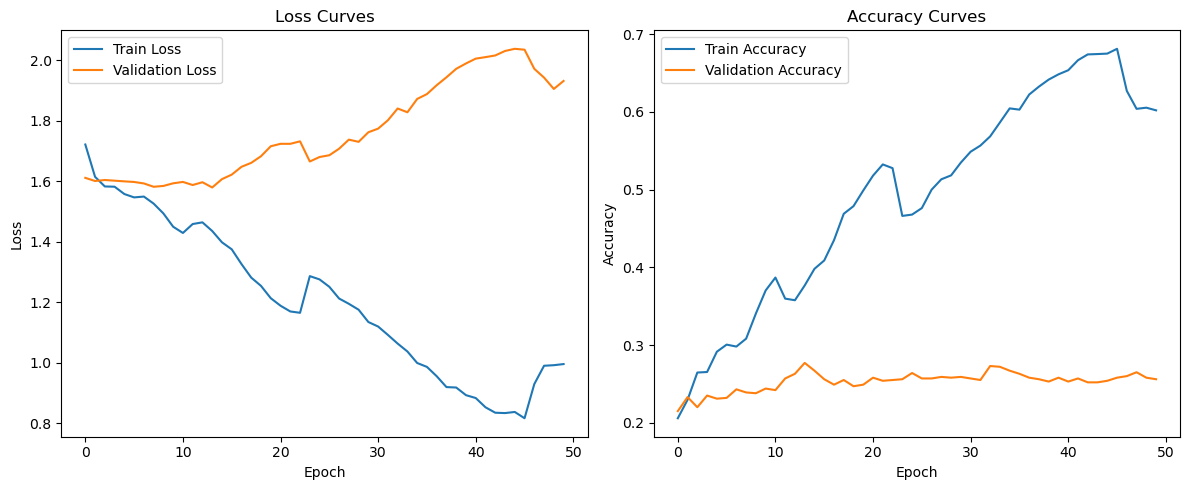

Final model saved. Best validation accuracy: 0.2770
Using device: cuda
Calculating IDF scores...


Counting terms: 100%|██████████| 52446/52446 [00:01<00:00, 28119.30it/s]


Calculated IDF scores for 12015 terms
Calculating IDF scores...


Counting terms: 100%|██████████| 6000/6000 [00:00<00:00, 28049.38it/s]


Calculated IDF scores for 4346 terms
Training optimized embedding model with parameters:
  hidden_dim: 512
  dropout_rate: 0.4
  learning_rate: 0.0003
  weight_decay: 1e-07
  batch_size: 128
  gradient_clipping: 1.0
  pct_start: 0.2

Epoch 1/50


Validation: 100%|██████████| 4/4 [00:00<00:00,  7.00it/s]


Validation accuracy improved from 0.0000 to 0.2240
Train Loss: 1.9525, Train Acc: 0.1977
Val Loss: 1.6182, Val Acc: 0.2240

Epoch 2/50


Validation: 100%|██████████| 4/4 [00:00<00:00,  6.78it/s]


Validation accuracy improved from 0.2240 to 0.2350
Train Loss: 1.8463, Train Acc: 0.2205
Val Loss: 1.6085, Val Acc: 0.2350

Epoch 3/50


Validation: 100%|██████████| 4/4 [00:00<00:00,  7.21it/s]


Train Loss: 1.8281, Train Acc: 0.2173
Val Loss: 1.6066, Val Acc: 0.2140

Epoch 4/50


Validation: 100%|██████████| 4/4 [00:00<00:00,  7.04it/s]


Train Loss: 1.7538, Train Acc: 0.2319
Val Loss: 1.6029, Val Acc: 0.2190

Epoch 5/50


Validation: 100%|██████████| 4/4 [00:00<00:00,  6.94it/s]


Train Loss: 1.7226, Train Acc: 0.2380
Val Loss: 1.6019, Val Acc: 0.2300

Epoch 6/50


Validation: 100%|██████████| 4/4 [00:00<00:00,  6.97it/s]


Train Loss: 1.7274, Train Acc: 0.2318
Val Loss: 1.6010, Val Acc: 0.2350

Epoch 7/50


Validation: 100%|██████████| 4/4 [00:00<00:00,  6.88it/s]


Train Loss: 1.6800, Train Acc: 0.2416
Val Loss: 1.5975, Val Acc: 0.2340

Epoch 8/50


Validation: 100%|██████████| 4/4 [00:00<00:00,  6.74it/s]


Validation accuracy improved from 0.2350 to 0.2390
Train Loss: 1.6392, Train Acc: 0.2599
Val Loss: 1.5954, Val Acc: 0.2390

Epoch 9/50


Validation: 100%|██████████| 4/4 [00:00<00:00,  6.70it/s]


Train Loss: 1.6298, Train Acc: 0.2576
Val Loss: 1.5943, Val Acc: 0.2380

Epoch 10/50


Validation: 100%|██████████| 4/4 [00:01<00:00,  2.72it/s]


Validation accuracy improved from 0.2390 to 0.2480
Train Loss: 1.6219, Train Acc: 0.2623
Val Loss: 1.5922, Val Acc: 0.2480

Epoch 11/50


Validation: 100%|██████████| 4/4 [00:00<00:00,  6.76it/s]


Validation accuracy improved from 0.2480 to 0.2510
Train Loss: 1.6207, Train Acc: 0.2644
Val Loss: 1.5918, Val Acc: 0.2510

Epoch 12/50


Validation: 100%|██████████| 4/4 [00:00<00:00,  7.18it/s]


Train Loss: 1.6188, Train Acc: 0.2586
Val Loss: 1.5935, Val Acc: 0.2450

Epoch 13/50


Validation: 100%|██████████| 4/4 [00:00<00:00,  6.92it/s]


Train Loss: 1.5939, Train Acc: 0.2749
Val Loss: 1.5926, Val Acc: 0.2480

Epoch 14/50


Validation: 100%|██████████| 4/4 [00:00<00:00,  6.93it/s]


Train Loss: 1.5731, Train Acc: 0.2814
Val Loss: 1.5920, Val Acc: 0.2490

Epoch 15/50


Validation: 100%|██████████| 4/4 [00:00<00:00,  6.89it/s]


Train Loss: 1.5590, Train Acc: 0.2961
Val Loss: 1.5898, Val Acc: 0.2440

Epoch 16/50


Validation: 100%|██████████| 4/4 [00:00<00:00,  7.02it/s]


Validation accuracy improved from 0.2510 to 0.2550
Train Loss: 1.5466, Train Acc: 0.2981
Val Loss: 1.5905, Val Acc: 0.2550

Epoch 17/50


Validation: 100%|██████████| 4/4 [00:00<00:00,  6.92it/s]


Train Loss: 1.5392, Train Acc: 0.3005
Val Loss: 1.5918, Val Acc: 0.2530

Epoch 18/50


Validation: 100%|██████████| 4/4 [00:00<00:00,  7.23it/s]


Train Loss: 1.5320, Train Acc: 0.3186
Val Loss: 1.5909, Val Acc: 0.2510

Epoch 19/50


Validation: 100%|██████████| 4/4 [00:00<00:00,  6.86it/s]


Validation accuracy improved from 0.2550 to 0.2560
Train Loss: 1.5206, Train Acc: 0.3171
Val Loss: 1.5909, Val Acc: 0.2560

Epoch 20/50


Validation: 100%|██████████| 4/4 [00:00<00:00,  6.83it/s]


Train Loss: 1.5231, Train Acc: 0.3167
Val Loss: 1.5901, Val Acc: 0.2550

Epoch 21/50


Validation: 100%|██████████| 4/4 [00:00<00:00,  6.98it/s]


Train Loss: 1.5220, Train Acc: 0.3148
Val Loss: 1.5902, Val Acc: 0.2510

Epoch 22/50


Validation: 100%|██████████| 4/4 [00:00<00:00,  6.86it/s]


Train Loss: 1.5190, Train Acc: 0.3219
Val Loss: 1.5902, Val Acc: 0.2550

Epoch 23/50


Validation: 100%|██████████| 4/4 [00:00<00:00,  6.86it/s]


Validation accuracy improved from 0.2560 to 0.2600
Train Loss: 1.5225, Train Acc: 0.3195
Val Loss: 1.5891, Val Acc: 0.2600

Epoch 24/50


Validation: 100%|██████████| 4/4 [00:01<00:00,  2.71it/s]


Train Loss: 1.5102, Train Acc: 0.3247
Val Loss: 1.5886, Val Acc: 0.2590

Epoch 25/50


Validation: 100%|██████████| 4/4 [00:00<00:00,  6.70it/s]


Train Loss: 1.5107, Train Acc: 0.3265
Val Loss: 1.5859, Val Acc: 0.2510

Epoch 26/50


Validation: 100%|██████████| 4/4 [00:00<00:00,  7.09it/s]


Train Loss: 1.4923, Train Acc: 0.3413
Val Loss: 1.5849, Val Acc: 0.2420

Epoch 27/50


Validation: 100%|██████████| 4/4 [00:00<00:00,  6.95it/s]


Train Loss: 1.4854, Train Acc: 0.3398
Val Loss: 1.5859, Val Acc: 0.2470

Epoch 28/50


Validation: 100%|██████████| 4/4 [00:00<00:00,  6.79it/s]


Train Loss: 1.4794, Train Acc: 0.3500
Val Loss: 1.5845, Val Acc: 0.2470

Epoch 29/50


Validation: 100%|██████████| 4/4 [00:00<00:00,  7.01it/s]


Train Loss: 1.4577, Train Acc: 0.3653
Val Loss: 1.5852, Val Acc: 0.2580

Epoch 30/50


Validation: 100%|██████████| 4/4 [00:00<00:00,  7.00it/s]


Train Loss: 1.4632, Train Acc: 0.3633
Val Loss: 1.5851, Val Acc: 0.2530

Epoch 31/50


Validation: 100%|██████████| 4/4 [00:00<00:00,  6.91it/s]


Train Loss: 1.4510, Train Acc: 0.3700
Val Loss: 1.5864, Val Acc: 0.2510

Epoch 32/50


Validation: 100%|██████████| 4/4 [00:00<00:00,  7.15it/s]


Train Loss: 1.4296, Train Acc: 0.3814
Val Loss: 1.5897, Val Acc: 0.2440

Epoch 33/50


Validation: 100%|██████████| 4/4 [00:00<00:00,  7.10it/s]


Train Loss: 1.4150, Train Acc: 0.3900
Val Loss: 1.5907, Val Acc: 0.2500

Epoch 34/50


Validation: 100%|██████████| 4/4 [00:00<00:00,  7.11it/s]


Train Loss: 1.4147, Train Acc: 0.3966
Val Loss: 1.5885, Val Acc: 0.2490

Epoch 35/50


Validation: 100%|██████████| 4/4 [00:00<00:00,  6.92it/s]


Train Loss: 1.4013, Train Acc: 0.4036
Val Loss: 1.5871, Val Acc: 0.2510

Epoch 36/50


Validation: 100%|██████████| 4/4 [00:00<00:00,  6.72it/s]


Train Loss: 1.3955, Train Acc: 0.4049
Val Loss: 1.5897, Val Acc: 0.2500

Epoch 37/50


Validation: 100%|██████████| 4/4 [00:00<00:00,  6.77it/s]


Train Loss: 1.3893, Train Acc: 0.4034
Val Loss: 1.5897, Val Acc: 0.2540

Epoch 38/50


Validation: 100%|██████████| 4/4 [00:01<00:00,  2.74it/s]


Train Loss: 1.3857, Train Acc: 0.4113
Val Loss: 1.5925, Val Acc: 0.2480

Epoch 39/50


Validation: 100%|██████████| 4/4 [00:00<00:00,  6.65it/s]


Train Loss: 1.3827, Train Acc: 0.4128
Val Loss: 1.5921, Val Acc: 0.2510

Epoch 40/50


Validation: 100%|██████████| 4/4 [00:00<00:00,  7.10it/s]


Train Loss: 1.3685, Train Acc: 0.4226
Val Loss: 1.5938, Val Acc: 0.2530

Epoch 41/50


Validation: 100%|██████████| 4/4 [00:00<00:00,  6.75it/s]


Train Loss: 1.3711, Train Acc: 0.4193
Val Loss: 1.5923, Val Acc: 0.2450

Epoch 42/50


Validation: 100%|██████████| 4/4 [00:00<00:00,  7.02it/s]


Train Loss: 1.3683, Train Acc: 0.4234
Val Loss: 1.5924, Val Acc: 0.2540

Epoch 43/50


Validation: 100%|██████████| 4/4 [00:00<00:00,  7.00it/s]


Train Loss: 1.3630, Train Acc: 0.4311
Val Loss: 1.5935, Val Acc: 0.2540

Epoch 44/50


Validation: 100%|██████████| 4/4 [00:00<00:00,  6.91it/s]


Train Loss: 1.3720, Train Acc: 0.4228
Val Loss: 1.5926, Val Acc: 0.2520

Epoch 45/50


Validation: 100%|██████████| 4/4 [00:00<00:00,  6.90it/s]


Train Loss: 1.3559, Train Acc: 0.4362
Val Loss: 1.5932, Val Acc: 0.2520

Epoch 46/50


Validation: 100%|██████████| 4/4 [00:00<00:00,  6.91it/s]


Train Loss: 1.3582, Train Acc: 0.4305
Val Loss: 1.5926, Val Acc: 0.2550

Epoch 47/50


Validation: 100%|██████████| 4/4 [00:00<00:00,  7.05it/s]


Train Loss: 1.3663, Train Acc: 0.4200
Val Loss: 1.5990, Val Acc: 0.2480

Epoch 48/50


Validation: 100%|██████████| 4/4 [00:00<00:00,  6.95it/s]


Train Loss: 1.3624, Train Acc: 0.4272
Val Loss: 1.5999, Val Acc: 0.2570

Epoch 49/50


Validation: 100%|██████████| 4/4 [00:00<00:00,  6.69it/s]


Train Loss: 1.3532, Train Acc: 0.4267
Val Loss: 1.6052, Val Acc: 0.2480

Epoch 50/50


Validation: 100%|██████████| 4/4 [00:00<00:00,  6.76it/s]


Train Loss: 1.3266, Train Acc: 0.4450
Val Loss: 1.6044, Val Acc: 0.2530


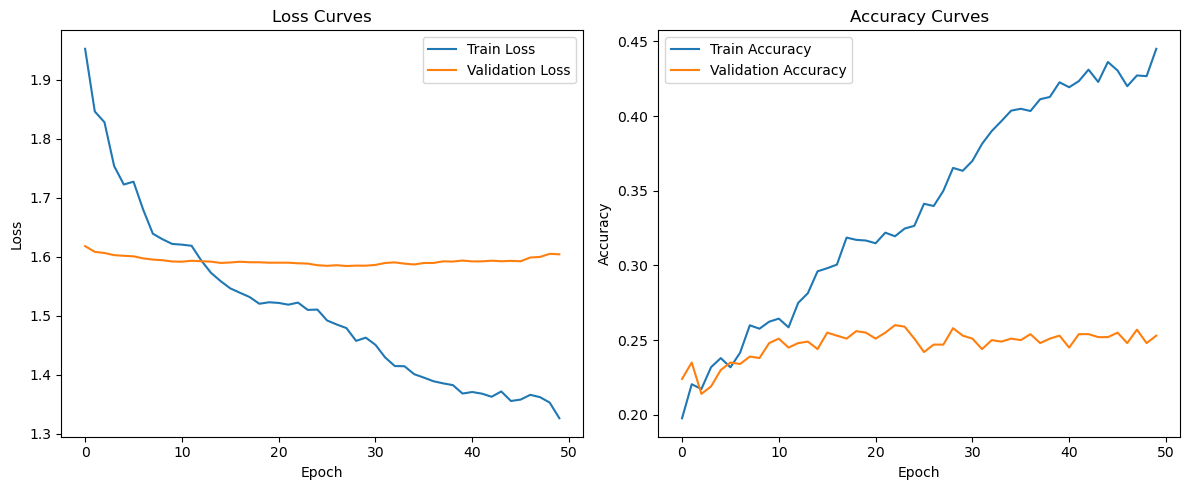

Final model saved. Best validation accuracy: 0.2600


In [38]:
# Cell 6: Train Best Models with Optimal Hyperparameters

def train_best_embedding_model_final(params):
    """Train the embedding model with optimal hyperparameters for more epochs"""
    # Set device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    
    # Create datasets
    train_dataset = CommonsenseQAEmbeddingDataset(
        train, 
        wv,
        embedding_dim=300,
        cache_path='train_tfidf_embeddings.pkl',
        use_tfidf=True
    )
    valid_dataset = CommonsenseQAEmbeddingDataset(
        valid, 
        wv,
        embedding_dim=300,
        cache_path='valid_tfidf_embeddings.pkl',
        use_tfidf=True
    )
    
    normalized_train_dataset = NormalizedEmbeddingDataset(train_dataset)
    normalized_valid_dataset = NormalizedEmbeddingDataset(valid_dataset)
    augmented_train_dataset = AugmentedEmbeddingDataset(normalized_train_dataset, noise_scale=0.01)
    
    # Create data loaders
    train_loader = DataLoader(
        augmented_train_dataset,
        batch_size=int(params['batch_size']),
        shuffle=True,
        num_workers=4,
        pin_memory=True
    )
    
    valid_loader = DataLoader(
        normalized_valid_dataset,
        batch_size=int(params['batch_size']) * 2,
        shuffle=False,
        num_workers=4,
        pin_memory=True
    )
    
    # Create model
    model = QASimpleClassifier(
        embedding_dim=300,
        hidden_dim=int(params['hidden_dim']),
        dropout_rate=float(params['dropout_rate'])
    ).to(device)
    
    # Loss function
    criterion = nn.CrossEntropyLoss()
    
    # Optimizer
    optimizer = torch.optim.Adam(
        model.parameters(),
        lr=float(params['learning_rate']),
        weight_decay=float(params['weight_decay'])
    )
    
    # Learning rate scheduler
    scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
        optimizer,
        T_0=50,
        T_mult=2,
        eta_min=1e-5
    )
    
    # Setup checkpoint directory
    checkpoints_path = "./hyperopt_checkpoints/best_embedding_final"
    os.makedirs(checkpoints_path, exist_ok=True)
    
    print(f"Training optimized embedding model with parameters:")
    for key, value in params.items():
        print(f"  {key}: {value}")
    
    # Store all training metrics
    metrics = {
        'train_loss': [],
        'train_accuracy': [],
        'val_loss': [],
        'val_accuracy': [],
        'learning_rate': []
    }
        
    # Training loop
    best_val_accuracy = 0.0
    num_epochs = 50  # Train for longer
    
    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")
        
        # Training phase
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0
        
        with tqdm(train_loader, desc="Training") as progress_bar:
            for question_batch, choices_batch, answer_batch in progress_bar:
                # Move to device
                question_batch = question_batch.to(device)
                choices_batch = choices_batch.to(device)
                answer_batch = answer_batch.to(device)
                
                # Forward pass
                optimizer.zero_grad()
                outputs = model(question_batch, choices_batch)
                loss = criterion(outputs, answer_batch)
                
                # Backward pass
                loss.backward()
                if float(params['gradient_clipping']) > 0:
                    nn.utils.clip_grad_norm_(model.parameters(), float(params['gradient_clipping']))
                optimizer.step()
                
                # Step scheduler
                scheduler.step()
                
                # Statistics
                train_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                train_total += answer_batch.size(0)
                train_correct += (predicted == answer_batch).sum().item()
                
                # Update progress bar
                progress_bar.set_postfix({
                    'loss': f"{loss.item():.4f}",
                    'acc': f"{train_correct/train_total:.4f}"
                })
        
        train_accuracy = train_correct / train_total
        avg_train_loss = train_loss / len(train_loader)
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        
        with torch.no_grad():
            for question_batch, choices_batch, answer_batch in tqdm(valid_loader, desc="Validation"):
                # Move to device
                question_batch = question_batch.to(device)
                choices_batch = choices_batch.to(device)
                answer_batch = answer_batch.to(device)
                
                # Forward pass
                outputs = model(question_batch, choices_batch)
                loss = criterion(outputs, answer_batch)
                
                # Statistics
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                val_total += answer_batch.size(0)
                val_correct += (predicted == answer_batch).sum().item()
        
        val_accuracy = val_correct / val_total
        avg_val_loss = val_loss / len(valid_loader)
        
        # Log metrics
        metrics['train_loss'].append(avg_train_loss)
        metrics['train_accuracy'].append(train_accuracy)
        metrics['val_loss'].append(avg_val_loss)
        metrics['val_accuracy'].append(val_accuracy)
        metrics['learning_rate'].append(optimizer.param_groups[0]['lr'])
        
        # Save best model
        if val_accuracy > best_val_accuracy:
            print(f"Validation accuracy improved from {best_val_accuracy:.4f} to {val_accuracy:.4f}")
            best_val_accuracy = val_accuracy
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict(),
                'val_accuracy': val_accuracy,
                'hyperparams': params
            }, f"{checkpoints_path}/best_model.pt")
        
        # Print metrics
        print(f"Train Loss: {avg_train_loss:.4f}, Train Acc: {train_accuracy:.4f}")
        print(f"Val Loss: {avg_val_loss:.4f}, Val Acc: {val_accuracy:.4f}")
    
    # Plot training curves
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(metrics['train_loss'], label='Train Loss')
    plt.plot(metrics['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss Curves')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(metrics['train_accuracy'], label='Train Accuracy')
    plt.plot(metrics['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy Curves')
    plt.legend()
    
    plt.tight_layout()
    plt.savefig(f"{checkpoints_path}/training_curves.png")
    plt.show()
    
    # Save final model and metrics
    torch.save({
        'epoch': num_epochs-1,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict(),
        'val_accuracy': val_accuracy,
        'best_val_accuracy': best_val_accuracy,
        'hyperparams': params,
        'metrics': metrics
    }, f"{checkpoints_path}/final_model.pt")
    
    print(f"Final model saved. Best validation accuracy: {best_val_accuracy:.4f}")
    return model, best_val_accuracy

def train_best_rnn_model_final(params):
    """Train the RNN model with optimal hyperparameters for more epochs"""
    # Set device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    
    # Create datasets
    train_rnn_dataset = CommonsenseQARNNDataset(
        train, 
        wv,
        embedding_dim=300
    )
    
    valid_rnn_dataset = CommonsenseQARNNDataset(
        valid, 
        wv,
        embedding_dim=300
    )
    
    # Create data loaders
    train_rnn_loader = DataLoader(
        train_rnn_dataset,
        batch_size=int(params['batch_size']),
        shuffle=True,
        collate_fn=rnn_collate_batch,
        num_workers=4,
        pin_memory=True
    )
    
    valid_rnn_loader = DataLoader(
        valid_rnn_dataset,
        batch_size=int(params['batch_size']) * 2,
        shuffle=False,
        collate_fn=rnn_collate_batch,
        num_workers=4,
        pin_memory=True
    )
    
    # Create model
    rnn_model = QARNNModel(
        embedding_dim=300,
        hidden_dim=int(params['hidden_dim']),
        dropout_rate=float(params['dropout_rate'])
    ).to(device)
    
    # Loss function
    criterion = nn.CrossEntropyLoss()
    
    # Optimizer
    optimizer = torch.optim.Adam(
        rnn_model.parameters(),
        lr=float(params['learning_rate']),
        weight_decay=float(params['weight_decay'])
    )
    
    # Calculate total steps for OneCycleLR
    num_epochs = 50  # Train for longer
    total_steps = num_epochs * len(train_rnn_loader)
    
    # Learning rate scheduler
    scheduler = torch.optim.lr_scheduler.OneCycleLR(
        optimizer,
        max_lr=float(params['learning_rate']),
        total_steps=total_steps,
        pct_start=float(params['pct_start']),
        div_factor=25,
        final_div_factor=1000,
        anneal_strategy='cos'
    )
    
    # Setup checkpoint directory
    checkpoints_path = "./hyperopt_checkpoints/best_rnn_final"
    os.makedirs(checkpoints_path, exist_ok=True)
    
    print(f"Training optimized RNN model with parameters:")
    for key, value in params.items():
        print(f"  {key}: {value}")
    
    # Store all training metrics
    metrics = {
        'train_loss': [],
        'train_accuracy': [],
        'val_loss': [],
        'val_accuracy': [],
        'learning_rate': []
    }
        
    # Training loop
    best_val_accuracy = 0.0
    
    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")
        
        # Training phase
        rnn_model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0
        
        with tqdm(train_rnn_loader, desc="Training") as progress_bar:
            for batch_data in progress_bar:
                # Unpack the batch data
                padded_sequences, sequence_lengths, indices, answers = batch_data
                
                # Move to device
                padded_sequences = padded_sequences.to(device)
                sequence_lengths = sequence_lengths.to(device)
                indices = indices.to(device)
                answers = answers.to(device)
                
                # Forward pass
                optimizer.zero_grad()
                outputs = rnn_model(padded_sequences, sequence_lengths, indices)
                loss = criterion(outputs, answers)
                
                # Backward pass
                loss.backward()
                if float(params['gradient_clipping']) > 0:
                    nn.utils.clip_grad_norm_(rnn_model.parameters(), float(params['gradient_clipping']))
                optimizer.step()
                
                # Step scheduler (OneCycleLR updates per batch)
                scheduler.step()
                
                # Statistics
                train_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                train_total += answers.size(0)
                train_correct += (predicted == answers).sum().item()
                
                # Update progress bar
                progress_bar.set_postfix({
                    'loss': f"{loss.item():.4f}",
                    'acc': f"{train_correct/train_total:.4f}"
                })
        
        train_accuracy = train_correct / train_total
        avg_train_loss = train_loss / len(train_rnn_loader)
        
        # Validation phase
        rnn_model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        
        with torch.no_grad():
            for batch_data in tqdm(valid_rnn_loader, desc="Validation"):
                # Unpack the batch data
                padded_sequences, sequence_lengths, indices, answers = batch_data
                
                # Move to device
                padded_sequences = padded_sequences.to(device)
                sequence_lengths = sequence_lengths.to(device)
                indices = indices.to(device)
                answers = answers.to(device)
                
                # Forward pass
                outputs = rnn_model(padded_sequences, sequence_lengths, indices)
                loss = criterion(outputs, answers)
                
                # Statistics
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                val_total += answers.size(0)
                val_correct += (predicted == answers).sum().item()
        
        val_accuracy = val_correct / val_total
        avg_val_loss = val_loss / len(valid_rnn_loader)
        
        # Log metrics
        metrics['train_loss'].append(avg_train_loss)
        metrics['train_accuracy'].append(train_accuracy)
        metrics['val_loss'].append(avg_val_loss)
        metrics['val_accuracy'].append(val_accuracy)
        metrics['learning_rate'].append(optimizer.param_groups[0]['lr'])
        
        # Save best model
        if val_accuracy > best_val_accuracy:
            print(f"Validation accuracy improved from {best_val_accuracy:.4f} to {val_accuracy:.4f}")
            best_val_accuracy = val_accuracy
            torch.save({
                'epoch': epoch,
                'model_state_dict': rnn_model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict(),
                'val_accuracy': val_accuracy,
                'hyperparams': params
            }, f"{checkpoints_path}/best_model.pt")
        
        # Print metrics
        print(f"Train Loss: {avg_train_loss:.4f}, Train Acc: {train_accuracy:.4f}")
        print(f"Val Loss: {avg_val_loss:.4f}, Val Acc: {val_accuracy:.4f}")
    
    # Plot training curves
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(metrics['train_loss'], label='Train Loss')
    plt.plot(metrics['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss Curves')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(metrics['train_accuracy'], label='Train Accuracy')
    plt.plot(metrics['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy Curves')
    plt.legend()
    
    plt.tight_layout()
    plt.savefig(f"{checkpoints_path}/training_curves.png")
    plt.show()
    
    # Save final model and metrics
    torch.save({
        'epoch': num_epochs-1,
        'model_state_dict': rnn_model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict(),
        'val_accuracy': val_accuracy,
        'best_val_accuracy': best_val_accuracy,
        'hyperparams': params,
        'metrics': metrics
    }, f"{checkpoints_path}/final_model.pt")
    
    print(f"Final model saved. Best validation accuracy: {best_val_accuracy:.4f}")
    return rnn_model, best_val_accuracy

# Example usage:
# # Load best hyperparameters
embedding_df = pd.read_csv('./hyperopt_results/embedding_results.csv')
best_embedding_row = embedding_df.loc[embedding_df['best_val_accuracy'].idxmax()]
best_embedding_params = {col: best_embedding_row[col] for col in embedding_df.columns if col not in ['run_id', 'timestamp', 'best_val_accuracy']}

rnn_df = pd.read_csv('./hyperopt_results/rnn_results.csv')
best_rnn_row = rnn_df.loc[embedding_df['best_val_accuracy'].idxmax()]
best_rnn_params = {col: best_rnn_row[col] for col in rnn_df.columns if col not in ['run_id', 'timestamp', 'best_val_accuracy']}
# 
# # Train final model
best_embedding_model, best_accuracy = train_best_embedding_model_final(best_embedding_params)

best_rnn_model, best_accuracy = train_best_embedding_model_final(best_rnn_params)

# Evaluation

In [39]:
# Cell 8: Analyze Sweep Results
def analyze_sweep_results(results_file, model_type="embedding"):
    """Analyze and visualize sweep results"""
    if not os.path.exists(results_file):
        print(f"Results file not found: {results_file}")
        return None
    
    # Load results
    df = pd.read_csv(results_file)
    
    # Create output directory
    output_dir = f"./sweep_results/analysis_{model_type}"
    os.makedirs(output_dir, exist_ok=True)
    
    print(f"Analyzing {len(df)} sweep runs for {model_type} model")
    
    if 'best_val_accuracy' in df.columns:
        print(f"Best validation accuracy: {df['best_val_accuracy'].max():.4f}")
        best_run = df.loc[df['best_val_accuracy'].idxmax()]
        print(f"Parameters for best run ({best_run['run_id']}):")
        
        # Print parameters for the best run
        for param in df.columns:
            if param not in ['run_id', 'best_val_accuracy', 'timestamp']:
                print(f"  {param}: {best_run[param]}")
    
    # Create visualizations
    
    # 1. Distribution of validation accuracies
    if 'best_val_accuracy' in df.columns:
        plt.figure(figsize=(10, 6))
        sns.histplot(df['best_val_accuracy'].dropna(), kde=True)
        plt.title(f'{model_type.capitalize()} Model: Distribution of Best Validation Accuracies')
        plt.xlabel('Validation Accuracy')
        plt.ylabel('Count')
        plt.axvline(df['best_val_accuracy'].max(), color='red', linestyle='--', 
                  label=f'Best Accuracy: {df["best_val_accuracy"].max():.4f}')
        plt.legend()
        plt.savefig(os.path.join(output_dir, 'accuracy_distribution.png'))
        plt.show()
    
    # 2. Parameter importance - correlation with validation accuracy
    if 'best_val_accuracy' in df.columns:
        numeric_params = [col for col in df.columns if col not in ['run_id', 'best_val_accuracy', 'timestamp']]
        
        if numeric_params:
            # Calculate correlations
            corr_data = df[numeric_params + ['best_val_accuracy']].corr()['best_val_accuracy'].drop('best_val_accuracy')
            
            plt.figure(figsize=(10, 6))
            corr_data.sort_values().plot(kind='barh')
            plt.title(f'{model_type.capitalize()} Model: Parameter Correlation with Validation Accuracy')
            plt.xlabel('Correlation Coefficient')
            plt.tight_layout()
            plt.savefig(os.path.join(output_dir, 'parameter_correlation.png'))
            plt.show()
    
    # 3. Learning rate vs validation accuracy
    if 'learning_rate' in df.columns and 'best_val_accuracy' in df.columns:
        plt.figure(figsize=(10, 6))
        sns.scatterplot(data=df, x='learning_rate', y='best_val_accuracy')
        plt.xscale('log')
        plt.title(f'{model_type.capitalize()} Model: Learning Rate vs. Validation Accuracy')
        plt.tight_layout()
        plt.savefig(os.path.join(output_dir, 'learning_rate_accuracy.png'))
        plt.show()
    
    # 4. Dropout vs validation accuracy
    if 'dropout_rate' in df.columns and 'best_val_accuracy' in df.columns:
        plt.figure(figsize=(10, 6))
        sns.scatterplot(data=df, x='dropout_rate', y='best_val_accuracy')
        plt.title(f'{model_type.capitalize()} Model: Dropout Rate vs. Validation Accuracy')
        plt.tight_layout()
        plt.savefig(os.path.join(output_dir, 'dropout_accuracy.png'))
        plt.show()
    
    # 5. Hidden dimension vs validation accuracy
    if 'hidden_dim' in df.columns and 'best_val_accuracy' in df.columns:
        plt.figure(figsize=(10, 6))
        sns.boxplot(data=df, x='hidden_dim', y='best_val_accuracy')
        plt.title(f'{model_type.capitalize()} Model: Hidden Dimension vs. Validation Accuracy')
        plt.tight_layout()
        plt.savefig(os.path.join(output_dir, 'hidden_dim_accuracy.png'))
        plt.show()
        
    # 6. Batch size vs validation accuracy
    if 'batch_size' in df.columns and 'best_val_accuracy' in df.columns:
        plt.figure(figsize=(10, 6))
        sns.boxplot(data=df, x='batch_size', y='best_val_accuracy')
        plt.title(f'{model_type.capitalize()} Model: Batch Size vs. Validation Accuracy')
        plt.tight_layout()
        plt.savefig(os.path.join(output_dir, 'batch_size_accuracy.png'))
        plt.show()
    
    print(f"Analysis complete. Results saved to {output_dir}")
    return best_run if 'best_val_accuracy' in df.columns else None

# Example usage:
embedding_best_params = analyze_sweep_results('./hyperopt_results/embedding_sweep_results.csv', 'embedding')
rnn_best_params = analyze_sweep_results('./hyperopt_results/rnn_sweep_results.csv', 'rnn')

Results file not found: ./hyperopt_results/embedding_sweep_results.csv
Results file not found: ./hyperopt_results/rnn_sweep_results.csv


In [40]:
# Cell 9: Train Best Embedding Model
def train_best_embedding_model(params):
    """Train embedding model with best parameters for more epochs"""
    wandb.login()
    
    # Initialize wandb
    run = wandb.init(
        project="hslu-fs25-nlp-embedding-qa-best",
        config=params,
        name=f"best_embedding_model_{datetime.now().strftime('%Y-%m-%dT%H:%M:%S')}",
    )
    
    # Set device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    
    # Create datasets
    train_dataset = CommonsenseQAEmbeddingDataset(
        train, 
        wv,
        embedding_dim=300,
        cache_path='train_tfidf_embeddings.pkl',
        use_tfidf=True
    )
    valid_dataset = CommonsenseQAEmbeddingDataset(
        valid, 
        wv,
        embedding_dim=300,
        cache_path='valid_tfidf_embeddings.pkl',
        use_tfidf=True
    )
    
    normalized_train_dataset = NormalizedEmbeddingDataset(train_dataset)
    normalized_valid_dataset = NormalizedEmbeddingDataset(valid_dataset)
    augmented_train_dataset = AugmentedEmbeddingDataset(normalized_train_dataset, noise_scale=0.01)
    
    # Create data loaders
    train_loader = DataLoader(
        augmented_train_dataset,
        batch_size=int(params.get('batch_size', 256)),
        shuffle=True,
        num_workers=4,
        pin_memory=True
    )
    
    valid_loader = DataLoader(
        normalized_valid_dataset,
        batch_size=int(params.get('batch_size', 256)) * 2,
        shuffle=False,
        num_workers=4,
        pin_memory=True
    )
    
    # Create model
    model = QASimpleClassifier(
        embedding_dim=300,
        hidden_dim=int(params.get('hidden_dim', 64)),
        dropout_rate=float(params.get('dropout_rate', 0.2))
    ).to(device)
    
    # Loss function
    criterion = nn.CrossEntropyLoss()
    
    # Optimizer
    optimizer = torch.optim.Adam(
        model.parameters(),
        lr=float(params.get('learning_rate', 1e-3)),
        weight_decay=float(params.get('weight_decay', 1e-6))
    )
    
    # Learning rate scheduler
    scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
        optimizer,
        T_0=50,
        T_mult=2,
        eta_min=1e-5
    )
    
    # Setup checkpoint directory
    checkpoints_path = "./checkpoints/best_embedding_model"
    os.makedirs(checkpoints_path, exist_ok=True)
    
    print(f"Training best embedding model with parameters:")
    for key, value in params.items():
        if key not in ['run_id', 'timestamp', 'best_val_accuracy']:
            print(f"  {key}: {value}")
    
    # Train the model
    trained_model, best_accuracy = train_qa_model_sweep(
        model, 
        criterion, 
        optimizer, 
        scheduler, 
        train_loader, 
        valid_loader, 
        epochs=50,  # Train for longer with the best parameters
        log_wandb=True,
        gradient_clip_val=float(params.get('gradient_clipping', 1.0)),
        checkpoint_dir=checkpoints_path
    )
    
    wandb.finish()
    return trained_model, best_accuracy

In [41]:
# Cell 10: Train Best RNN Model
def train_best_rnn_model(params):
    """Train RNN model with best parameters for more epochs"""
    wandb.login()
    
    # Initialize wandb
    run = wandb.init(
        project="hslu-fs25-nlp-rnn-qa-best",
        config=params,
        name=f"best_rnn_model_{datetime.now().strftime('%Y-%m-%dT%H:%M:%S')}",
    )
    
    # Set device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    
    # Create datasets
    train_rnn_dataset = CommonsenseQARNNDataset(
        train, 
        wv,
        embedding_dim=300
    )
    
    valid_rnn_dataset = CommonsenseQARNNDataset(
        valid, 
        wv,
        embedding_dim=300
    )
    
    # Create data loaders
    train_rnn_loader = DataLoader(
        train_rnn_dataset,
        batch_size=int(params.get('batch_size', 128)),
        shuffle=True,
        collate_fn=rnn_collate_batch,
        num_workers=4,
        pin_memory=True
    )
    
    valid_rnn_loader = DataLoader(
        valid_rnn_dataset,
        batch_size=int(params.get('batch_size', 128)) * 2,
        shuffle=False,
        collate_fn=rnn_collate_batch,
        num_workers=4,
        pin_memory=True
    )
    
    # Create model
    rnn_model = QARNNModel(
        embedding_dim=300,
        hidden_dim=int(params.get('hidden_dim', 128)),
        dropout_rate=float(params.get('dropout_rate', 0.2))
    ).to(device)
    
    # Loss function
    criterion = nn.CrossEntropyLoss()
    
    # Optimizer
    optimizer = torch.optim.Adam(
        rnn_model.parameters(),
        lr=float(params.get('learning_rate', 1e-3)),
        weight_decay=float(params.get('weight_decay', 1e-6))
    )
    
    # Calculate total steps for OneCycleLR
    total_steps = 50 * len(train_rnn_loader)  # 50 epochs
    
    # Learning rate scheduler
    scheduler = torch.optim.lr_scheduler.OneCycleLR(
        optimizer,
        max_lr=float(params.get('learning_rate', 1e-3)),
        total_steps=total_steps,
        pct_start=float(params.get('pct_start', 0.2)),
        div_factor=25,
        final_div_factor=1000,
        anneal_strategy='cos'
    )
    
    # Setup checkpoint directory
    checkpoints_path = "./checkpoints/best_rnn_model"
    os.makedirs(checkpoints_path, exist_ok=True)
    
    print(f"Training best RNN model with parameters:")
    for key, value in params.items():
        if key not in ['run_id', 'timestamp', 'best_val_accuracy']:
            print(f"  {key}: {value}")
    
    # Train model
    trained_model, best_accuracy = train_rnn_model_sweep(
        rnn_model, 
        criterion, 
        optimizer, 
        scheduler, 
        train_rnn_loader, 
        valid_rnn_loader, 
        num_epochs=50,  # Train for longer with the best parameters
        device=device,
        checkpoints_path=checkpoints_path,
        log_wandb=True,
        gradient_clip_val=float(params.get('gradient_clipping', 1.0))
    )
    
    wandb.finish()
    return trained_model, best_accuracy

=== Starting Complete Hyperparameter Optimization ===

=== Embedding Model Optimization ===
Starting embedding model hyperparameter optimization with 10 trials...

=== Trial 1/10 (Run ID: trial_0_20250407_163041) ===
Hyperparameters:
  hidden_dim: 256
  dropout_rate: 0.1
  learning_rate: 0.003
  weight_decay: 1e-05
  batch_size: 256
  gradient_clipping: 3.0
Using device: cuda
Calculating IDF scores...


Counting terms: 100%|██████████| 52446/52446 [00:01<00:00, 27041.00it/s]


Calculated IDF scores for 12015 terms
Calculating IDF scores...


Counting terms: 100%|██████████| 6000/6000 [00:00<00:00, 26620.30it/s]


Calculated IDF scores for 4346 terms

Epoch 1/15


Validation: 100%|██████████| 2/2 [00:00<00:00,  2.78it/s]


Validation accuracy improved from 0.0000 to 0.2280
Train Loss: 1.6825, Train Acc: 0.2144
Val Loss: 1.6017, Val Acc: 0.2280

Epoch 2/15


Validation: 100%|██████████| 2/2 [00:00<00:00,  2.74it/s]


Validation accuracy improved from 0.2280 to 0.2400
Train Loss: 1.5280, Train Acc: 0.3121
Val Loss: 1.6106, Val Acc: 0.2400

Epoch 3/15


Validation: 100%|██████████| 2/2 [00:00<00:00,  2.80it/s]


Validation accuracy improved from 0.2400 to 0.2520
Train Loss: 1.4688, Train Acc: 0.3619
Val Loss: 1.6068, Val Acc: 0.2520

Epoch 4/15


Validation: 100%|██████████| 2/2 [00:00<00:00,  2.86it/s]


Validation accuracy improved from 0.2520 to 0.2640
Train Loss: 1.3623, Train Acc: 0.4485
Val Loss: 1.6078, Val Acc: 0.2640

Epoch 5/15


Validation: 100%|██████████| 2/2 [00:00<00:00,  2.84it/s]


Train Loss: 1.3490, Train Acc: 0.4430
Val Loss: 1.6389, Val Acc: 0.2560

Epoch 6/15


Validation: 100%|██████████| 2/2 [00:00<00:00,  2.83it/s]


Train Loss: 1.3014, Train Acc: 0.4636
Val Loss: 1.6840, Val Acc: 0.2470

Epoch 7/15


Validation: 100%|██████████| 2/2 [00:00<00:00,  2.83it/s]


Train Loss: 1.1856, Train Acc: 0.5234
Val Loss: 1.7097, Val Acc: 0.2450

Epoch 8/15


Validation: 100%|██████████| 2/2 [00:00<00:00,  2.84it/s]


Train Loss: 1.0513, Train Acc: 0.5995
Val Loss: 1.7294, Val Acc: 0.2480

Epoch 9/15


Validation: 100%|██████████| 2/2 [00:00<00:00,  2.80it/s]


Validation accuracy improved from 0.2640 to 0.2650
Train Loss: 0.9281, Train Acc: 0.6654
Val Loss: 1.7540, Val Acc: 0.2650

Epoch 10/15


Validation: 100%|██████████| 2/2 [00:00<00:00,  2.74it/s]


Train Loss: 0.8560, Train Acc: 0.7082
Val Loss: 1.7651, Val Acc: 0.2540

Epoch 11/15


Validation: 100%|██████████| 2/2 [00:00<00:00,  2.75it/s]


Train Loss: 1.0057, Train Acc: 0.6110
Val Loss: 1.8992, Val Acc: 0.2400

Epoch 12/15


Validation: 100%|██████████| 2/2 [00:00<00:00,  2.80it/s]


Train Loss: 0.9790, Train Acc: 0.6189
Val Loss: 1.9584, Val Acc: 0.2350

Epoch 13/15


Validation: 100%|██████████| 2/2 [00:00<00:00,  2.83it/s]


Train Loss: 0.8739, Train Acc: 0.6696
Val Loss: 2.0225, Val Acc: 0.2620

Epoch 14/15


Validation: 100%|██████████| 2/2 [00:01<00:00,  1.25it/s]


Train Loss: 0.7682, Train Acc: 0.7102
Val Loss: 2.0500, Val Acc: 0.2570

Epoch 15/15


Validation: 100%|██████████| 2/2 [00:00<00:00,  2.64it/s]


Train Loss: 0.6469, Train Acc: 0.7672
Val Loss: 2.1821, Val Acc: 0.2580
Trial 1 completed. Best validation accuracy: 0.2650

Current best hyperparameters:
  hidden_dim: 256
  dropout_rate: 0.1
  learning_rate: 0.003
  weight_decay: 1e-05
  batch_size: 256
  gradient_clipping: 3.0
Best accuracy so far: 0.2650

=== Trial 2/10 (Run ID: trial_1_20250407_163122) ===
Hyperparameters:
  hidden_dim: 128
  dropout_rate: 0.2
  learning_rate: 0.003
  weight_decay: 1e-06
  batch_size: 512
  gradient_clipping: 1.0
Using device: cuda
Calculating IDF scores...


Counting terms: 100%|██████████| 52446/52446 [00:04<00:00, 11023.71it/s]


Calculated IDF scores for 12015 terms
Calculating IDF scores...


Counting terms: 100%|██████████| 6000/6000 [00:00<00:00, 27844.95it/s]


Calculated IDF scores for 4346 terms

Epoch 1/15


Validation: 100%|██████████| 1/1 [00:00<00:00,  1.03it/s]


Validation accuracy improved from 0.0000 to 0.2030
Train Loss: 1.7207, Train Acc: 0.2016
Val Loss: 1.6085, Val Acc: 0.2030

Epoch 2/15


Validation: 100%|██████████| 1/1 [00:00<00:00,  1.05it/s]


Validation accuracy improved from 0.2030 to 0.2220
Train Loss: 1.6136, Train Acc: 0.2495
Val Loss: 1.6069, Val Acc: 0.2220

Epoch 3/15


Validation: 100%|██████████| 1/1 [00:00<00:00,  1.06it/s]


Train Loss: 1.5944, Train Acc: 0.2603
Val Loss: 1.6096, Val Acc: 0.2100

Epoch 4/15


Validation: 100%|██████████| 1/1 [00:00<00:00,  1.04it/s]


Validation accuracy improved from 0.2220 to 0.2320
Train Loss: 1.5689, Train Acc: 0.2809
Val Loss: 1.6048, Val Acc: 0.2320

Epoch 5/15


Validation: 100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Train Loss: 1.5449, Train Acc: 0.3069
Val Loss: 1.6072, Val Acc: 0.2240

Epoch 6/15


Validation: 100%|██████████| 1/1 [00:00<00:00,  1.04it/s]


Train Loss: 1.5169, Train Acc: 0.3243
Val Loss: 1.6108, Val Acc: 0.2240

Epoch 7/15


Validation: 100%|██████████| 1/1 [00:00<00:00,  1.03it/s]


Train Loss: 1.5096, Train Acc: 0.3305
Val Loss: 1.6113, Val Acc: 0.2230

Epoch 8/15


Validation: 100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Train Loss: 1.4948, Train Acc: 0.3387
Val Loss: 1.6115, Val Acc: 0.2240

Epoch 9/15


Validation: 100%|██████████| 1/1 [00:01<00:00,  1.01s/it]


Train Loss: 1.4955, Train Acc: 0.3351
Val Loss: 1.6136, Val Acc: 0.2230

Epoch 10/15


Validation: 100%|██████████| 1/1 [00:00<00:00,  1.04it/s]


Train Loss: 1.4789, Train Acc: 0.3519
Val Loss: 1.6209, Val Acc: 0.2060

Epoch 11/15


Validation: 100%|██████████| 1/1 [00:00<00:00,  1.04it/s]


Validation accuracy improved from 0.2320 to 0.2330
Train Loss: 1.4588, Train Acc: 0.3643
Val Loss: 1.6134, Val Acc: 0.2330

Epoch 12/15


Validation: 100%|██████████| 1/1 [00:00<00:00,  1.04it/s]


Validation accuracy improved from 0.2330 to 0.2360
Train Loss: 1.4250, Train Acc: 0.3916
Val Loss: 1.6160, Val Acc: 0.2360

Epoch 13/15


Validation: 100%|██████████| 1/1 [00:00<00:00,  1.04it/s]


Validation accuracy improved from 0.2360 to 0.2370
Train Loss: 1.3928, Train Acc: 0.4066
Val Loss: 1.6231, Val Acc: 0.2370

Epoch 14/15


Validation: 100%|██████████| 1/1 [00:00<00:00,  1.06it/s]


Validation accuracy improved from 0.2370 to 0.2430
Train Loss: 1.3680, Train Acc: 0.4283
Val Loss: 1.6232, Val Acc: 0.2430

Epoch 15/15


Validation: 100%|██████████| 1/1 [00:00<00:00,  1.03it/s]


Validation accuracy improved from 0.2430 to 0.2470
Train Loss: 1.3298, Train Acc: 0.4339
Val Loss: 1.6305, Val Acc: 0.2470
Trial 2 completed. Best validation accuracy: 0.2470

Current best hyperparameters:
  hidden_dim: 256
  dropout_rate: 0.1
  learning_rate: 0.003
  weight_decay: 1e-05
  batch_size: 256
  gradient_clipping: 3.0
Best accuracy so far: 0.2650

=== Trial 3/10 (Run ID: trial_2_20250407_163210) ===
Hyperparameters:
  hidden_dim: 256
  dropout_rate: 0.1
  learning_rate: 0.003
  weight_decay: 0.0001
  batch_size: 64
  gradient_clipping: 0.5
Using device: cuda
Calculating IDF scores...


Counting terms: 100%|██████████| 52446/52446 [00:01<00:00, 27064.11it/s]


Calculated IDF scores for 12015 terms
Calculating IDF scores...


Counting terms: 100%|██████████| 6000/6000 [00:00<00:00, 27913.67it/s]


Calculated IDF scores for 4346 terms

Epoch 1/15


Validation: 100%|██████████| 8/8 [00:00<00:00, 14.14it/s]


Validation accuracy improved from 0.0000 to 0.2630
Train Loss: 1.6689, Train Acc: 0.2232
Val Loss: 1.5807, Val Acc: 0.2630

Epoch 2/15


Validation: 100%|██████████| 8/8 [00:00<00:00, 14.35it/s]


Validation accuracy improved from 0.2630 to 0.2660
Train Loss: 1.5631, Train Acc: 0.2797
Val Loss: 1.5787, Val Acc: 0.2660

Epoch 3/15


Validation: 100%|██████████| 8/8 [00:00<00:00, 13.59it/s]


Train Loss: 1.4639, Train Acc: 0.3746
Val Loss: 1.6122, Val Acc: 0.2520

Epoch 4/15


Validation: 100%|██████████| 8/8 [00:00<00:00, 13.52it/s]


Train Loss: 1.4466, Train Acc: 0.3736
Val Loss: 1.5897, Val Acc: 0.2580

Epoch 5/15


Validation: 100%|██████████| 8/8 [00:00<00:00, 13.12it/s]


Train Loss: 1.2691, Train Acc: 0.4810
Val Loss: 1.6359, Val Acc: 0.2530

Epoch 6/15


Validation: 100%|██████████| 8/8 [00:00<00:00, 13.96it/s]


Train Loss: 1.2105, Train Acc: 0.5219
Val Loss: 1.7230, Val Acc: 0.2600

Epoch 7/15


Validation: 100%|██████████| 8/8 [00:00<00:00, 14.05it/s]


Train Loss: 1.2828, Train Acc: 0.4649
Val Loss: 1.7081, Val Acc: 0.2520

Epoch 8/15


Validation: 100%|██████████| 8/8 [00:00<00:00, 14.14it/s]


Train Loss: 1.1549, Train Acc: 0.5367
Val Loss: 1.7438, Val Acc: 0.2640

Epoch 9/15


Validation: 100%|██████████| 8/8 [00:00<00:00, 13.92it/s]


Validation accuracy improved from 0.2660 to 0.2700
Train Loss: 0.9806, Train Acc: 0.6278
Val Loss: 1.8531, Val Acc: 0.2700

Epoch 10/15


Validation: 100%|██████████| 8/8 [00:00<00:00, 14.12it/s]


Validation accuracy improved from 0.2700 to 0.2760
Train Loss: 0.7859, Train Acc: 0.7101
Val Loss: 1.9362, Val Acc: 0.2760

Epoch 11/15


Validation: 100%|██████████| 8/8 [00:00<00:00, 13.77it/s]


Train Loss: 0.6621, Train Acc: 0.7811
Val Loss: 1.9666, Val Acc: 0.2720

Epoch 12/15


Validation: 100%|██████████| 8/8 [00:00<00:00, 13.92it/s]


Train Loss: 0.8402, Train Acc: 0.6862
Val Loss: 2.0206, Val Acc: 0.2630

Epoch 13/15


Validation: 100%|██████████| 8/8 [00:00<00:00, 13.92it/s]


Validation accuracy improved from 0.2760 to 0.2860
Train Loss: 0.9944, Train Acc: 0.6093
Val Loss: 1.9649, Val Acc: 0.2860

Epoch 14/15


Validation: 100%|██████████| 8/8 [00:00<00:00, 13.60it/s]


Train Loss: 0.9175, Train Acc: 0.6457
Val Loss: 2.0106, Val Acc: 0.2750

Epoch 15/15


Validation: 100%|██████████| 8/8 [00:00<00:00, 14.02it/s]


Train Loss: 0.7938, Train Acc: 0.6989
Val Loss: 2.1592, Val Acc: 0.2390
Trial 3 completed. Best validation accuracy: 0.2860

Current best hyperparameters:
  hidden_dim: 256
  dropout_rate: 0.1
  learning_rate: 0.003
  weight_decay: 0.0001
  batch_size: 64
  gradient_clipping: 0.5
Best accuracy so far: 0.2860

=== Trial 4/10 (Run ID: trial_3_20250407_163248) ===
Hyperparameters:
  hidden_dim: 32
  dropout_rate: 0.5
  learning_rate: 0.001
  weight_decay: 1e-06
  batch_size: 256
  gradient_clipping: 2.0
Using device: cuda
Calculating IDF scores...


Counting terms: 100%|██████████| 52446/52446 [00:01<00:00, 27634.23it/s]


Calculated IDF scores for 12015 terms
Calculating IDF scores...


Counting terms: 100%|██████████| 6000/6000 [00:00<00:00, 26683.61it/s]


Calculated IDF scores for 4346 terms

Epoch 1/15


Validation: 100%|██████████| 2/2 [00:00<00:00,  2.79it/s]


Validation accuracy improved from 0.0000 to 0.1940
Train Loss: 2.0892, Train Acc: 0.2013
Val Loss: 1.6183, Val Acc: 0.1940

Epoch 2/15


Validation: 100%|██████████| 2/2 [00:00<00:00,  2.83it/s]


Validation accuracy improved from 0.1940 to 0.2000
Train Loss: 1.9830, Train Acc: 0.2042
Val Loss: 1.6323, Val Acc: 0.2000

Epoch 3/15


Validation: 100%|██████████| 2/2 [00:01<00:00,  1.25it/s]


Train Loss: 1.9119, Train Acc: 0.2074
Val Loss: 1.6267, Val Acc: 0.1950

Epoch 4/15


Validation: 100%|██████████| 2/2 [00:00<00:00,  2.74it/s]


Train Loss: 1.8784, Train Acc: 0.1992
Val Loss: 1.6248, Val Acc: 0.1990

Epoch 5/15


Validation: 100%|██████████| 2/2 [00:00<00:00,  2.82it/s]


Train Loss: 1.8390, Train Acc: 0.1986
Val Loss: 1.6212, Val Acc: 0.1910

Epoch 6/15


Validation: 100%|██████████| 2/2 [00:00<00:00,  2.87it/s]


Train Loss: 1.7960, Train Acc: 0.2017
Val Loss: 1.6177, Val Acc: 0.1920

Epoch 7/15


Validation: 100%|██████████| 2/2 [00:00<00:00,  2.85it/s]


Train Loss: 1.7463, Train Acc: 0.2123
Val Loss: 1.6169, Val Acc: 0.1930

Epoch 8/15


Validation: 100%|██████████| 2/2 [00:00<00:00,  2.84it/s]


Train Loss: 1.7164, Train Acc: 0.2123
Val Loss: 1.6160, Val Acc: 0.1870

Epoch 9/15


Validation: 100%|██████████| 2/2 [00:00<00:00,  2.82it/s]


Train Loss: 1.7167, Train Acc: 0.2116
Val Loss: 1.6158, Val Acc: 0.1920

Epoch 10/15


Validation: 100%|██████████| 2/2 [00:00<00:00,  2.82it/s]


Train Loss: 1.7124, Train Acc: 0.1988
Val Loss: 1.6155, Val Acc: 0.1910

Epoch 11/15


Validation: 100%|██████████| 2/2 [00:00<00:00,  2.81it/s]


Train Loss: 1.6955, Train Acc: 0.2108
Val Loss: 1.6139, Val Acc: 0.1970

Epoch 12/15


Validation: 100%|██████████| 2/2 [00:00<00:00,  2.55it/s]


Validation accuracy improved from 0.2000 to 0.2020
Train Loss: 1.6822, Train Acc: 0.2092
Val Loss: 1.6131, Val Acc: 0.2020

Epoch 13/15


Validation: 100%|██████████| 2/2 [00:00<00:00,  2.30it/s]


Validation accuracy improved from 0.2020 to 0.2140
Train Loss: 1.6673, Train Acc: 0.2073
Val Loss: 1.6119, Val Acc: 0.2140

Epoch 14/15


Validation: 100%|██████████| 2/2 [00:00<00:00,  2.46it/s]


Train Loss: 1.6461, Train Acc: 0.2161
Val Loss: 1.6114, Val Acc: 0.2020

Epoch 15/15


Validation: 100%|██████████| 2/2 [00:00<00:00,  2.47it/s]


Train Loss: 1.6450, Train Acc: 0.2043
Val Loss: 1.6110, Val Acc: 0.1990
Trial 4 completed. Best validation accuracy: 0.2140

Current best hyperparameters:
  hidden_dim: 256
  dropout_rate: 0.1
  learning_rate: 0.003
  weight_decay: 0.0001
  batch_size: 64
  gradient_clipping: 0.5
Best accuracy so far: 0.2860

=== Trial 5/10 (Run ID: trial_4_20250407_163328) ===
Hyperparameters:
  hidden_dim: 256
  dropout_rate: 0.3
  learning_rate: 0.003
  weight_decay: 1e-05
  batch_size: 512
  gradient_clipping: 1.0
Using device: cuda
Calculating IDF scores...


Counting terms: 100%|██████████| 52446/52446 [00:05<00:00, 10022.83it/s]


Calculated IDF scores for 12015 terms
Calculating IDF scores...


Counting terms: 100%|██████████| 6000/6000 [00:00<00:00, 27255.53it/s]


Calculated IDF scores for 4346 terms

Epoch 1/15


Validation: 100%|██████████| 1/1 [00:00<00:00,  1.03it/s]


Validation accuracy improved from 0.0000 to 0.2110
Train Loss: 1.7832, Train Acc: 0.2035
Val Loss: 1.6058, Val Acc: 0.2110

Epoch 2/15


Validation: 100%|██████████| 1/1 [00:00<00:00,  1.03it/s]


Validation accuracy improved from 0.2110 to 0.2280
Train Loss: 1.6365, Train Acc: 0.2440
Val Loss: 1.6009, Val Acc: 0.2280

Epoch 3/15


Validation: 100%|██████████| 1/1 [00:01<00:00,  1.00s/it]


Validation accuracy improved from 0.2280 to 0.2430
Train Loss: 1.5976, Train Acc: 0.2645
Val Loss: 1.5930, Val Acc: 0.2430

Epoch 4/15


Validation: 100%|██████████| 1/1 [00:00<00:00,  1.04it/s]


Train Loss: 1.5820, Train Acc: 0.2746
Val Loss: 1.5926, Val Acc: 0.2420

Epoch 5/15


Validation: 100%|██████████| 1/1 [00:00<00:00,  1.03it/s]


Validation accuracy improved from 0.2430 to 0.2490
Train Loss: 1.5515, Train Acc: 0.2939
Val Loss: 1.5937, Val Acc: 0.2490

Epoch 6/15


Validation: 100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Validation accuracy improved from 0.2490 to 0.2580
Train Loss: 1.5295, Train Acc: 0.3143
Val Loss: 1.5897, Val Acc: 0.2580

Epoch 7/15


Validation: 100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Validation accuracy improved from 0.2580 to 0.2590
Train Loss: 1.5217, Train Acc: 0.3255
Val Loss: 1.5878, Val Acc: 0.2590

Epoch 8/15


Validation: 100%|██████████| 1/1 [00:00<00:00,  1.04it/s]


Train Loss: 1.5052, Train Acc: 0.3363
Val Loss: 1.5878, Val Acc: 0.2580

Epoch 9/15


Validation: 100%|██████████| 1/1 [00:00<00:00,  1.06it/s]


Train Loss: 1.5052, Train Acc: 0.3309
Val Loss: 1.5955, Val Acc: 0.2430

Epoch 10/15


Validation: 100%|██████████| 1/1 [00:00<00:00,  1.04it/s]


Train Loss: 1.4886, Train Acc: 0.3476
Val Loss: 1.5939, Val Acc: 0.2560

Epoch 11/15


Validation: 100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Train Loss: 1.4647, Train Acc: 0.3615
Val Loss: 1.6011, Val Acc: 0.2410

Epoch 12/15


Validation: 100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Train Loss: 1.4313, Train Acc: 0.3802
Val Loss: 1.6099, Val Acc: 0.2330

Epoch 13/15


Validation: 100%|██████████| 1/1 [00:00<00:00,  1.04it/s]


Train Loss: 1.4051, Train Acc: 0.4072
Val Loss: 1.6072, Val Acc: 0.2490

Epoch 14/15


Validation: 100%|██████████| 1/1 [00:00<00:00,  1.04it/s]


Train Loss: 1.3646, Train Acc: 0.4207
Val Loss: 1.6094, Val Acc: 0.2510

Epoch 15/15


Validation: 100%|██████████| 1/1 [00:00<00:00,  1.05it/s]


Train Loss: 1.3568, Train Acc: 0.4266
Val Loss: 1.6231, Val Acc: 0.2460
Trial 5 completed. Best validation accuracy: 0.2590

Current best hyperparameters:
  hidden_dim: 256
  dropout_rate: 0.1
  learning_rate: 0.003
  weight_decay: 0.0001
  batch_size: 64
  gradient_clipping: 0.5
Best accuracy so far: 0.2860

=== Trial 6/10 (Run ID: trial_5_20250407_163417) ===
Hyperparameters:
  hidden_dim: 256
  dropout_rate: 0.4
  learning_rate: 0.0001
  weight_decay: 1e-06
  batch_size: 128
  gradient_clipping: 0.5
Using device: cuda
Calculating IDF scores...


Counting terms: 100%|██████████| 52446/52446 [00:01<00:00, 27339.03it/s]


Calculated IDF scores for 12015 terms
Calculating IDF scores...


Counting terms: 100%|██████████| 6000/6000 [00:00<00:00, 27310.02it/s]


Calculated IDF scores for 4346 terms

Epoch 1/15


Validation: 100%|██████████| 4/4 [00:00<00:00,  6.86it/s]


Validation accuracy improved from 0.0000 to 0.2060
Train Loss: 1.9472, Train Acc: 0.1980
Val Loss: 1.6536, Val Acc: 0.2060

Epoch 2/15


Validation: 100%|██████████| 4/4 [00:00<00:00,  6.92it/s]


Validation accuracy improved from 0.2060 to 0.2100
Train Loss: 1.9076, Train Acc: 0.2060
Val Loss: 1.6480, Val Acc: 0.2100

Epoch 3/15


Validation: 100%|██████████| 4/4 [00:00<00:00,  6.79it/s]


Validation accuracy improved from 0.2100 to 0.2110
Train Loss: 1.8842, Train Acc: 0.2108
Val Loss: 1.6378, Val Acc: 0.2110

Epoch 4/15


Validation: 100%|██████████| 4/4 [00:00<00:00,  7.16it/s]


Validation accuracy improved from 0.2110 to 0.2170
Train Loss: 1.8557, Train Acc: 0.2103
Val Loss: 1.6328, Val Acc: 0.2170

Epoch 5/15


Validation: 100%|██████████| 4/4 [00:00<00:00,  7.02it/s]


Train Loss: 1.8263, Train Acc: 0.2198
Val Loss: 1.6308, Val Acc: 0.2120

Epoch 6/15


Validation: 100%|██████████| 4/4 [00:00<00:00,  6.79it/s]


Validation accuracy improved from 0.2170 to 0.2190
Train Loss: 1.8370, Train Acc: 0.2142
Val Loss: 1.6252, Val Acc: 0.2190

Epoch 7/15


Validation: 100%|██████████| 4/4 [00:00<00:00,  7.04it/s]


Train Loss: 1.8160, Train Acc: 0.2113
Val Loss: 1.6220, Val Acc: 0.2170

Epoch 8/15


Validation: 100%|██████████| 4/4 [00:01<00:00,  2.74it/s]


Train Loss: 1.7746, Train Acc: 0.2214
Val Loss: 1.6192, Val Acc: 0.2160

Epoch 9/15


Validation: 100%|██████████| 4/4 [00:00<00:00,  6.88it/s]


Validation accuracy improved from 0.2190 to 0.2200
Train Loss: 1.7830, Train Acc: 0.2168
Val Loss: 1.6191, Val Acc: 0.2200

Epoch 10/15


Validation: 100%|██████████| 4/4 [00:00<00:00,  6.84it/s]


Train Loss: 1.7806, Train Acc: 0.2145
Val Loss: 1.6187, Val Acc: 0.2160

Epoch 11/15


Validation: 100%|██████████| 4/4 [00:00<00:00,  7.00it/s]


Validation accuracy improved from 0.2200 to 0.2220
Train Loss: 1.7732, Train Acc: 0.2169
Val Loss: 1.6181, Val Acc: 0.2220

Epoch 12/15


Validation: 100%|██████████| 4/4 [00:00<00:00,  6.88it/s]


Validation accuracy improved from 0.2220 to 0.2300
Train Loss: 1.7636, Train Acc: 0.2195
Val Loss: 1.6160, Val Acc: 0.2300

Epoch 13/15


Validation: 100%|██████████| 4/4 [00:00<00:00,  7.05it/s]


Train Loss: 1.7541, Train Acc: 0.2191
Val Loss: 1.6135, Val Acc: 0.2260

Epoch 14/15


Validation: 100%|██████████| 4/4 [00:00<00:00,  7.06it/s]


Train Loss: 1.7341, Train Acc: 0.2263
Val Loss: 1.6130, Val Acc: 0.2250

Epoch 15/15


Validation: 100%|██████████| 4/4 [00:00<00:00,  6.52it/s]


Validation accuracy improved from 0.2300 to 0.2340
Train Loss: 1.7300, Train Acc: 0.2250
Val Loss: 1.6108, Val Acc: 0.2340
Trial 6 completed. Best validation accuracy: 0.2340

Current best hyperparameters:
  hidden_dim: 256
  dropout_rate: 0.1
  learning_rate: 0.003
  weight_decay: 0.0001
  batch_size: 64
  gradient_clipping: 0.5
Best accuracy so far: 0.2860

=== Trial 7/10 (Run ID: trial_6_20250407_163454) ===
Hyperparameters:
  hidden_dim: 256
  dropout_rate: 0.5
  learning_rate: 0.01
  weight_decay: 0.0001
  batch_size: 128
  gradient_clipping: 0.5
Using device: cuda
Calculating IDF scores...


Counting terms: 100%|██████████| 52446/52446 [00:01<00:00, 27145.50it/s]


Calculated IDF scores for 12015 terms
Calculating IDF scores...


Counting terms: 100%|██████████| 6000/6000 [00:00<00:00, 26838.91it/s]


Calculated IDF scores for 4346 terms

Epoch 1/15


Validation: 100%|██████████| 4/4 [00:00<00:00,  7.08it/s]


Validation accuracy improved from 0.0000 to 0.2240
Train Loss: 1.6906, Train Acc: 0.2110
Val Loss: 1.6067, Val Acc: 0.2240

Epoch 2/15


Validation: 100%|██████████| 4/4 [00:00<00:00,  7.07it/s]


Validation accuracy improved from 0.2240 to 0.2440
Train Loss: 1.6174, Train Acc: 0.2203
Val Loss: 1.5984, Val Acc: 0.2440

Epoch 3/15


Validation: 100%|██████████| 4/4 [00:00<00:00,  7.02it/s]


Train Loss: 1.6104, Train Acc: 0.2288
Val Loss: 1.6029, Val Acc: 0.2190

Epoch 4/15


Validation: 100%|██████████| 4/4 [00:00<00:00,  6.78it/s]


Train Loss: 1.5961, Train Acc: 0.2415
Val Loss: 1.5945, Val Acc: 0.2110

Epoch 5/15


Validation: 100%|██████████| 4/4 [00:00<00:00,  6.97it/s]


Train Loss: 1.5681, Train Acc: 0.2678
Val Loss: 1.5938, Val Acc: 0.2280

Epoch 6/15


Validation: 100%|██████████| 4/4 [00:00<00:00,  7.17it/s]


Train Loss: 1.5829, Train Acc: 0.2623
Val Loss: 1.5938, Val Acc: 0.2290

Epoch 7/15


Validation: 100%|██████████| 4/4 [00:00<00:00,  7.08it/s]


Train Loss: 1.5706, Train Acc: 0.2662
Val Loss: 1.5862, Val Acc: 0.2210

Epoch 8/15


Validation: 100%|██████████| 4/4 [00:00<00:00,  6.82it/s]


Train Loss: 1.5490, Train Acc: 0.2910
Val Loss: 1.5766, Val Acc: 0.2420

Epoch 9/15


Validation: 100%|██████████| 4/4 [00:00<00:00,  6.91it/s]


Train Loss: 1.5193, Train Acc: 0.3103
Val Loss: 1.5778, Val Acc: 0.2370

Epoch 10/15


Validation: 100%|██████████| 4/4 [00:00<00:00,  6.85it/s]


Train Loss: 1.4811, Train Acc: 0.3343
Val Loss: 1.5895, Val Acc: 0.2330

Epoch 11/15


Validation: 100%|██████████| 4/4 [00:00<00:00,  7.02it/s]


Train Loss: 1.4659, Train Acc: 0.3534
Val Loss: 1.6017, Val Acc: 0.2360

Epoch 12/15


Validation: 100%|██████████| 4/4 [00:00<00:00,  6.89it/s]


Train Loss: 1.5452, Train Acc: 0.2891
Val Loss: 1.5720, Val Acc: 0.2360

Epoch 13/15


Validation: 100%|██████████| 4/4 [00:00<00:00,  6.96it/s]


Train Loss: 1.5322, Train Acc: 0.3012
Val Loss: 1.5763, Val Acc: 0.2300

Epoch 14/15


Validation: 100%|██████████| 4/4 [00:00<00:00,  7.09it/s]


Train Loss: 1.5171, Train Acc: 0.3105
Val Loss: 1.5734, Val Acc: 0.2370

Epoch 15/15


Validation: 100%|██████████| 4/4 [00:00<00:00,  7.02it/s]


Validation accuracy improved from 0.2440 to 0.2470
Train Loss: 1.5089, Train Acc: 0.3234
Val Loss: 1.5780, Val Acc: 0.2470
Trial 7 completed. Best validation accuracy: 0.2470

Current best hyperparameters:
  hidden_dim: 256
  dropout_rate: 0.1
  learning_rate: 0.003
  weight_decay: 0.0001
  batch_size: 64
  gradient_clipping: 0.5
Best accuracy so far: 0.2860

=== Trial 8/10 (Run ID: trial_7_20250407_163531) ===
Hyperparameters:
  hidden_dim: 32
  dropout_rate: 0.2
  learning_rate: 0.0003
  weight_decay: 0.0001
  batch_size: 128
  gradient_clipping: 1.0
Using device: cuda
Calculating IDF scores...


Counting terms: 100%|██████████| 52446/52446 [00:01<00:00, 27259.79it/s]


Calculated IDF scores for 12015 terms
Calculating IDF scores...


Counting terms: 100%|██████████| 6000/6000 [00:00<00:00, 27334.34it/s]


Calculated IDF scores for 4346 terms

Epoch 1/15


Validation: 100%|██████████| 4/4 [00:00<00:00,  6.82it/s]


Validation accuracy improved from 0.0000 to 0.1950
Train Loss: 1.8299, Train Acc: 0.1967
Val Loss: 1.6574, Val Acc: 0.1950

Epoch 2/15


Validation: 100%|██████████| 4/4 [00:00<00:00,  6.83it/s]


Validation accuracy improved from 0.1950 to 0.2120
Train Loss: 1.7663, Train Acc: 0.1979
Val Loss: 1.6444, Val Acc: 0.2120

Epoch 3/15


Validation: 100%|██████████| 4/4 [00:00<00:00,  7.03it/s]


Train Loss: 1.7382, Train Acc: 0.2048
Val Loss: 1.6263, Val Acc: 0.2110

Epoch 4/15


Validation: 100%|██████████| 4/4 [00:00<00:00,  7.03it/s]


Train Loss: 1.7092, Train Acc: 0.2075
Val Loss: 1.6210, Val Acc: 0.2110

Epoch 5/15


Validation: 100%|██████████| 4/4 [00:00<00:00,  6.90it/s]


Train Loss: 1.6948, Train Acc: 0.2127
Val Loss: 1.6190, Val Acc: 0.2090

Epoch 6/15


Validation: 100%|██████████| 4/4 [00:00<00:00,  6.95it/s]


Validation accuracy improved from 0.2120 to 0.2140
Train Loss: 1.6827, Train Acc: 0.2097
Val Loss: 1.6138, Val Acc: 0.2140

Epoch 7/15


Validation: 100%|██████████| 4/4 [00:00<00:00,  7.27it/s]


Validation accuracy improved from 0.2140 to 0.2300
Train Loss: 1.6612, Train Acc: 0.2223
Val Loss: 1.6098, Val Acc: 0.2300

Epoch 8/15


Validation: 100%|██████████| 4/4 [00:00<00:00,  6.94it/s]


Train Loss: 1.6484, Train Acc: 0.2222
Val Loss: 1.6092, Val Acc: 0.2220

Epoch 9/15


Validation: 100%|██████████| 4/4 [00:00<00:00,  6.92it/s]


Train Loss: 1.6485, Train Acc: 0.2247
Val Loss: 1.6081, Val Acc: 0.2170

Epoch 10/15


Validation: 100%|██████████| 4/4 [00:00<00:00,  7.14it/s]


Train Loss: 1.6400, Train Acc: 0.2265
Val Loss: 1.6080, Val Acc: 0.2210

Epoch 11/15


Validation: 100%|██████████| 4/4 [00:00<00:00,  7.10it/s]


Train Loss: 1.6483, Train Acc: 0.2214
Val Loss: 1.6076, Val Acc: 0.2230

Epoch 12/15


Validation: 100%|██████████| 4/4 [00:00<00:00,  7.04it/s]


Train Loss: 1.6398, Train Acc: 0.2267
Val Loss: 1.6047, Val Acc: 0.2280

Epoch 13/15


Validation: 100%|██████████| 4/4 [00:00<00:00,  7.09it/s]


Train Loss: 1.6267, Train Acc: 0.2320
Val Loss: 1.6037, Val Acc: 0.2220

Epoch 14/15


Validation: 100%|██████████| 4/4 [00:00<00:00,  6.97it/s]


Train Loss: 1.6204, Train Acc: 0.2327
Val Loss: 1.6030, Val Acc: 0.2260

Epoch 15/15


Validation: 100%|██████████| 4/4 [00:00<00:00,  6.01it/s]


Train Loss: 1.6222, Train Acc: 0.2332
Val Loss: 1.6020, Val Acc: 0.2270
Trial 8 completed. Best validation accuracy: 0.2300

Current best hyperparameters:
  hidden_dim: 256
  dropout_rate: 0.1
  learning_rate: 0.003
  weight_decay: 0.0001
  batch_size: 64
  gradient_clipping: 0.5
Best accuracy so far: 0.2860

=== Trial 9/10 (Run ID: trial_8_20250407_163608) ===
Hyperparameters:
  hidden_dim: 256
  dropout_rate: 0.3
  learning_rate: 0.0003
  weight_decay: 3e-06
  batch_size: 128
  gradient_clipping: 0.5
Using device: cuda
Calculating IDF scores...


Counting terms: 100%|██████████| 52446/52446 [00:06<00:00, 8586.84it/s] 


Calculated IDF scores for 12015 terms
Calculating IDF scores...


Counting terms: 100%|██████████| 6000/6000 [00:00<00:00, 26681.49it/s]


Calculated IDF scores for 4346 terms

Epoch 1/15


Validation: 100%|██████████| 4/4 [00:00<00:00,  7.04it/s]


Validation accuracy improved from 0.0000 to 0.2020
Train Loss: 1.8249, Train Acc: 0.2088
Val Loss: 1.6371, Val Acc: 0.2020

Epoch 2/15


Validation: 100%|██████████| 4/4 [00:00<00:00,  6.91it/s]


Validation accuracy improved from 0.2020 to 0.2080
Train Loss: 1.7594, Train Acc: 0.2129
Val Loss: 1.6299, Val Acc: 0.2080

Epoch 3/15


Validation: 100%|██████████| 4/4 [00:00<00:00,  7.10it/s]


Train Loss: 1.7349, Train Acc: 0.2165
Val Loss: 1.6193, Val Acc: 0.2050

Epoch 4/15


Validation: 100%|██████████| 4/4 [00:00<00:00,  6.99it/s]


Validation accuracy improved from 0.2080 to 0.2120
Train Loss: 1.7014, Train Acc: 0.2240
Val Loss: 1.6154, Val Acc: 0.2120

Epoch 5/15


Validation: 100%|██████████| 4/4 [00:00<00:00,  7.15it/s]


Train Loss: 1.6804, Train Acc: 0.2386
Val Loss: 1.6139, Val Acc: 0.2080

Epoch 6/15


Validation: 100%|██████████| 4/4 [00:00<00:00,  6.92it/s]


Validation accuracy improved from 0.2120 to 0.2230
Train Loss: 1.6726, Train Acc: 0.2358
Val Loss: 1.6055, Val Acc: 0.2230

Epoch 7/15


Validation: 100%|██████████| 4/4 [00:00<00:00,  6.94it/s]


Train Loss: 1.6461, Train Acc: 0.2473
Val Loss: 1.6021, Val Acc: 0.2220

Epoch 8/15


Validation: 100%|██████████| 4/4 [00:00<00:00,  7.02it/s]


Validation accuracy improved from 0.2230 to 0.2250
Train Loss: 1.6210, Train Acc: 0.2556
Val Loss: 1.5997, Val Acc: 0.2250

Epoch 9/15


Validation: 100%|██████████| 4/4 [00:00<00:00,  7.00it/s]


Validation accuracy improved from 0.2250 to 0.2330
Train Loss: 1.6069, Train Acc: 0.2612
Val Loss: 1.5991, Val Acc: 0.2330

Epoch 10/15


Validation: 100%|██████████| 4/4 [00:00<00:00,  7.18it/s]


Train Loss: 1.5964, Train Acc: 0.2664
Val Loss: 1.5985, Val Acc: 0.2330

Epoch 11/15


Validation: 100%|██████████| 4/4 [00:00<00:00,  6.93it/s]


Train Loss: 1.5968, Train Acc: 0.2678
Val Loss: 1.5976, Val Acc: 0.2270

Epoch 12/15


Validation: 100%|██████████| 4/4 [00:00<00:00,  5.69it/s]


Train Loss: 1.5958, Train Acc: 0.2692
Val Loss: 1.5953, Val Acc: 0.2300

Epoch 13/15


Validation: 100%|██████████| 4/4 [00:00<00:00,  7.01it/s]


Train Loss: 1.5829, Train Acc: 0.2747
Val Loss: 1.5934, Val Acc: 0.2300

Epoch 14/15


Validation: 100%|██████████| 4/4 [00:00<00:00,  7.08it/s]


Validation accuracy improved from 0.2330 to 0.2380
Train Loss: 1.5751, Train Acc: 0.2780
Val Loss: 1.5955, Val Acc: 0.2380

Epoch 15/15


Validation: 100%|██████████| 4/4 [00:00<00:00,  7.13it/s]


Validation accuracy improved from 0.2380 to 0.2450
Train Loss: 1.5544, Train Acc: 0.2932
Val Loss: 1.5927, Val Acc: 0.2450
Trial 9 completed. Best validation accuracy: 0.2450

Current best hyperparameters:
  hidden_dim: 256
  dropout_rate: 0.1
  learning_rate: 0.003
  weight_decay: 0.0001
  batch_size: 64
  gradient_clipping: 0.5
Best accuracy so far: 0.2860

=== Trial 10/10 (Run ID: trial_9_20250407_163651) ===
Hyperparameters:
  hidden_dim: 128
  dropout_rate: 0.1
  learning_rate: 0.0001
  weight_decay: 1e-05
  batch_size: 128
  gradient_clipping: 2.0
Using device: cuda
Calculating IDF scores...


Counting terms: 100%|██████████| 52446/52446 [00:01<00:00, 27448.27it/s]


Calculated IDF scores for 12015 terms
Calculating IDF scores...


Counting terms: 100%|██████████| 6000/6000 [00:00<00:00, 27637.02it/s]


Calculated IDF scores for 4346 terms

Epoch 1/15


Validation: 100%|██████████| 4/4 [00:00<00:00,  6.97it/s]


Validation accuracy improved from 0.0000 to 0.2130
Train Loss: 1.7760, Train Acc: 0.1988
Val Loss: 1.6812, Val Acc: 0.2130

Epoch 2/15


Validation: 100%|██████████| 4/4 [00:00<00:00,  7.00it/s]


Validation accuracy improved from 0.2130 to 0.2220
Train Loss: 1.7275, Train Acc: 0.2122
Val Loss: 1.6697, Val Acc: 0.2220

Epoch 3/15


Validation: 100%|██████████| 4/4 [00:00<00:00,  6.84it/s]


Validation accuracy improved from 0.2220 to 0.2230
Train Loss: 1.7122, Train Acc: 0.2132
Val Loss: 1.6518, Val Acc: 0.2230

Epoch 4/15


Validation: 100%|██████████| 4/4 [00:00<00:00,  6.97it/s]


Train Loss: 1.6887, Train Acc: 0.2192
Val Loss: 1.6437, Val Acc: 0.2200

Epoch 5/15


Validation: 100%|██████████| 4/4 [00:00<00:00,  6.94it/s]


Validation accuracy improved from 0.2230 to 0.2250
Train Loss: 1.6797, Train Acc: 0.2162
Val Loss: 1.6408, Val Acc: 0.2250

Epoch 6/15


Validation: 100%|██████████| 4/4 [00:00<00:00,  7.14it/s]


Train Loss: 1.6696, Train Acc: 0.2224
Val Loss: 1.6322, Val Acc: 0.2240

Epoch 7/15


Validation: 100%|██████████| 4/4 [00:00<00:00,  6.98it/s]


Validation accuracy improved from 0.2250 to 0.2290
Train Loss: 1.6498, Train Acc: 0.2335
Val Loss: 1.6284, Val Acc: 0.2290

Epoch 8/15


Validation: 100%|██████████| 4/4 [00:00<00:00,  7.00it/s]


Train Loss: 1.6420, Train Acc: 0.2396
Val Loss: 1.6250, Val Acc: 0.2250

Epoch 9/15


Validation: 100%|██████████| 4/4 [00:00<00:00,  7.09it/s]


Train Loss: 1.6294, Train Acc: 0.2435
Val Loss: 1.6231, Val Acc: 0.2240

Epoch 10/15


Validation: 100%|██████████| 4/4 [00:00<00:00,  6.75it/s]


Validation accuracy improved from 0.2290 to 0.2350
Train Loss: 1.6212, Train Acc: 0.2487
Val Loss: 1.6211, Val Acc: 0.2350

Epoch 11/15


Validation: 100%|██████████| 4/4 [00:00<00:00,  5.60it/s]


Train Loss: 1.6197, Train Acc: 0.2537
Val Loss: 1.6209, Val Acc: 0.2290

Epoch 12/15


Validation: 100%|██████████| 4/4 [00:00<00:00,  5.93it/s]


Train Loss: 1.6157, Train Acc: 0.2487
Val Loss: 1.6182, Val Acc: 0.2290

Epoch 13/15


Validation: 100%|██████████| 4/4 [00:00<00:00,  7.02it/s]


Train Loss: 1.6116, Train Acc: 0.2596
Val Loss: 1.6144, Val Acc: 0.2260

Epoch 14/15


Validation: 100%|██████████| 4/4 [00:00<00:00,  5.48it/s]


Train Loss: 1.5906, Train Acc: 0.2717
Val Loss: 1.6118, Val Acc: 0.2330

Epoch 15/15


Validation: 100%|██████████| 4/4 [00:00<00:00,  6.36it/s]


Train Loss: 1.5891, Train Acc: 0.2642
Val Loss: 1.6106, Val Acc: 0.2330
Trial 10 completed. Best validation accuracy: 0.2350

Current best hyperparameters:
  hidden_dim: 256
  dropout_rate: 0.1
  learning_rate: 0.003
  weight_decay: 0.0001
  batch_size: 64
  gradient_clipping: 0.5
Best accuracy so far: 0.2860

Hyperparameter optimization completed. Results saved to ./hyperopt_results/embedding_results.csv

=== RNN Model Optimization ===
Starting RNN model hyperparameter optimization with 10 trials...

=== Trial 1/10 (Run ID: trial_0_20250407_163729) ===
Hyperparameters:
  hidden_dim: 64
  dropout_rate: 0.1
  learning_rate: 0.0003
  weight_decay: 1e-05
  batch_size: 64
  gradient_clipping: 0.5
  pct_start: 0.3
Using device: cuda

Epoch 1/15


Validation: 100%|██████████| 8/8 [00:00<00:00,  8.65it/s]


Validation accuracy improved from 0.0000 to 0.1920
Train Loss: 1.6093, Train Acc: 0.2051
Val Loss: 1.6094, Val Acc: 0.1920

Epoch 2/15


Validation: 100%|██████████| 8/8 [00:00<00:00,  8.67it/s]


Validation accuracy improved from 0.1920 to 0.2120
Train Loss: 1.6094, Train Acc: 0.2039
Val Loss: 1.6094, Val Acc: 0.2120

Epoch 3/15


Validation: 100%|██████████| 8/8 [00:00<00:00,  8.71it/s]


Validation accuracy improved from 0.2120 to 0.2130
Train Loss: 1.6091, Train Acc: 0.2095
Val Loss: 1.6088, Val Acc: 0.2130

Epoch 4/15


Validation: 100%|██████████| 8/8 [00:00<00:00,  8.52it/s]


Validation accuracy improved from 0.2130 to 0.2210
Train Loss: 1.6056, Train Acc: 0.2175
Val Loss: 1.6048, Val Acc: 0.2210

Epoch 5/15


Validation: 100%|██████████| 8/8 [00:00<00:00,  8.10it/s]


Train Loss: 1.6014, Train Acc: 0.2230
Val Loss: 1.6080, Val Acc: 0.2000

Epoch 6/15


Validation: 100%|██████████| 8/8 [00:01<00:00,  7.74it/s]


Validation accuracy improved from 0.2210 to 0.2330
Train Loss: 1.5974, Train Acc: 0.2281
Val Loss: 1.5988, Val Acc: 0.2330

Epoch 7/15


Validation: 100%|██████████| 8/8 [00:00<00:00,  8.67it/s]


Validation accuracy improved from 0.2330 to 0.2350
Train Loss: 1.5917, Train Acc: 0.2343
Val Loss: 1.5953, Val Acc: 0.2350

Epoch 8/15


Validation: 100%|██████████| 8/8 [00:00<00:00,  8.71it/s]


Train Loss: 1.5906, Train Acc: 0.2300
Val Loss: 1.5952, Val Acc: 0.2200

Epoch 9/15


Validation: 100%|██████████| 8/8 [00:00<00:00,  8.02it/s]


Validation accuracy improved from 0.2350 to 0.2420
Train Loss: 1.5865, Train Acc: 0.2364
Val Loss: 1.5945, Val Acc: 0.2420

Epoch 10/15


Validation: 100%|██████████| 8/8 [00:00<00:00,  8.87it/s]


Train Loss: 1.5856, Train Acc: 0.2312
Val Loss: 1.5938, Val Acc: 0.2310

Epoch 11/15


Validation: 100%|██████████| 8/8 [00:00<00:00,  8.47it/s]


Train Loss: 1.5825, Train Acc: 0.2398
Val Loss: 1.5946, Val Acc: 0.2260

Epoch 12/15


Validation: 100%|██████████| 8/8 [00:00<00:00,  8.32it/s]


Train Loss: 1.5818, Train Acc: 0.2326
Val Loss: 1.5950, Val Acc: 0.2310

Epoch 13/15


Validation: 100%|██████████| 8/8 [00:01<00:00,  4.47it/s]


Train Loss: 1.5804, Train Acc: 0.2370
Val Loss: 1.5945, Val Acc: 0.2230

Epoch 14/15


Validation: 100%|██████████| 8/8 [00:00<00:00,  8.28it/s]


Train Loss: 1.5793, Train Acc: 0.2373
Val Loss: 1.5972, Val Acc: 0.2150

Epoch 15/15


Validation: 100%|██████████| 8/8 [00:00<00:00,  8.21it/s]


Train Loss: 1.5784, Train Acc: 0.2436
Val Loss: 1.5937, Val Acc: 0.2370
Trial 1 completed. Best validation accuracy: 0.2420

Current best hyperparameters:
  hidden_dim: 64
  dropout_rate: 0.1
  learning_rate: 0.0003
  weight_decay: 1e-05
  batch_size: 64
  gradient_clipping: 0.5
  pct_start: 0.3
Best accuracy so far: 0.2420

=== Trial 2/10 (Run ID: trial_1_20250407_163954) ===
Hyperparameters:
  hidden_dim: 256
  dropout_rate: 0.4
  learning_rate: 0.0001
  weight_decay: 3e-07
  batch_size: 128
  gradient_clipping: 2.0
  pct_start: 0.2
Using device: cuda

Epoch 1/15


Validation: 100%|██████████| 4/4 [00:01<00:00,  3.77it/s]


Validation accuracy improved from 0.0000 to 0.2200
Train Loss: 1.6095, Train Acc: 0.1988
Val Loss: 1.6094, Val Acc: 0.2200

Epoch 2/15


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.31it/s]


Validation accuracy improved from 0.2200 to 0.2260
Train Loss: 1.6094, Train Acc: 0.2036
Val Loss: 1.6094, Val Acc: 0.2260

Epoch 3/15


Validation: 100%|██████████| 4/4 [00:01<00:00,  3.56it/s]


Validation accuracy improved from 0.2260 to 0.2310
Train Loss: 1.6094, Train Acc: 0.2002
Val Loss: 1.6092, Val Acc: 0.2310

Epoch 4/15


Validation: 100%|██████████| 4/4 [00:01<00:00,  3.74it/s]


Train Loss: 1.6091, Train Acc: 0.2134
Val Loss: 1.6088, Val Acc: 0.2150

Epoch 5/15


Validation: 100%|██████████| 4/4 [00:01<00:00,  3.52it/s]


Train Loss: 1.6079, Train Acc: 0.2155
Val Loss: 1.6075, Val Acc: 0.2170

Epoch 6/15


Validation: 100%|██████████| 4/4 [00:01<00:00,  3.60it/s]


Train Loss: 1.6050, Train Acc: 0.2184
Val Loss: 1.6023, Val Acc: 0.2280

Epoch 7/15


Validation: 100%|██████████| 4/4 [00:01<00:00,  3.73it/s]


Train Loss: 1.6021, Train Acc: 0.2160
Val Loss: 1.6026, Val Acc: 0.2190

Epoch 8/15


Validation: 100%|██████████| 4/4 [00:01<00:00,  3.54it/s]


Train Loss: 1.6003, Train Acc: 0.2176
Val Loss: 1.6036, Val Acc: 0.2070

Epoch 9/15


Validation: 100%|██████████| 4/4 [00:01<00:00,  3.64it/s]


Train Loss: 1.5986, Train Acc: 0.2294
Val Loss: 1.6032, Val Acc: 0.1970

Epoch 10/15


Validation: 100%|██████████| 4/4 [00:01<00:00,  3.64it/s]


Train Loss: 1.5994, Train Acc: 0.2232
Val Loss: 1.5991, Val Acc: 0.2250

Epoch 11/15


Validation: 100%|██████████| 4/4 [00:01<00:00,  3.88it/s]


Train Loss: 1.5953, Train Acc: 0.2286
Val Loss: 1.6038, Val Acc: 0.2290

Epoch 12/15


Validation: 100%|██████████| 4/4 [00:01<00:00,  3.54it/s]


Train Loss: 1.5975, Train Acc: 0.2224
Val Loss: 1.5990, Val Acc: 0.2250

Epoch 13/15


Validation: 100%|██████████| 4/4 [00:01<00:00,  3.52it/s]


Validation accuracy improved from 0.2310 to 0.2400
Train Loss: 1.5950, Train Acc: 0.2310
Val Loss: 1.5978, Val Acc: 0.2400

Epoch 14/15


Validation: 100%|██████████| 4/4 [00:01<00:00,  3.75it/s]


Train Loss: 1.5959, Train Acc: 0.2248
Val Loss: 1.6007, Val Acc: 0.2350

Epoch 15/15


Validation: 100%|██████████| 4/4 [00:01<00:00,  3.78it/s]


Train Loss: 1.5948, Train Acc: 0.2310
Val Loss: 1.6019, Val Acc: 0.2210
Trial 2 completed. Best validation accuracy: 0.2400

Current best hyperparameters:
  hidden_dim: 64
  dropout_rate: 0.1
  learning_rate: 0.0003
  weight_decay: 1e-05
  batch_size: 64
  gradient_clipping: 0.5
  pct_start: 0.3
Best accuracy so far: 0.2420

=== Trial 3/10 (Run ID: trial_2_20250407_164210) ===
Hyperparameters:
  hidden_dim: 128
  dropout_rate: 0.2
  learning_rate: 0.0001
  weight_decay: 1e-06
  batch_size: 128
  gradient_clipping: 0.5
  pct_start: 0.3
Using device: cuda

Epoch 1/15


Validation: 100%|██████████| 4/4 [00:01<00:00,  3.68it/s]


Validation accuracy improved from 0.0000 to 0.2030
Train Loss: 1.6093, Train Acc: 0.2034
Val Loss: 1.6094, Val Acc: 0.2030

Epoch 2/15


Validation: 100%|██████████| 4/4 [00:01<00:00,  3.48it/s]


Validation accuracy improved from 0.2030 to 0.2130
Train Loss: 1.6094, Train Acc: 0.2035
Val Loss: 1.6094, Val Acc: 0.2130

Epoch 3/15


Validation: 100%|██████████| 4/4 [00:01<00:00,  3.67it/s]


Validation accuracy improved from 0.2130 to 0.2340
Train Loss: 1.6094, Train Acc: 0.2057
Val Loss: 1.6094, Val Acc: 0.2340

Epoch 4/15


Validation: 100%|██████████| 4/4 [00:01<00:00,  3.81it/s]


Train Loss: 1.6094, Train Acc: 0.1961
Val Loss: 1.6093, Val Acc: 0.2260

Epoch 5/15


Validation: 100%|██████████| 4/4 [00:01<00:00,  3.90it/s]


Train Loss: 1.6088, Train Acc: 0.2072
Val Loss: 1.6089, Val Acc: 0.2080

Epoch 6/15


Validation: 100%|██████████| 4/4 [00:01<00:00,  3.69it/s]


Train Loss: 1.6079, Train Acc: 0.2165
Val Loss: 1.6074, Val Acc: 0.2190

Epoch 7/15


Validation: 100%|██████████| 4/4 [00:01<00:00,  3.65it/s]


Train Loss: 1.6055, Train Acc: 0.2194
Val Loss: 1.6054, Val Acc: 0.2220

Epoch 8/15


Validation: 100%|██████████| 4/4 [00:01<00:00,  3.67it/s]


Train Loss: 1.6024, Train Acc: 0.2208
Val Loss: 1.6052, Val Acc: 0.2240

Epoch 9/15


Validation: 100%|██████████| 4/4 [00:01<00:00,  3.66it/s]


Validation accuracy improved from 0.2340 to 0.2350
Train Loss: 1.6010, Train Acc: 0.2243
Val Loss: 1.6030, Val Acc: 0.2350

Epoch 10/15


Validation: 100%|██████████| 4/4 [00:01<00:00,  3.67it/s]


Train Loss: 1.5997, Train Acc: 0.2272
Val Loss: 1.6022, Val Acc: 0.2210

Epoch 11/15


Validation: 100%|██████████| 4/4 [00:01<00:00,  3.64it/s]


Train Loss: 1.5992, Train Acc: 0.2241
Val Loss: 1.6030, Val Acc: 0.2250

Epoch 12/15


Validation: 100%|██████████| 4/4 [00:01<00:00,  3.97it/s]


Train Loss: 1.5980, Train Acc: 0.2272
Val Loss: 1.6017, Val Acc: 0.2210

Epoch 13/15


Validation: 100%|██████████| 4/4 [00:01<00:00,  3.96it/s]


Train Loss: 1.5982, Train Acc: 0.2230
Val Loss: 1.6041, Val Acc: 0.2060

Epoch 14/15


Validation: 100%|██████████| 4/4 [00:01<00:00,  3.80it/s]


Train Loss: 1.5979, Train Acc: 0.2257
Val Loss: 1.6008, Val Acc: 0.2190

Epoch 15/15


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.07it/s]


Train Loss: 1.5974, Train Acc: 0.2275
Val Loss: 1.6042, Val Acc: 0.2070
Trial 3 completed. Best validation accuracy: 0.2350

Current best hyperparameters:
  hidden_dim: 64
  dropout_rate: 0.1
  learning_rate: 0.0003
  weight_decay: 1e-05
  batch_size: 64
  gradient_clipping: 0.5
  pct_start: 0.3
Best accuracy so far: 0.2420

=== Trial 4/10 (Run ID: trial_3_20250407_164423) ===
Hyperparameters:
  hidden_dim: 64
  dropout_rate: 0.3
  learning_rate: 0.01
  weight_decay: 1e-07
  batch_size: 32
  gradient_clipping: 3.0
  pct_start: 0.3
Using device: cuda

Epoch 1/15


Validation: 100%|██████████| 16/16 [00:01<00:00,  9.03it/s]


Validation accuracy improved from 0.0000 to 0.2050
Train Loss: 1.6095, Train Acc: 0.1964
Val Loss: 1.6085, Val Acc: 0.2050

Epoch 2/15


Validation: 100%|██████████| 16/16 [00:00<00:00, 16.30it/s]


Validation accuracy improved from 0.2050 to 0.2280
Train Loss: 1.6039, Train Acc: 0.2126
Val Loss: 1.5961, Val Acc: 0.2280

Epoch 3/15


Validation: 100%|██████████| 16/16 [00:01<00:00, 15.51it/s]


Train Loss: 1.6001, Train Acc: 0.2194
Val Loss: 1.5983, Val Acc: 0.2240

Epoch 4/15


Validation: 100%|██████████| 16/16 [00:00<00:00, 16.30it/s]


Train Loss: 1.5970, Train Acc: 0.2169
Val Loss: 1.5878, Val Acc: 0.2020

Epoch 5/15


Validation: 100%|██████████| 16/16 [00:00<00:00, 16.67it/s]


Validation accuracy improved from 0.2280 to 0.2430
Train Loss: 1.5919, Train Acc: 0.2245
Val Loss: 1.5911, Val Acc: 0.2430

Epoch 6/15


Validation: 100%|██████████| 16/16 [00:00<00:00, 16.62it/s]


Train Loss: 1.5915, Train Acc: 0.2240
Val Loss: 1.6001, Val Acc: 0.1880

Epoch 7/15


Validation: 100%|██████████| 16/16 [00:00<00:00, 17.32it/s]


Train Loss: 1.5901, Train Acc: 0.2211
Val Loss: 1.5931, Val Acc: 0.2160

Epoch 8/15


Validation: 100%|██████████| 16/16 [00:00<00:00, 16.77it/s]


Train Loss: 1.5846, Train Acc: 0.2341
Val Loss: 1.5970, Val Acc: 0.2170

Epoch 9/15


Validation: 100%|██████████| 16/16 [00:00<00:00, 16.64it/s]


Train Loss: 1.5770, Train Acc: 0.2325
Val Loss: 1.6224, Val Acc: 0.2190

Epoch 10/15


Validation: 100%|██████████| 16/16 [00:00<00:00, 17.14it/s]


Train Loss: 1.5698, Train Acc: 0.2409
Val Loss: 1.6159, Val Acc: 0.2130

Epoch 11/15


Validation: 100%|██████████| 16/16 [00:00<00:00, 16.81it/s]


Train Loss: 1.5612, Train Acc: 0.2520
Val Loss: 1.6135, Val Acc: 0.2140

Epoch 12/15


Validation: 100%|██████████| 16/16 [00:00<00:00, 17.70it/s]


Train Loss: 1.5506, Train Acc: 0.2539
Val Loss: 1.6602, Val Acc: 0.1950

Epoch 13/15


Validation: 100%|██████████| 16/16 [00:00<00:00, 18.06it/s]


Train Loss: 1.5385, Train Acc: 0.2602
Val Loss: 1.6633, Val Acc: 0.2070

Epoch 14/15


Validation: 100%|██████████| 16/16 [00:00<00:00, 17.43it/s]


Train Loss: 1.5293, Train Acc: 0.2664
Val Loss: 1.6767, Val Acc: 0.2010

Epoch 15/15


Validation: 100%|██████████| 16/16 [00:00<00:00, 18.69it/s]


Train Loss: 1.5247, Train Acc: 0.2663
Val Loss: 1.6773, Val Acc: 0.2060
Trial 4 completed. Best validation accuracy: 0.2430

Current best hyperparameters:
  hidden_dim: 64
  dropout_rate: 0.3
  learning_rate: 0.01
  weight_decay: 1e-07
  batch_size: 32
  gradient_clipping: 3.0
  pct_start: 0.3
Best accuracy so far: 0.2430

=== Trial 5/10 (Run ID: trial_4_20250407_164701) ===
Hyperparameters:
  hidden_dim: 128
  dropout_rate: 0.4
  learning_rate: 0.003
  weight_decay: 3e-07
  batch_size: 256
  gradient_clipping: 3.0
  pct_start: 0.4
Using device: cuda

Epoch 1/15


Validation: 100%|██████████| 2/2 [00:01<00:00,  1.59it/s]


Validation accuracy improved from 0.0000 to 0.2260
Train Loss: 1.6093, Train Acc: 0.2060
Val Loss: 1.6093, Val Acc: 0.2260

Epoch 2/15


Validation: 100%|██████████| 2/2 [00:01<00:00,  1.48it/s]


Train Loss: 1.6093, Train Acc: 0.2099
Val Loss: 1.6090, Val Acc: 0.2260

Epoch 3/15


Validation: 100%|██████████| 2/2 [00:01<00:00,  1.62it/s]


Train Loss: 1.6078, Train Acc: 0.2087
Val Loss: 1.6049, Val Acc: 0.2220

Epoch 4/15


Validation: 100%|██████████| 2/2 [00:01<00:00,  1.58it/s]


Train Loss: 1.6011, Train Acc: 0.2175
Val Loss: 1.5978, Val Acc: 0.2210

Epoch 5/15


Validation: 100%|██████████| 2/2 [00:01<00:00,  1.60it/s]


Train Loss: 1.5948, Train Acc: 0.2198
Val Loss: 1.5941, Val Acc: 0.2170

Epoch 6/15


Validation: 100%|██████████| 2/2 [00:02<00:00,  1.02s/it]


Train Loss: 1.5886, Train Acc: 0.2278
Val Loss: 1.5956, Val Acc: 0.2230

Epoch 7/15


Validation: 100%|██████████| 2/2 [00:01<00:00,  1.57it/s]


Train Loss: 1.5851, Train Acc: 0.2318
Val Loss: 1.5936, Val Acc: 0.2000

Epoch 8/15


Validation: 100%|██████████| 2/2 [00:01<00:00,  1.59it/s]


Train Loss: 1.5865, Train Acc: 0.2353
Val Loss: 1.5943, Val Acc: 0.2110

Epoch 9/15


Validation: 100%|██████████| 2/2 [00:01<00:00,  1.60it/s]


Train Loss: 1.5765, Train Acc: 0.2384
Val Loss: 1.5950, Val Acc: 0.2080

Epoch 10/15


Validation: 100%|██████████| 2/2 [00:02<00:00,  1.03s/it]


Train Loss: 1.5700, Train Acc: 0.2452
Val Loss: 1.6002, Val Acc: 0.2150

Epoch 11/15


Validation: 100%|██████████| 2/2 [00:01<00:00,  1.63it/s]


Train Loss: 1.5646, Train Acc: 0.2461
Val Loss: 1.6017, Val Acc: 0.2140

Epoch 12/15


Validation: 100%|██████████| 2/2 [00:01<00:00,  1.61it/s]


Validation accuracy improved from 0.2260 to 0.2270
Train Loss: 1.5564, Train Acc: 0.2548
Val Loss: 1.6144, Val Acc: 0.2270

Epoch 13/15


Validation: 100%|██████████| 2/2 [00:01<00:00,  1.52it/s]


Train Loss: 1.5471, Train Acc: 0.2556
Val Loss: 1.6304, Val Acc: 0.2120

Epoch 14/15


Validation: 100%|██████████| 2/2 [00:01<00:00,  1.51it/s]


Train Loss: 1.5439, Train Acc: 0.2608
Val Loss: 1.6245, Val Acc: 0.2210

Epoch 15/15


Validation: 100%|██████████| 2/2 [00:01<00:00,  1.62it/s]


Train Loss: 1.5420, Train Acc: 0.2656
Val Loss: 1.6231, Val Acc: 0.2220
Trial 5 completed. Best validation accuracy: 0.2270

Current best hyperparameters:
  hidden_dim: 64
  dropout_rate: 0.3
  learning_rate: 0.01
  weight_decay: 1e-07
  batch_size: 32
  gradient_clipping: 3.0
  pct_start: 0.3
Best accuracy so far: 0.2430

=== Trial 6/10 (Run ID: trial_5_20250407_164908) ===
Hyperparameters:
  hidden_dim: 256
  dropout_rate: 0.2
  learning_rate: 0.01
  weight_decay: 3e-06
  batch_size: 64
  gradient_clipping: 1.0
  pct_start: 0.3
Using device: cuda

Epoch 1/15


Validation: 100%|██████████| 8/8 [00:01<00:00,  7.91it/s]


Validation accuracy improved from 0.0000 to 0.2210
Train Loss: 1.6074, Train Acc: 0.2100
Val Loss: 1.6014, Val Acc: 0.2210

Epoch 2/15


Validation: 100%|██████████| 8/8 [00:00<00:00,  8.26it/s]


Train Loss: 1.6021, Train Acc: 0.2189
Val Loss: 1.5965, Val Acc: 0.2200

Epoch 3/15


Validation: 100%|██████████| 8/8 [00:00<00:00,  8.51it/s]


Validation accuracy improved from 0.2210 to 0.2280
Train Loss: 1.5985, Train Acc: 0.2234
Val Loss: 1.5903, Val Acc: 0.2280

Epoch 4/15


Validation: 100%|██████████| 8/8 [00:00<00:00,  8.65it/s]


Train Loss: 1.6013, Train Acc: 0.2186
Val Loss: 1.6035, Val Acc: 0.1640

Epoch 5/15


Validation: 100%|██████████| 8/8 [00:00<00:00,  8.55it/s]


Train Loss: 1.5980, Train Acc: 0.2132
Val Loss: 1.5896, Val Acc: 0.2160

Epoch 6/15


Validation: 100%|██████████| 8/8 [00:01<00:00,  4.61it/s]


Train Loss: 1.5989, Train Acc: 0.2184
Val Loss: 1.5941, Val Acc: 0.2020

Epoch 7/15


Validation: 100%|██████████| 8/8 [00:00<00:00,  8.69it/s]


Train Loss: 1.5991, Train Acc: 0.2221
Val Loss: 1.5941, Val Acc: 0.2000

Epoch 8/15


Validation: 100%|██████████| 8/8 [00:00<00:00,  8.29it/s]


Train Loss: 1.5890, Train Acc: 0.2193
Val Loss: 1.6011, Val Acc: 0.2200

Epoch 9/15


Validation: 100%|██████████| 8/8 [00:00<00:00,  8.49it/s]


Train Loss: 1.5835, Train Acc: 0.2297
Val Loss: 1.5946, Val Acc: 0.2150

Epoch 10/15


Validation: 100%|██████████| 8/8 [00:00<00:00,  8.77it/s]


Train Loss: 1.5806, Train Acc: 0.2359
Val Loss: 1.5935, Val Acc: 0.2050

Epoch 11/15


Validation: 100%|██████████| 8/8 [00:00<00:00,  8.87it/s]


Train Loss: 1.5753, Train Acc: 0.2446
Val Loss: 1.5962, Val Acc: 0.1960

Epoch 12/15


Validation: 100%|██████████| 8/8 [00:00<00:00,  8.73it/s]


Train Loss: 1.5653, Train Acc: 0.2406
Val Loss: 1.5973, Val Acc: 0.2020

Epoch 13/15


Validation: 100%|██████████| 8/8 [00:00<00:00,  8.59it/s]


Train Loss: 1.5575, Train Acc: 0.2464
Val Loss: 1.6075, Val Acc: 0.2070

Epoch 14/15


Validation: 100%|██████████| 8/8 [00:00<00:00,  8.61it/s]


Train Loss: 1.5496, Train Acc: 0.2455
Val Loss: 1.6175, Val Acc: 0.2120

Epoch 15/15


Validation: 100%|██████████| 8/8 [00:00<00:00,  8.46it/s]


Train Loss: 1.5459, Train Acc: 0.2578
Val Loss: 1.6160, Val Acc: 0.2080
Trial 6 completed. Best validation accuracy: 0.2280

Current best hyperparameters:
  hidden_dim: 64
  dropout_rate: 0.3
  learning_rate: 0.01
  weight_decay: 1e-07
  batch_size: 32
  gradient_clipping: 3.0
  pct_start: 0.3
Best accuracy so far: 0.2430

=== Trial 7/10 (Run ID: trial_6_20250407_165125) ===
Hyperparameters:
  hidden_dim: 256
  dropout_rate: 0.5
  learning_rate: 0.0003
  weight_decay: 1e-07
  batch_size: 64
  gradient_clipping: 2.0
  pct_start: 0.4
Using device: cuda

Epoch 1/15


Validation: 100%|██████████| 8/8 [00:00<00:00,  8.19it/s]


Validation accuracy improved from 0.0000 to 0.2070
Train Loss: 1.6093, Train Acc: 0.2035
Val Loss: 1.6094, Val Acc: 0.2070

Epoch 2/15


Validation: 100%|██████████| 8/8 [00:01<00:00,  4.50it/s]


Train Loss: 1.6095, Train Acc: 0.1941
Val Loss: 1.6093, Val Acc: 0.1970

Epoch 3/15


Validation: 100%|██████████| 8/8 [00:00<00:00,  8.47it/s]


Validation accuracy improved from 0.2070 to 0.2240
Train Loss: 1.6093, Train Acc: 0.2023
Val Loss: 1.6091, Val Acc: 0.2240

Epoch 4/15


Validation: 100%|██████████| 8/8 [00:00<00:00,  8.42it/s]


Train Loss: 1.6082, Train Acc: 0.2024
Val Loss: 1.6061, Val Acc: 0.2230

Epoch 5/15


Validation: 100%|██████████| 8/8 [00:00<00:00,  8.21it/s]


Validation accuracy improved from 0.2240 to 0.2260
Train Loss: 1.6032, Train Acc: 0.2163
Val Loss: 1.6029, Val Acc: 0.2260

Epoch 6/15


Validation: 100%|██████████| 8/8 [00:00<00:00,  8.58it/s]


Train Loss: 1.5987, Train Acc: 0.2218
Val Loss: 1.5988, Val Acc: 0.2240

Epoch 7/15


Validation: 100%|██████████| 8/8 [00:00<00:00,  8.50it/s]


Train Loss: 1.5934, Train Acc: 0.2255
Val Loss: 1.5998, Val Acc: 0.2220

Epoch 8/15


Validation: 100%|██████████| 8/8 [00:00<00:00,  8.42it/s]


Train Loss: 1.5902, Train Acc: 0.2257
Val Loss: 1.5955, Val Acc: 0.2150

Epoch 9/15


Validation: 100%|██████████| 8/8 [00:00<00:00,  8.63it/s]


Train Loss: 1.5863, Train Acc: 0.2282
Val Loss: 1.5940, Val Acc: 0.1990

Epoch 10/15


Validation: 100%|██████████| 8/8 [00:00<00:00,  8.63it/s]


Train Loss: 1.5832, Train Acc: 0.2317
Val Loss: 1.5920, Val Acc: 0.2210

Epoch 11/15


Validation: 100%|██████████| 8/8 [00:00<00:00,  8.11it/s]


Train Loss: 1.5797, Train Acc: 0.2328
Val Loss: 1.5903, Val Acc: 0.2130

Epoch 12/15


Validation: 100%|██████████| 8/8 [00:00<00:00,  8.64it/s]


Train Loss: 1.5759, Train Acc: 0.2418
Val Loss: 1.5974, Val Acc: 0.2220

Epoch 13/15


Validation: 100%|██████████| 8/8 [00:00<00:00,  8.69it/s]


Train Loss: 1.5758, Train Acc: 0.2374
Val Loss: 1.5977, Val Acc: 0.1950

Epoch 14/15


Validation: 100%|██████████| 8/8 [00:00<00:00,  8.69it/s]


Train Loss: 1.5736, Train Acc: 0.2376
Val Loss: 1.5981, Val Acc: 0.2080

Epoch 15/15


Validation: 100%|██████████| 8/8 [00:00<00:00,  8.39it/s]


Train Loss: 1.5723, Train Acc: 0.2378
Val Loss: 1.6019, Val Acc: 0.2130
Trial 7 completed. Best validation accuracy: 0.2260

Current best hyperparameters:
  hidden_dim: 64
  dropout_rate: 0.3
  learning_rate: 0.01
  weight_decay: 1e-07
  batch_size: 32
  gradient_clipping: 3.0
  pct_start: 0.3
Best accuracy so far: 0.2430

=== Trial 8/10 (Run ID: trial_7_20250407_165341) ===
Hyperparameters:
  hidden_dim: 128
  dropout_rate: 0.5
  learning_rate: 0.001
  weight_decay: 1e-05
  batch_size: 256
  gradient_clipping: 0.5
  pct_start: 0.1
Using device: cuda

Epoch 1/15


Validation: 100%|██████████| 2/2 [00:01<00:00,  1.54it/s]


Validation accuracy improved from 0.0000 to 0.2300
Train Loss: 1.6096, Train Acc: 0.1997
Val Loss: 1.6093, Val Acc: 0.2300

Epoch 2/15


Validation: 100%|██████████| 2/2 [00:01<00:00,  1.57it/s]


Validation accuracy improved from 0.2300 to 0.2340
Train Loss: 1.6094, Train Acc: 0.2062
Val Loss: 1.6088, Val Acc: 0.2340

Epoch 3/15


Validation: 100%|██████████| 2/2 [00:01<00:00,  1.55it/s]


Train Loss: 1.6073, Train Acc: 0.2107
Val Loss: 1.6038, Val Acc: 0.2280

Epoch 4/15


Validation: 100%|██████████| 2/2 [00:01<00:00,  1.61it/s]


Train Loss: 1.6010, Train Acc: 0.2177
Val Loss: 1.6002, Val Acc: 0.2340

Epoch 5/15


Validation: 100%|██████████| 2/2 [00:01<00:00,  1.56it/s]


Train Loss: 1.5961, Train Acc: 0.2253
Val Loss: 1.5943, Val Acc: 0.2070

Epoch 6/15


Validation: 100%|██████████| 2/2 [00:01<00:00,  1.62it/s]


Train Loss: 1.5914, Train Acc: 0.2242
Val Loss: 1.5915, Val Acc: 0.2180

Epoch 7/15


Validation: 100%|██████████| 2/2 [00:01<00:00,  1.60it/s]


Train Loss: 1.5879, Train Acc: 0.2246
Val Loss: 1.5943, Val Acc: 0.2210

Epoch 8/15


Validation: 100%|██████████| 2/2 [00:01<00:00,  1.60it/s]


Train Loss: 1.5851, Train Acc: 0.2325
Val Loss: 1.5937, Val Acc: 0.2170

Epoch 9/15


Validation: 100%|██████████| 2/2 [00:01<00:00,  1.51it/s]


Train Loss: 1.5842, Train Acc: 0.2353
Val Loss: 1.5924, Val Acc: 0.2070

Epoch 10/15


Validation: 100%|██████████| 2/2 [00:01<00:00,  1.60it/s]


Train Loss: 1.5817, Train Acc: 0.2453
Val Loss: 1.5961, Val Acc: 0.2200

Epoch 11/15


Validation: 100%|██████████| 2/2 [00:01<00:00,  1.60it/s]


Train Loss: 1.5792, Train Acc: 0.2358
Val Loss: 1.5957, Val Acc: 0.2180

Epoch 12/15


Validation: 100%|██████████| 2/2 [00:01<00:00,  1.59it/s]


Train Loss: 1.5773, Train Acc: 0.2366
Val Loss: 1.5949, Val Acc: 0.2170

Epoch 13/15


Validation: 100%|██████████| 2/2 [00:01<00:00,  1.61it/s]


Train Loss: 1.5768, Train Acc: 0.2396
Val Loss: 1.5958, Val Acc: 0.2160

Epoch 14/15


Validation: 100%|██████████| 2/2 [00:01<00:00,  1.53it/s]


Train Loss: 1.5735, Train Acc: 0.2437
Val Loss: 1.5976, Val Acc: 0.2150

Epoch 15/15


Validation: 100%|██████████| 2/2 [00:01<00:00,  1.64it/s]


Train Loss: 1.5769, Train Acc: 0.2364
Val Loss: 1.5968, Val Acc: 0.2070
Trial 8 completed. Best validation accuracy: 0.2340

Current best hyperparameters:
  hidden_dim: 64
  dropout_rate: 0.3
  learning_rate: 0.01
  weight_decay: 1e-07
  batch_size: 32
  gradient_clipping: 3.0
  pct_start: 0.3
Best accuracy so far: 0.2430

=== Trial 9/10 (Run ID: trial_8_20250407_165548) ===
Hyperparameters:
  hidden_dim: 64
  dropout_rate: 0.4
  learning_rate: 0.01
  weight_decay: 1e-05
  batch_size: 128
  gradient_clipping: 3.0
  pct_start: 0.3
Using device: cuda

Epoch 1/15


Validation: 100%|██████████| 4/4 [00:01<00:00,  3.81it/s]


Validation accuracy improved from 0.0000 to 0.2180
Train Loss: 1.6096, Train Acc: 0.2073
Val Loss: 1.6092, Val Acc: 0.2180

Epoch 2/15


Validation: 100%|██████████| 4/4 [00:01<00:00,  4.00it/s]


Validation accuracy improved from 0.2180 to 0.2410
Train Loss: 1.6081, Train Acc: 0.2099
Val Loss: 1.6032, Val Acc: 0.2410

Epoch 3/15


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.06it/s]


Train Loss: 1.6039, Train Acc: 0.2091
Val Loss: 1.5991, Val Acc: 0.2030

Epoch 4/15


Validation: 100%|██████████| 4/4 [00:01<00:00,  3.99it/s]


Train Loss: 1.5967, Train Acc: 0.2147
Val Loss: 1.5985, Val Acc: 0.2120

Epoch 5/15


Validation: 100%|██████████| 4/4 [00:01<00:00,  3.80it/s]


Train Loss: 1.5961, Train Acc: 0.2178
Val Loss: 1.5989, Val Acc: 0.2160

Epoch 6/15


Validation: 100%|██████████| 4/4 [00:01<00:00,  3.63it/s]


Train Loss: 1.5944, Train Acc: 0.2215
Val Loss: 1.5975, Val Acc: 0.2100

Epoch 7/15


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.04it/s]


Train Loss: 1.5862, Train Acc: 0.2310
Val Loss: 1.5928, Val Acc: 0.2030

Epoch 8/15


Validation: 100%|██████████| 4/4 [00:01<00:00,  3.96it/s]


Train Loss: 1.5874, Train Acc: 0.2243
Val Loss: 1.5908, Val Acc: 0.2130

Epoch 9/15


Validation: 100%|██████████| 4/4 [00:01<00:00,  3.91it/s]


Train Loss: 1.5827, Train Acc: 0.2271
Val Loss: 1.6004, Val Acc: 0.2270

Epoch 10/15


Validation: 100%|██████████| 4/4 [00:01<00:00,  2.26it/s]


Train Loss: 1.5758, Train Acc: 0.2308
Val Loss: 1.6030, Val Acc: 0.2160

Epoch 11/15


Validation: 100%|██████████| 4/4 [00:01<00:00,  3.78it/s]


Train Loss: 1.5719, Train Acc: 0.2366
Val Loss: 1.6008, Val Acc: 0.2160

Epoch 12/15


Validation: 100%|██████████| 4/4 [00:01<00:00,  3.48it/s]


Train Loss: 1.5666, Train Acc: 0.2421
Val Loss: 1.6253, Val Acc: 0.2210

Epoch 13/15


Validation: 100%|██████████| 4/4 [00:01<00:00,  3.69it/s]


Train Loss: 1.5602, Train Acc: 0.2463
Val Loss: 1.6204, Val Acc: 0.2120

Epoch 14/15


Validation: 100%|██████████| 4/4 [00:01<00:00,  3.83it/s]


Train Loss: 1.5559, Train Acc: 0.2407
Val Loss: 1.6176, Val Acc: 0.2070

Epoch 15/15


Validation: 100%|██████████| 4/4 [00:01<00:00,  3.80it/s]


Train Loss: 1.5546, Train Acc: 0.2503
Val Loss: 1.6220, Val Acc: 0.2150
Trial 9 completed. Best validation accuracy: 0.2410

Current best hyperparameters:
  hidden_dim: 64
  dropout_rate: 0.3
  learning_rate: 0.01
  weight_decay: 1e-07
  batch_size: 32
  gradient_clipping: 3.0
  pct_start: 0.3
Best accuracy so far: 0.2430

=== Trial 10/10 (Run ID: trial_9_20250407_165756) ===
Hyperparameters:
  hidden_dim: 64
  dropout_rate: 0.4
  learning_rate: 0.003
  weight_decay: 1e-06
  batch_size: 128
  gradient_clipping: 3.0
  pct_start: 0.2
Using device: cuda

Epoch 1/15


Validation: 100%|██████████| 4/4 [00:01<00:00,  3.93it/s]


Validation accuracy improved from 0.0000 to 0.2310
Train Loss: 1.6097, Train Acc: 0.1927
Val Loss: 1.6093, Val Acc: 0.2310

Epoch 2/15


Validation: 100%|██████████| 4/4 [00:01<00:00,  3.81it/s]


Train Loss: 1.6087, Train Acc: 0.2027
Val Loss: 1.6067, Val Acc: 0.2160

Epoch 3/15


Validation: 100%|██████████| 4/4 [00:01<00:00,  3.89it/s]


Train Loss: 1.6041, Train Acc: 0.2205
Val Loss: 1.5973, Val Acc: 0.2250

Epoch 4/15


Validation: 100%|██████████| 4/4 [00:01<00:00,  3.71it/s]


Train Loss: 1.5951, Train Acc: 0.2262
Val Loss: 1.5971, Val Acc: 0.2210

Epoch 5/15


Validation: 100%|██████████| 4/4 [00:01<00:00,  3.82it/s]


Train Loss: 1.5905, Train Acc: 0.2279
Val Loss: 1.5865, Val Acc: 0.2150

Epoch 6/15


Validation: 100%|██████████| 4/4 [00:01<00:00,  3.92it/s]


Train Loss: 1.5845, Train Acc: 0.2255
Val Loss: 1.5901, Val Acc: 0.2110

Epoch 7/15


Validation: 100%|██████████| 4/4 [00:01<00:00,  3.71it/s]


Train Loss: 1.5792, Train Acc: 0.2409
Val Loss: 1.5975, Val Acc: 0.2030

Epoch 8/15


Validation: 100%|██████████| 4/4 [00:01<00:00,  3.81it/s]


Train Loss: 1.5746, Train Acc: 0.2385
Val Loss: 1.5947, Val Acc: 0.2170

Epoch 9/15


Validation: 100%|██████████| 4/4 [00:01<00:00,  3.61it/s]


Train Loss: 1.5671, Train Acc: 0.2471
Val Loss: 1.5979, Val Acc: 0.2130

Epoch 10/15


Validation: 100%|██████████| 4/4 [00:01<00:00,  3.93it/s]


Train Loss: 1.5635, Train Acc: 0.2544
Val Loss: 1.6045, Val Acc: 0.2180

Epoch 11/15


Validation: 100%|██████████| 4/4 [00:01<00:00,  3.95it/s]


Train Loss: 1.5548, Train Acc: 0.2590
Val Loss: 1.6216, Val Acc: 0.2160

Epoch 12/15


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.07it/s]


Train Loss: 1.5495, Train Acc: 0.2621
Val Loss: 1.6147, Val Acc: 0.2260

Epoch 13/15


Validation: 100%|██████████| 4/4 [00:01<00:00,  3.97it/s]


Validation accuracy improved from 0.2310 to 0.2320
Train Loss: 1.5462, Train Acc: 0.2597
Val Loss: 1.6235, Val Acc: 0.2320

Epoch 14/15


Validation: 100%|██████████| 4/4 [00:01<00:00,  3.92it/s]


Train Loss: 1.5438, Train Acc: 0.2597
Val Loss: 1.6230, Val Acc: 0.2210

Epoch 15/15


Validation: 100%|██████████| 4/4 [00:01<00:00,  3.77it/s]

Train Loss: 1.5407, Train Acc: 0.2643
Val Loss: 1.6223, Val Acc: 0.2240
Trial 10 completed. Best validation accuracy: 0.2320

Current best hyperparameters:
  hidden_dim: 64
  dropout_rate: 0.3
  learning_rate: 0.01
  weight_decay: 1e-07
  batch_size: 32
  gradient_clipping: 3.0
  pct_start: 0.3
Best accuracy so far: 0.2430

Hyperparameter optimization completed. Results saved to ./hyperopt_results/rnn_results.csv

=== Analyzing Optimization Results ===

=== Embedding Model Analysis ===
Analyzing 10 trials for embedding model
Best validation accuracy: 0.2860
Best run: trial_2_20250407_163210
Best hyperparameters:
  hidden_dim: 256
  dropout_rate: 0.1
  learning_rate: 0.003
  weight_decay: 0.0001
  batch_size: 64
  gradient_clipping: 0.5


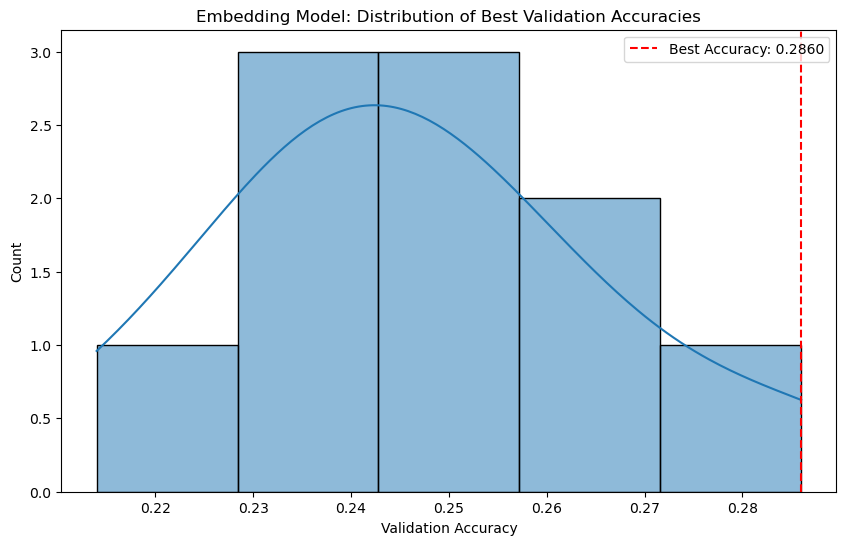

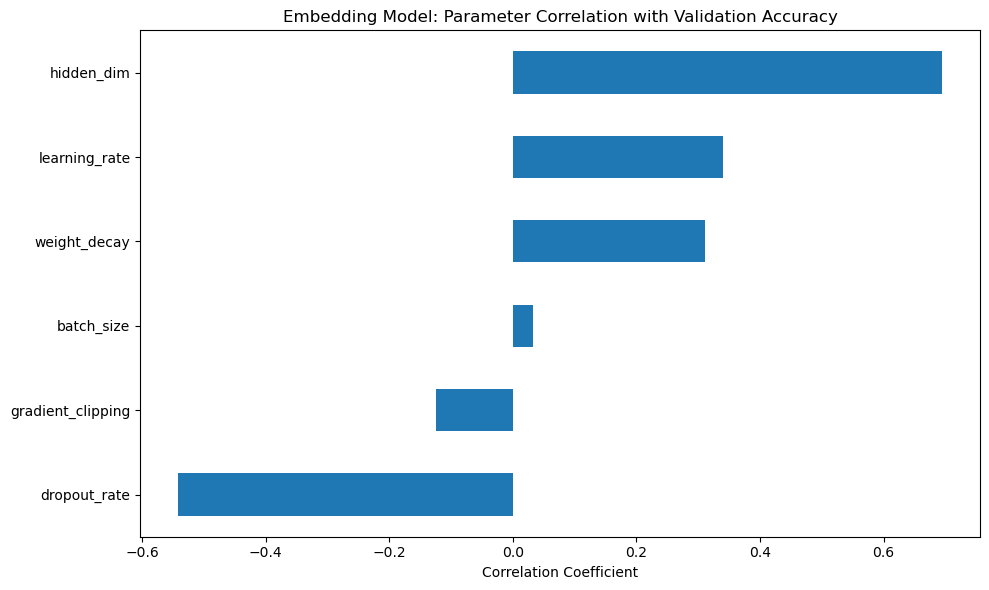

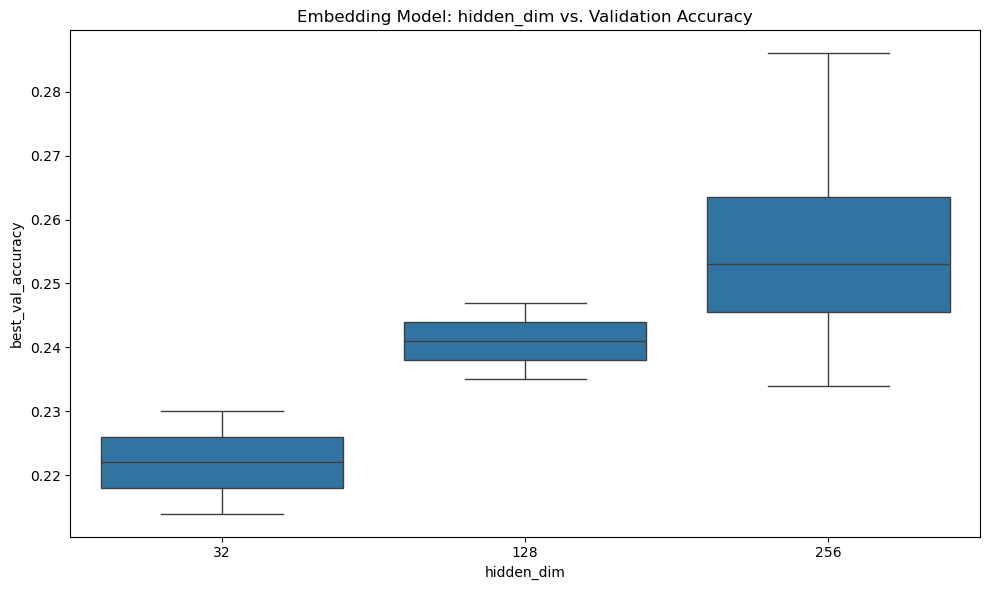

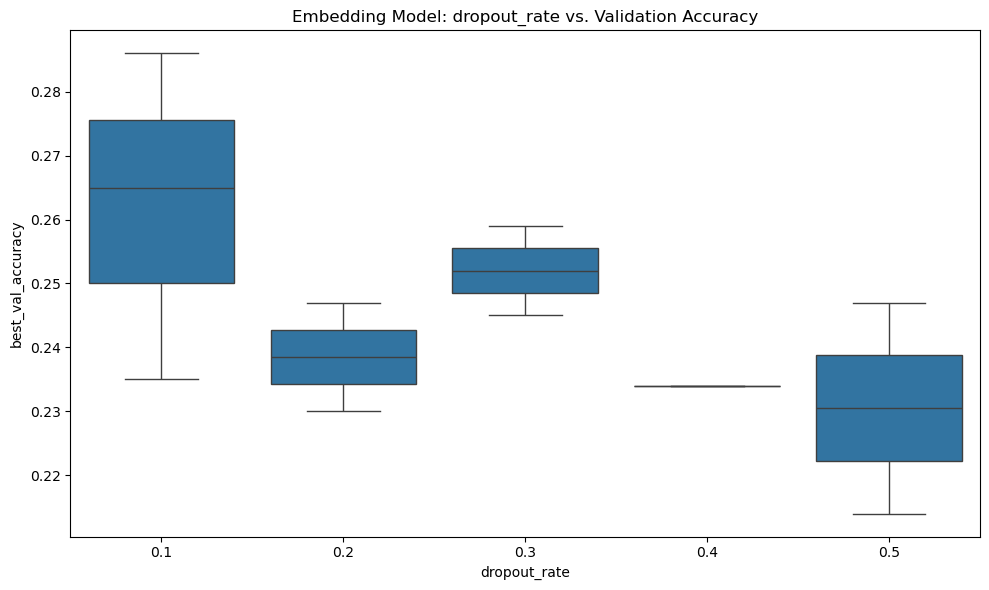

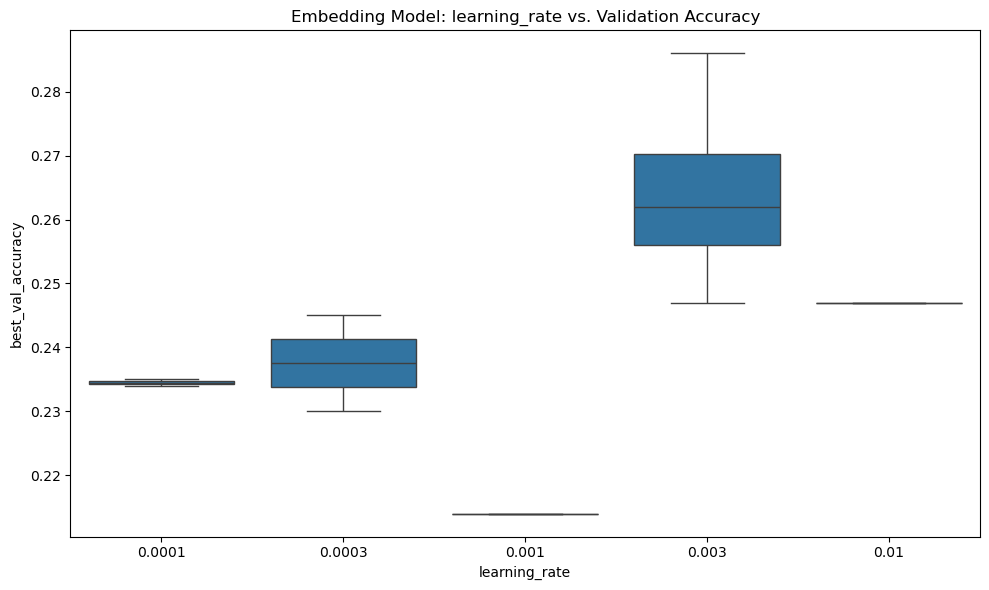

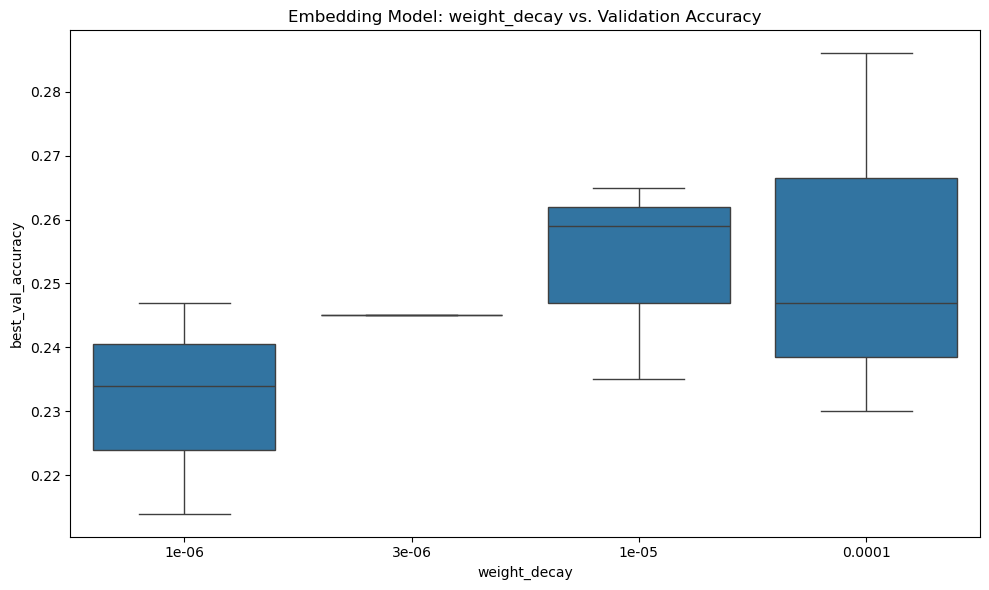

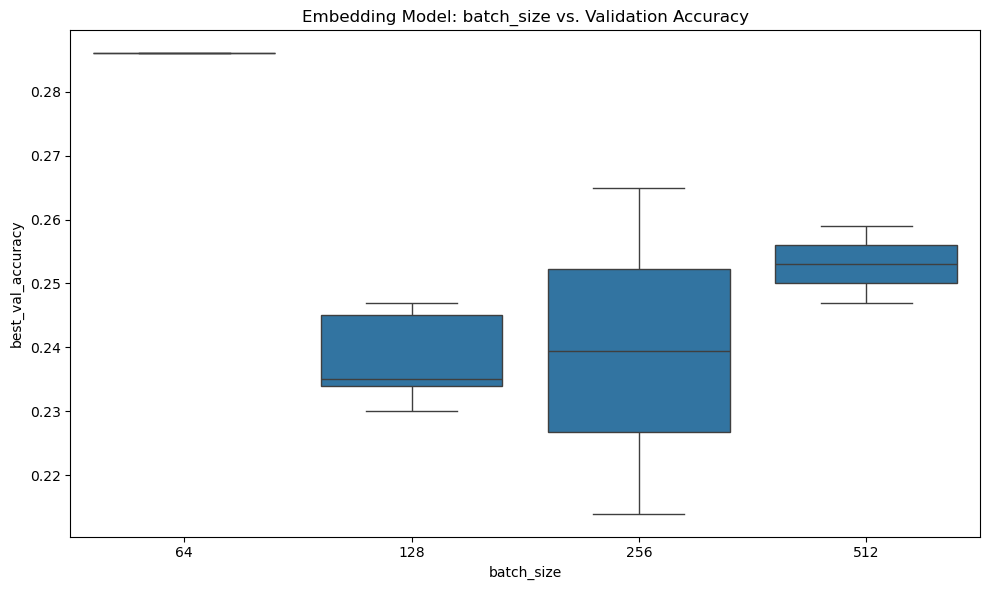

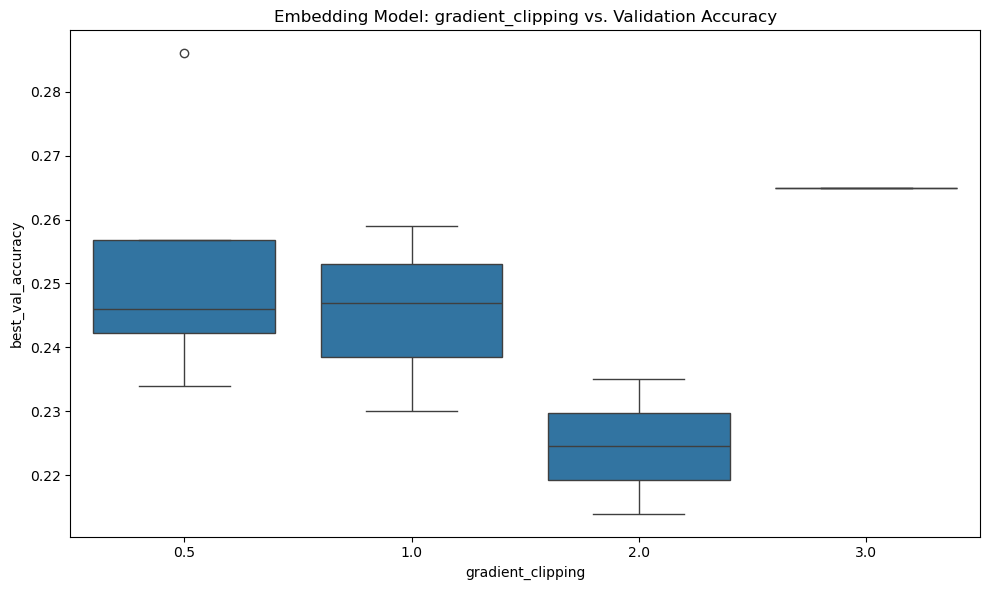

Analysis complete. Results saved to ./hyperopt_results/analysis_embedding

=== RNN Model Analysis ===
Analyzing 10 trials for rnn model
Best validation accuracy: 0.2430
Best run: trial_3_20250407_164423
Best hyperparameters:
  hidden_dim: 64
  dropout_rate: 0.3
  learning_rate: 0.01
  weight_decay: 1e-07
  batch_size: 32
  gradient_clipping: 3.0
  pct_start: 0.3


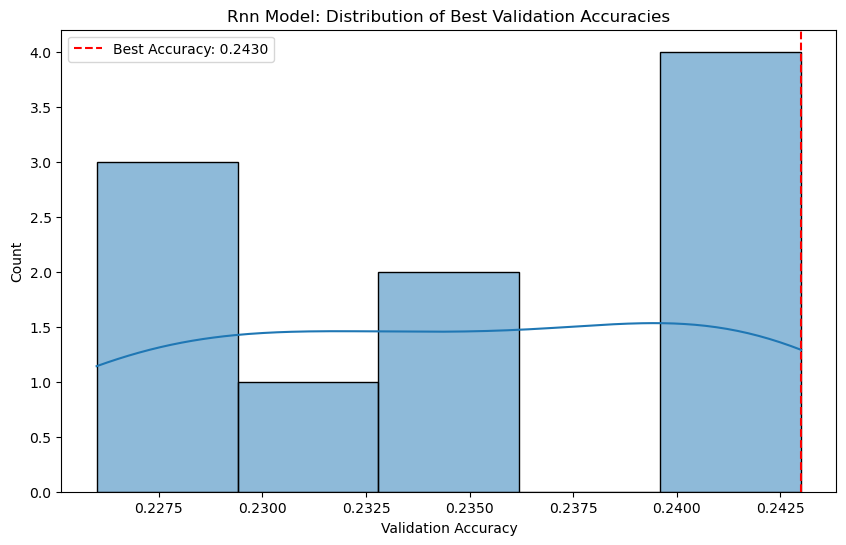

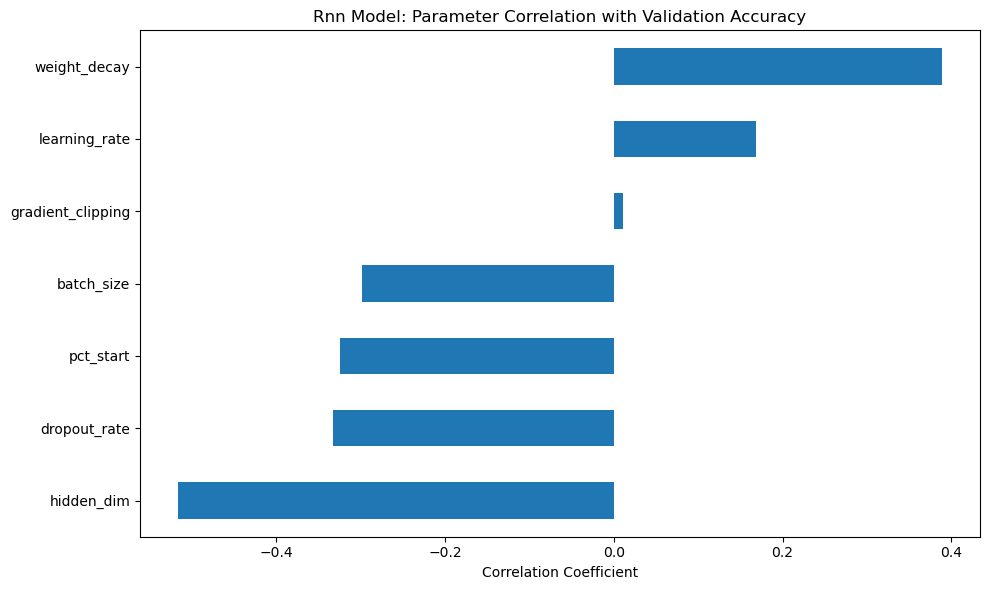

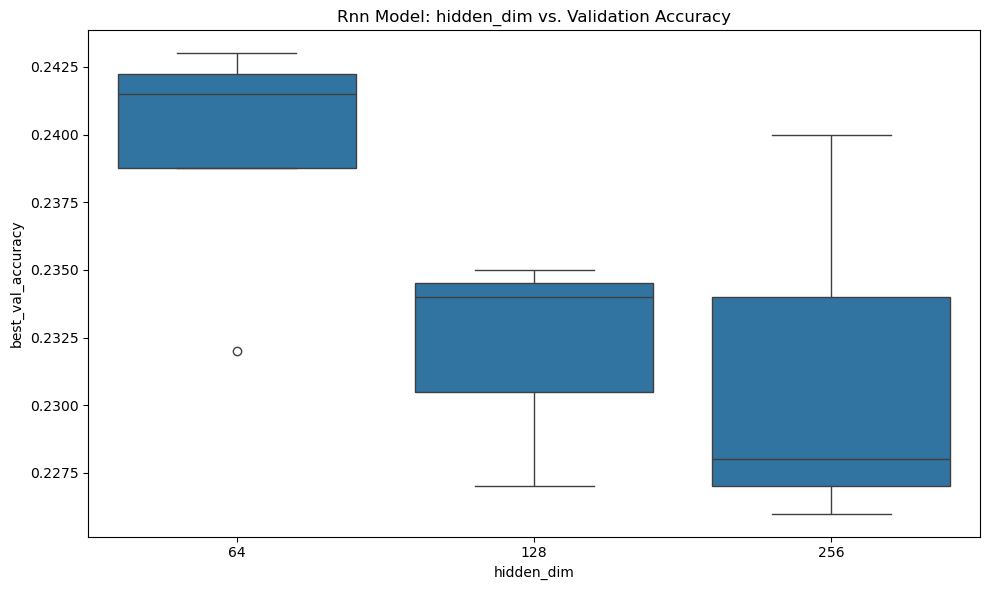

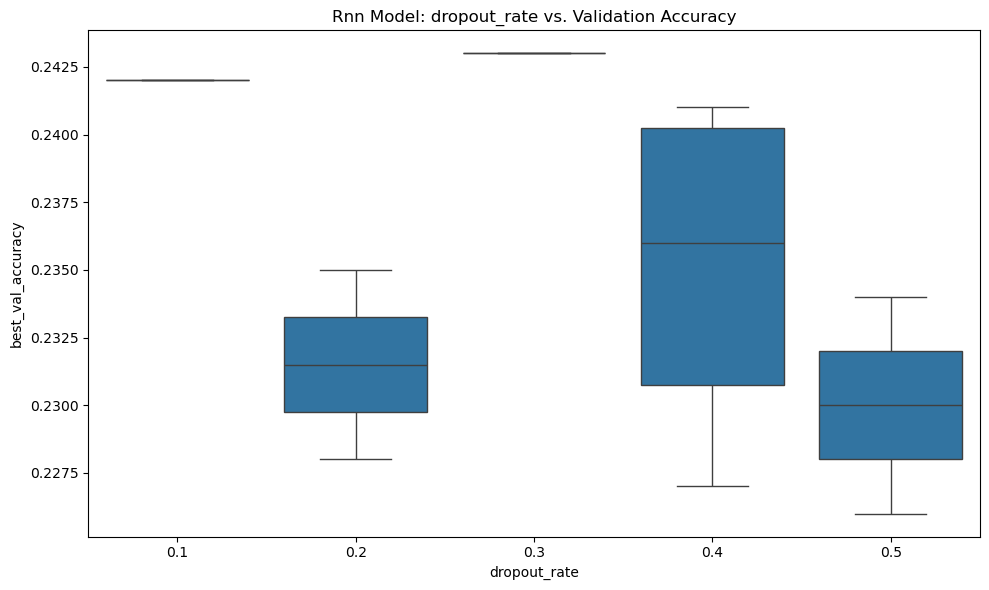

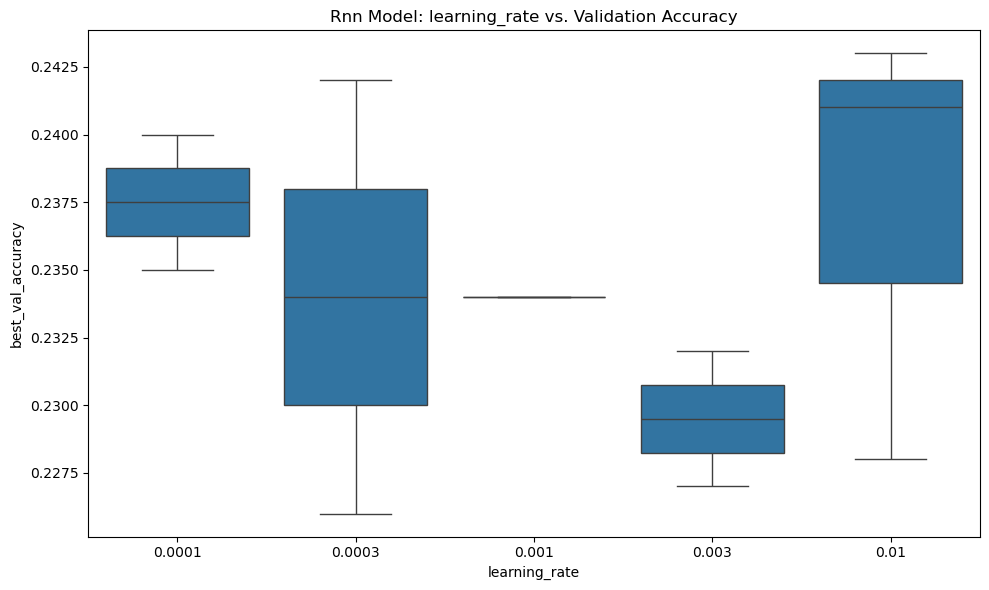

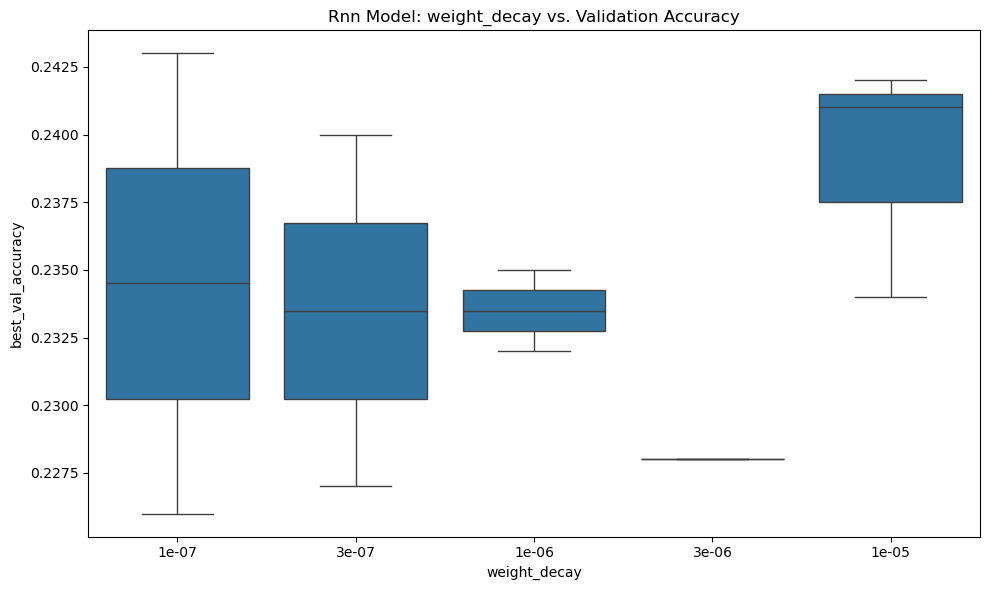

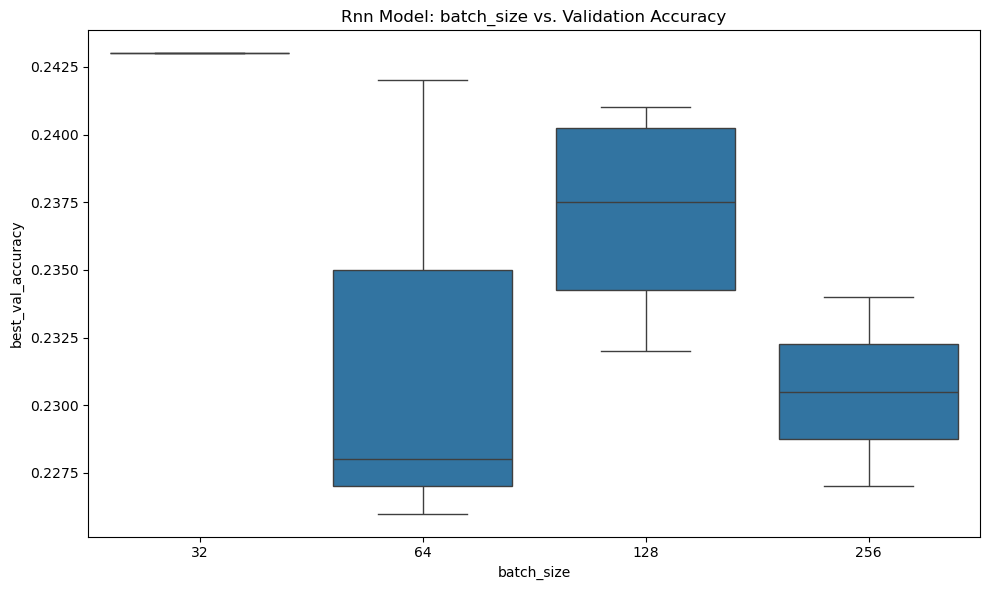

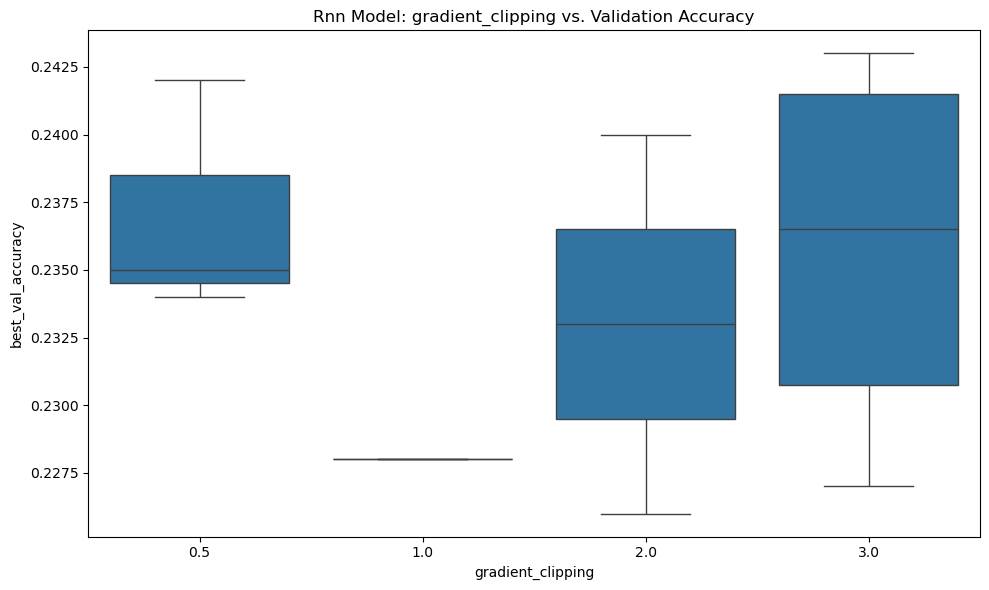

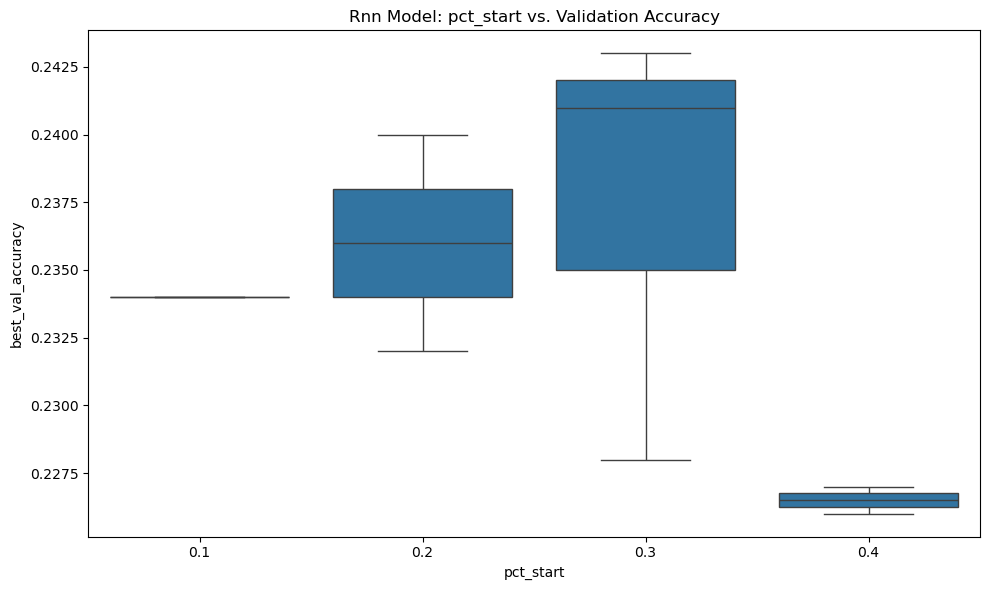

Analysis complete. Results saved to ./hyperopt_results/analysis_rnn

=== Training Best Embedding Model ===
Using device: cuda
Calculating IDF scores...


Counting terms: 100%|██████████| 52446/52446 [00:01<00:00, 27463.34it/s]


Calculated IDF scores for 12015 terms
Calculating IDF scores...


Counting terms: 100%|██████████| 6000/6000 [00:00<00:00, 27219.51it/s]


Calculated IDF scores for 4346 terms
Training optimized embedding model with parameters:
  hidden_dim: 256
  dropout_rate: 0.1
  learning_rate: 0.003
  weight_decay: 0.0001
  batch_size: 64
  gradient_clipping: 0.5

Epoch 1/50


Validation: 100%|██████████| 8/8 [00:00<00:00, 13.77it/s]


Validation accuracy improved from 0.0000 to 0.2420
Train Loss: 1.6685, Train Acc: 0.2162
Val Loss: 1.6002, Val Acc: 0.2420

Epoch 2/50


Validation: 100%|██████████| 8/8 [00:00<00:00, 13.60it/s]


Validation accuracy improved from 0.2420 to 0.2460
Train Loss: 1.5563, Train Acc: 0.2869
Val Loss: 1.5783, Val Acc: 0.2460

Epoch 3/50


Validation: 100%|██████████| 8/8 [00:00<00:00, 13.55it/s]


Validation accuracy improved from 0.2460 to 0.2680
Train Loss: 1.4520, Train Acc: 0.3838
Val Loss: 1.5966, Val Acc: 0.2680

Epoch 4/50


Validation: 100%|██████████| 8/8 [00:00<00:00, 14.00it/s]


Train Loss: 1.4369, Train Acc: 0.3740
Val Loss: 1.5819, Val Acc: 0.2600

Epoch 5/50


Validation: 100%|██████████| 8/8 [00:00<00:00, 13.94it/s]


Train Loss: 1.2611, Train Acc: 0.4914
Val Loss: 1.6229, Val Acc: 0.2610

Epoch 6/50


Validation: 100%|██████████| 8/8 [00:00<00:00, 14.89it/s]


Train Loss: 1.2078, Train Acc: 0.5205
Val Loss: 1.6781, Val Acc: 0.2550

Epoch 7/50


Validation: 100%|██████████| 8/8 [00:00<00:00, 13.96it/s]


Validation accuracy improved from 0.2680 to 0.2750
Train Loss: 1.3011, Train Acc: 0.4654
Val Loss: 1.6408, Val Acc: 0.2750

Epoch 8/50


Validation: 100%|██████████| 8/8 [00:00<00:00, 14.19it/s]


Train Loss: 1.1625, Train Acc: 0.5321
Val Loss: 1.7398, Val Acc: 0.2670

Epoch 9/50


Validation: 100%|██████████| 8/8 [00:00<00:00, 13.73it/s]


Train Loss: 0.9726, Train Acc: 0.6264
Val Loss: 1.8325, Val Acc: 0.2710

Epoch 10/50


Validation: 100%|██████████| 8/8 [00:00<00:00, 13.99it/s]


Validation accuracy improved from 0.2750 to 0.2810
Train Loss: 0.7820, Train Acc: 0.7155
Val Loss: 1.9180, Val Acc: 0.2810

Epoch 11/50


Validation: 100%|██████████| 8/8 [00:00<00:00, 13.68it/s]


Train Loss: 0.6530, Train Acc: 0.7819
Val Loss: 1.9592, Val Acc: 0.2790

Epoch 12/50


Validation: 100%|██████████| 8/8 [00:00<00:00, 14.26it/s]


Train Loss: 0.8493, Train Acc: 0.6790
Val Loss: 1.9066, Val Acc: 0.2650

Epoch 13/50


Validation: 100%|██████████| 8/8 [00:00<00:00, 14.12it/s]


Train Loss: 0.9982, Train Acc: 0.6053
Val Loss: 1.9672, Val Acc: 0.2680

Epoch 14/50


Validation: 100%|██████████| 8/8 [00:00<00:00, 13.72it/s]


Train Loss: 0.9145, Train Acc: 0.6483
Val Loss: 2.0155, Val Acc: 0.2590

Epoch 15/50


Validation: 100%|██████████| 8/8 [00:00<00:00, 13.50it/s]


Train Loss: 0.8119, Train Acc: 0.6919
Val Loss: 2.0819, Val Acc: 0.2490

Epoch 16/50


Validation: 100%|██████████| 8/8 [00:00<00:00, 13.72it/s]


Train Loss: 0.6928, Train Acc: 0.7406
Val Loss: 2.2318, Val Acc: 0.2640

Epoch 17/50


Validation: 100%|██████████| 8/8 [00:00<00:00, 14.01it/s]


Train Loss: 0.5722, Train Acc: 0.7982
Val Loss: 2.4013, Val Acc: 0.2550

Epoch 18/50


Validation: 100%|██████████| 8/8 [00:00<00:00, 15.05it/s]


Train Loss: 0.4725, Train Acc: 0.8338
Val Loss: 2.4791, Val Acc: 0.2590

Epoch 19/50


Validation: 100%|██████████| 8/8 [00:00<00:00, 13.72it/s]


Train Loss: 0.3761, Train Acc: 0.8732
Val Loss: 2.5724, Val Acc: 0.2550

Epoch 20/50


Validation: 100%|██████████| 8/8 [00:00<00:00, 13.97it/s]


Train Loss: 0.3052, Train Acc: 0.9026
Val Loss: 2.6692, Val Acc: 0.2570

Epoch 21/50


Validation: 100%|██████████| 8/8 [00:00<00:00, 13.98it/s]


Train Loss: 0.2465, Train Acc: 0.9266
Val Loss: 2.7288, Val Acc: 0.2520

Epoch 22/50


Validation: 100%|██████████| 8/8 [00:00<00:00, 13.93it/s]


Train Loss: 0.2174, Train Acc: 0.9378
Val Loss: 2.7587, Val Acc: 0.2420

Epoch 23/50


Validation: 100%|██████████| 8/8 [00:00<00:00, 13.61it/s]


Train Loss: 0.1960, Train Acc: 0.9466
Val Loss: 2.7530, Val Acc: 0.2380

Epoch 24/50


Validation: 100%|██████████| 8/8 [00:00<00:00, 14.45it/s]


Train Loss: 0.5846, Train Acc: 0.7792
Val Loss: 2.5759, Val Acc: 0.2680

Epoch 25/50


Validation: 100%|██████████| 8/8 [00:00<00:00, 13.78it/s]


Train Loss: 0.6677, Train Acc: 0.7428
Val Loss: 2.4375, Val Acc: 0.2800

Epoch 26/50


Validation: 100%|██████████| 8/8 [00:00<00:00, 13.90it/s]


Train Loss: 0.6316, Train Acc: 0.7615
Val Loss: 2.5161, Val Acc: 0.2420

Epoch 27/50


Validation: 100%|██████████| 8/8 [00:00<00:00, 13.62it/s]


Train Loss: 0.5870, Train Acc: 0.7865
Val Loss: 2.5011, Val Acc: 0.2570

Epoch 28/50


Validation: 100%|██████████| 8/8 [00:00<00:00, 13.96it/s]


Train Loss: 0.5621, Train Acc: 0.7956
Val Loss: 2.5711, Val Acc: 0.2570

Epoch 29/50


Validation: 100%|██████████| 8/8 [00:00<00:00, 13.30it/s]


Train Loss: 0.5083, Train Acc: 0.8143
Val Loss: 2.5813, Val Acc: 0.2510

Epoch 30/50


Validation: 100%|██████████| 8/8 [00:00<00:00, 13.79it/s]


Train Loss: 0.4535, Train Acc: 0.8358
Val Loss: 2.7310, Val Acc: 0.2530

Epoch 31/50


Validation: 100%|██████████| 8/8 [00:00<00:00, 13.85it/s]


Train Loss: 0.4190, Train Acc: 0.8507
Val Loss: 2.7513, Val Acc: 0.2500

Epoch 32/50


Validation: 100%|██████████| 8/8 [00:00<00:00, 13.71it/s]


Train Loss: 0.3705, Train Acc: 0.8671
Val Loss: 2.9087, Val Acc: 0.2580

Epoch 33/50


Validation: 100%|██████████| 8/8 [00:00<00:00, 13.59it/s]


Train Loss: 0.3439, Train Acc: 0.8778
Val Loss: 3.0811, Val Acc: 0.2380

Epoch 34/50


Validation: 100%|██████████| 8/8 [00:00<00:00, 13.90it/s]


Train Loss: 0.3012, Train Acc: 0.8937
Val Loss: 3.1188, Val Acc: 0.2330

Epoch 35/50


Validation: 100%|██████████| 8/8 [00:00<00:00, 13.74it/s]


Train Loss: 0.2681, Train Acc: 0.9058
Val Loss: 3.1855, Val Acc: 0.2460

Epoch 36/50


Validation: 100%|██████████| 8/8 [00:00<00:00, 13.74it/s]


Train Loss: 0.2357, Train Acc: 0.9215
Val Loss: 3.3086, Val Acc: 0.2570

Epoch 37/50


Validation: 100%|██████████| 8/8 [00:00<00:00, 14.34it/s]


Train Loss: 0.1895, Train Acc: 0.9365
Val Loss: 3.3630, Val Acc: 0.2440

Epoch 38/50


Validation: 100%|██████████| 8/8 [00:00<00:00, 13.92it/s]


Train Loss: 0.1642, Train Acc: 0.9451
Val Loss: 3.4689, Val Acc: 0.2460

Epoch 39/50


Validation: 100%|██████████| 8/8 [00:00<00:00, 14.38it/s]


Train Loss: 0.1391, Train Acc: 0.9568
Val Loss: 3.5017, Val Acc: 0.2480

Epoch 40/50


Validation: 100%|██████████| 8/8 [00:00<00:00, 14.30it/s]


Train Loss: 0.1229, Train Acc: 0.9605
Val Loss: 3.6118, Val Acc: 0.2290

Epoch 41/50


Validation: 100%|██████████| 8/8 [00:00<00:00, 14.02it/s]


Train Loss: 0.0985, Train Acc: 0.9708
Val Loss: 3.6350, Val Acc: 0.2290

Epoch 42/50


Validation: 100%|██████████| 8/8 [00:00<00:00, 13.80it/s]


Train Loss: 0.0921, Train Acc: 0.9716
Val Loss: 3.6860, Val Acc: 0.2250

Epoch 43/50


Validation: 100%|██████████| 8/8 [00:00<00:00, 13.83it/s]


Train Loss: 0.0844, Train Acc: 0.9741
Val Loss: 3.7099, Val Acc: 0.2420

Epoch 44/50


Validation: 100%|██████████| 8/8 [00:00<00:00, 13.76it/s]


Train Loss: 0.0717, Train Acc: 0.9798
Val Loss: 3.6965, Val Acc: 0.2410

Epoch 45/50


Validation: 100%|██████████| 8/8 [00:00<00:00, 13.56it/s]


Train Loss: 0.0670, Train Acc: 0.9812
Val Loss: 3.7310, Val Acc: 0.2340

Epoch 46/50


Validation: 100%|██████████| 8/8 [00:00<00:00, 13.72it/s]


Train Loss: 0.0649, Train Acc: 0.9823
Val Loss: 3.7372, Val Acc: 0.2310

Epoch 47/50


Validation: 100%|██████████| 8/8 [00:00<00:00, 13.81it/s]


Train Loss: 0.2214, Train Acc: 0.9227
Val Loss: 3.6598, Val Acc: 0.2400

Epoch 48/50


Validation: 100%|██████████| 8/8 [00:00<00:00, 13.69it/s]


Train Loss: 0.5238, Train Acc: 0.8110
Val Loss: 3.0024, Val Acc: 0.2430

Epoch 49/50


Validation: 100%|██████████| 8/8 [00:00<00:00, 13.96it/s]


Train Loss: 0.5076, Train Acc: 0.8109
Val Loss: 2.9166, Val Acc: 0.2450

Epoch 50/50


Validation: 100%|██████████| 8/8 [00:00<00:00, 13.82it/s]


Train Loss: 0.4805, Train Acc: 0.8200
Val Loss: 2.8593, Val Acc: 0.2470


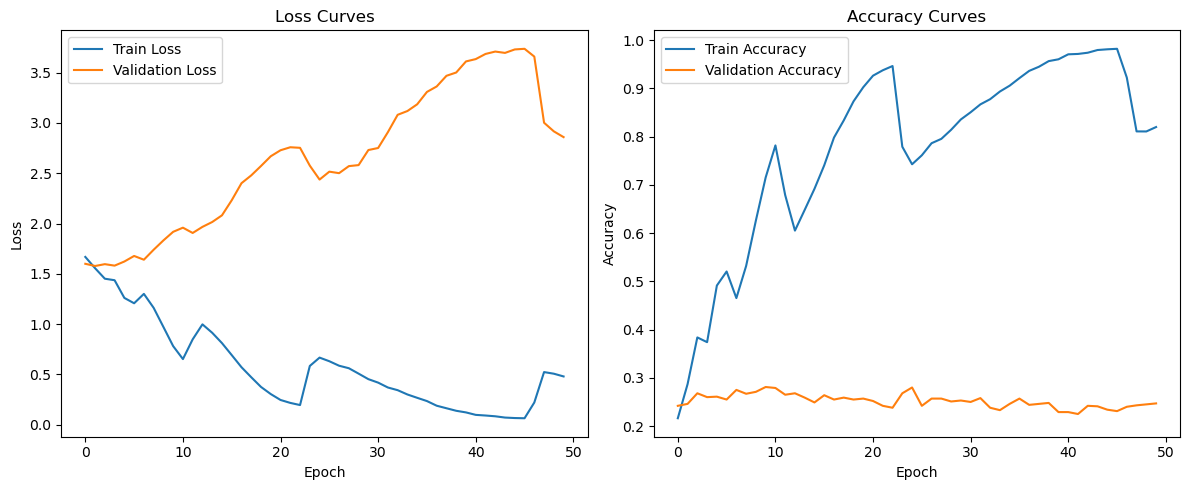

Final model saved. Best validation accuracy: 0.2810
Best embedding model achieved 0.2810 validation accuracy

=== Training Best RNN Model ===
Using device: cuda
Training optimized RNN model with parameters:
  hidden_dim: 64
  dropout_rate: 0.3
  learning_rate: 0.01
  weight_decay: 1e-07
  batch_size: 32
  gradient_clipping: 3.0
  pct_start: 0.3

Epoch 1/50


Validation: 100%|██████████| 16/16 [00:00<00:00, 16.76it/s]


Validation accuracy improved from 0.0000 to 0.2220
Train Loss: 1.6089, Train Acc: 0.2094
Val Loss: 1.6087, Val Acc: 0.2220

Epoch 2/50


Validation: 100%|██████████| 16/16 [00:00<00:00, 18.12it/s]


Train Loss: 1.6073, Train Acc: 0.2112
Val Loss: 1.6030, Val Acc: 0.2180

Epoch 3/50


Validation: 100%|██████████| 16/16 [00:00<00:00, 16.73it/s]


Train Loss: 1.5988, Train Acc: 0.2166
Val Loss: 1.5977, Val Acc: 0.2050

Epoch 4/50


Validation: 100%|██████████| 16/16 [00:00<00:00, 16.80it/s]


Train Loss: 1.5925, Train Acc: 0.2257
Val Loss: 1.5908, Val Acc: 0.1970

Epoch 5/50


Validation: 100%|██████████| 16/16 [00:00<00:00, 17.25it/s]


Train Loss: 1.5909, Train Acc: 0.2255
Val Loss: 1.5950, Val Acc: 0.2020

Epoch 6/50


Validation: 100%|██████████| 16/16 [00:00<00:00, 16.72it/s]


Train Loss: 1.5857, Train Acc: 0.2320
Val Loss: 1.5939, Val Acc: 0.2050

Epoch 7/50


Validation: 100%|██████████| 16/16 [00:00<00:00, 16.38it/s]


Train Loss: 1.5832, Train Acc: 0.2248
Val Loss: 1.5958, Val Acc: 0.1950

Epoch 8/50


Validation: 100%|██████████| 16/16 [00:00<00:00, 17.93it/s]


Train Loss: 1.5792, Train Acc: 0.2332
Val Loss: 1.5920, Val Acc: 0.2090

Epoch 9/50


Validation: 100%|██████████| 16/16 [00:00<00:00, 17.00it/s]


Train Loss: 1.5771, Train Acc: 0.2380
Val Loss: 1.5976, Val Acc: 0.2150

Epoch 10/50


Validation: 100%|██████████| 16/16 [00:01<00:00,  9.63it/s]


Train Loss: 1.5770, Train Acc: 0.2404
Val Loss: 1.5928, Val Acc: 0.2090

Epoch 11/50


Validation: 100%|██████████| 16/16 [00:00<00:00, 16.42it/s]


Train Loss: 1.5755, Train Acc: 0.2397
Val Loss: 1.5932, Val Acc: 0.2020

Epoch 12/50


Validation: 100%|██████████| 16/16 [00:00<00:00, 17.09it/s]


Train Loss: 1.5717, Train Acc: 0.2452
Val Loss: 1.6040, Val Acc: 0.1980

Epoch 13/50


Validation: 100%|██████████| 16/16 [00:00<00:00, 17.01it/s]


Train Loss: 1.5632, Train Acc: 0.2558
Val Loss: 1.6053, Val Acc: 0.1920

Epoch 14/50


Validation: 100%|██████████| 16/16 [00:00<00:00, 17.21it/s]


Train Loss: 1.5589, Train Acc: 0.2563
Val Loss: 1.6171, Val Acc: 0.1950

Epoch 15/50


Validation: 100%|██████████| 16/16 [00:00<00:00, 17.55it/s]


Train Loss: 1.5540, Train Acc: 0.2579
Val Loss: 1.6307, Val Acc: 0.1780

Epoch 16/50


Validation: 100%|██████████| 16/16 [00:00<00:00, 17.90it/s]


Train Loss: 1.5515, Train Acc: 0.2561
Val Loss: 1.6952, Val Acc: 0.1980

Epoch 17/50


Validation: 100%|██████████| 16/16 [00:00<00:00, 16.94it/s]


Train Loss: 1.5456, Train Acc: 0.2639
Val Loss: 1.6547, Val Acc: 0.1870

Epoch 18/50


Validation: 100%|██████████| 16/16 [00:00<00:00, 16.74it/s]


Train Loss: 1.5373, Train Acc: 0.2719
Val Loss: 1.6601, Val Acc: 0.1920

Epoch 19/50


Validation: 100%|██████████| 16/16 [00:00<00:00, 17.55it/s]


Train Loss: 1.5323, Train Acc: 0.2693
Val Loss: 1.6661, Val Acc: 0.1930

Epoch 20/50


Validation: 100%|██████████| 16/16 [00:00<00:00, 17.42it/s]


Train Loss: 1.5171, Train Acc: 0.2795
Val Loss: 1.6626, Val Acc: 0.1730

Epoch 21/50


Validation: 100%|██████████| 16/16 [00:00<00:00, 17.62it/s]


Train Loss: 1.5099, Train Acc: 0.2981
Val Loss: 1.7377, Val Acc: 0.1930

Epoch 22/50


Validation: 100%|██████████| 16/16 [00:00<00:00, 17.81it/s]


Train Loss: 1.4972, Train Acc: 0.3055
Val Loss: 1.7129, Val Acc: 0.1990

Epoch 23/50


Validation: 100%|██████████| 16/16 [00:00<00:00, 17.48it/s]


Train Loss: 1.4873, Train Acc: 0.3137
Val Loss: 1.7538, Val Acc: 0.1850

Epoch 24/50


Validation: 100%|██████████| 16/16 [00:00<00:00, 17.39it/s]


Train Loss: 1.4637, Train Acc: 0.3191
Val Loss: 1.6988, Val Acc: 0.1850

Epoch 25/50


Validation: 100%|██████████| 16/16 [00:00<00:00, 17.85it/s]


Train Loss: 1.4467, Train Acc: 0.3322
Val Loss: 1.7962, Val Acc: 0.1970

Epoch 26/50


Validation: 100%|██████████| 16/16 [00:00<00:00, 16.51it/s]


Train Loss: 1.4224, Train Acc: 0.3549
Val Loss: 1.8414, Val Acc: 0.1770

Epoch 27/50


Validation: 100%|██████████| 16/16 [00:00<00:00, 17.03it/s]


Train Loss: 1.3979, Train Acc: 0.3622
Val Loss: 1.7886, Val Acc: 0.1770

Epoch 28/50


Validation: 100%|██████████| 16/16 [00:00<00:00, 17.82it/s]


Train Loss: 1.3768, Train Acc: 0.3811
Val Loss: 1.8721, Val Acc: 0.1960

Epoch 29/50


Validation: 100%|██████████| 16/16 [00:00<00:00, 17.15it/s]


Train Loss: 1.3427, Train Acc: 0.4019
Val Loss: 1.8315, Val Acc: 0.1800

Epoch 30/50


Validation: 100%|██████████| 16/16 [00:00<00:00, 16.48it/s]


Train Loss: 1.3101, Train Acc: 0.4157
Val Loss: 2.0634, Val Acc: 0.1750

Epoch 31/50


Validation: 100%|██████████| 16/16 [00:00<00:00, 18.17it/s]


Train Loss: 1.2747, Train Acc: 0.4306
Val Loss: 2.1191, Val Acc: 0.1780

Epoch 32/50


Validation: 100%|██████████| 16/16 [00:00<00:00, 16.94it/s]


Train Loss: 1.2400, Train Acc: 0.4550
Val Loss: 2.2359, Val Acc: 0.1690

Epoch 33/50


Validation: 100%|██████████| 16/16 [00:00<00:00, 16.61it/s]


Train Loss: 1.2096, Train Acc: 0.4707
Val Loss: 2.3184, Val Acc: 0.1920

Epoch 34/50


Validation: 100%|██████████| 16/16 [00:00<00:00, 17.71it/s]


Train Loss: 1.1816, Train Acc: 0.4880
Val Loss: 2.4179, Val Acc: 0.1680

Epoch 35/50


Validation: 100%|██████████| 16/16 [00:00<00:00, 16.93it/s]


Train Loss: 1.1541, Train Acc: 0.4943
Val Loss: 2.4641, Val Acc: 0.1730

Epoch 36/50


Validation: 100%|██████████| 16/16 [00:00<00:00, 16.50it/s]


Train Loss: 1.1043, Train Acc: 0.5249
Val Loss: 2.5957, Val Acc: 0.1750

Epoch 37/50


Validation: 100%|██████████| 16/16 [00:00<00:00, 18.10it/s]


Train Loss: 1.0740, Train Acc: 0.5379
Val Loss: 2.6993, Val Acc: 0.1750

Epoch 38/50


Validation: 100%|██████████| 16/16 [00:00<00:00, 16.90it/s]


Train Loss: 1.0376, Train Acc: 0.5534
Val Loss: 2.8052, Val Acc: 0.1720

Epoch 39/50


Validation: 100%|██████████| 16/16 [00:01<00:00, 15.94it/s]


Train Loss: 0.9987, Train Acc: 0.5712
Val Loss: 3.0895, Val Acc: 0.1750

Epoch 40/50


Validation: 100%|██████████| 16/16 [00:00<00:00, 17.71it/s]


Train Loss: 0.9705, Train Acc: 0.5857
Val Loss: 3.0844, Val Acc: 0.1710

Epoch 41/50


Validation: 100%|██████████| 16/16 [00:01<00:00, 15.50it/s]


Train Loss: 0.9485, Train Acc: 0.5991
Val Loss: 3.1315, Val Acc: 0.1640

Epoch 42/50


Validation: 100%|██████████| 16/16 [00:00<00:00, 16.80it/s]


Train Loss: 0.9282, Train Acc: 0.6031
Val Loss: 3.3083, Val Acc: 0.1610

Epoch 43/50


Validation: 100%|██████████| 16/16 [00:00<00:00, 17.67it/s]


Train Loss: 0.9128, Train Acc: 0.6162
Val Loss: 3.3240, Val Acc: 0.1740

Epoch 44/50


Validation: 100%|██████████| 16/16 [00:00<00:00, 17.02it/s]


Train Loss: 0.8956, Train Acc: 0.6249
Val Loss: 3.4192, Val Acc: 0.1730

Epoch 45/50


Validation: 100%|██████████| 16/16 [00:00<00:00, 16.63it/s]


Train Loss: 0.8772, Train Acc: 0.6332
Val Loss: 3.4796, Val Acc: 0.1660

Epoch 46/50


Validation: 100%|██████████| 16/16 [00:00<00:00, 17.25it/s]


Train Loss: 0.8739, Train Acc: 0.6305
Val Loss: 3.5170, Val Acc: 0.1780

Epoch 47/50


Validation: 100%|██████████| 16/16 [00:00<00:00, 16.64it/s]


Train Loss: 0.8606, Train Acc: 0.6413
Val Loss: 3.6333, Val Acc: 0.1670

Epoch 48/50


Validation: 100%|██████████| 16/16 [00:00<00:00, 17.00it/s]


Train Loss: 0.8469, Train Acc: 0.6432
Val Loss: 3.6232, Val Acc: 0.1700

Epoch 49/50


Validation: 100%|██████████| 16/16 [00:00<00:00, 17.26it/s]


Train Loss: 0.8507, Train Acc: 0.6488
Val Loss: 3.6651, Val Acc: 0.1700

Epoch 50/50


Validation: 100%|██████████| 16/16 [00:00<00:00, 16.55it/s]


Train Loss: 0.8465, Train Acc: 0.6389
Val Loss: 3.6414, Val Acc: 0.1730


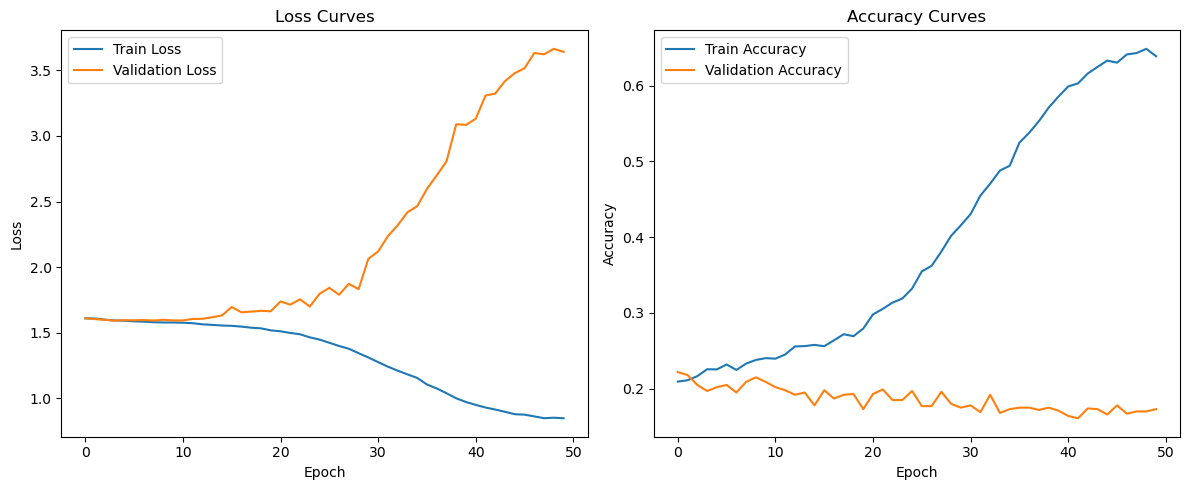

Final model saved. Best validation accuracy: 0.2220
Best RNN model achieved 0.2220 validation accuracy

=== Hyperparameter Optimization Complete ===


In [42]:
# Cell 11 (Updated): Run Complete Optimization with Simplified Approach
def run_complete_optimization(embedding_trials=10, rnn_trials=10):
    print("=== Starting Complete Hyperparameter Optimization ===")
    
    # Run embedding model optimization
    print("\n=== Embedding Model Optimization ===")
    embedding_results_df = run_embedding_hyperopt(num_trials=embedding_trials)
    
    # Run RNN model optimization
    print("\n=== RNN Model Optimization ===")
    rnn_results_df = run_rnn_hyperopt(num_trials=rnn_trials)
    
    # Analyze results
    print("\n=== Analyzing Optimization Results ===")
    embedding_results_file = "./hyperopt_results/embedding_results.csv"
    rnn_results_file = "./hyperopt_results/rnn_results.csv"
    
    print("\n=== Embedding Model Analysis ===")
    embedding_best_params = analyze_hyperopt_results(embedding_results_file, model_type="embedding")
    
    print("\n=== RNN Model Analysis ===")
    rnn_best_params = analyze_hyperopt_results(rnn_results_file, model_type="rnn")
    
    # Train best models if we have parameters
    if embedding_best_params is not None:
        print("\n=== Training Best Embedding Model ===")
        best_embedding_params = {col: embedding_best_params[col] for col in embedding_best_params.index 
                               if col not in ['run_id', 'timestamp', 'best_val_accuracy', 'error', 'final_train_accuracy', 'final_val_accuracy']}
        best_embedding_model, best_embedding_accuracy = train_best_embedding_model_final(best_embedding_params)
        print(f"Best embedding model achieved {best_embedding_accuracy:.4f} validation accuracy")
    
    if rnn_best_params is not None:
        print("\n=== Training Best RNN Model ===")
        best_rnn_params = {col: rnn_best_params[col] for col in rnn_best_params.index 
                         if col not in ['run_id', 'timestamp', 'best_val_accuracy', 'error', 'final_train_accuracy', 'final_val_accuracy']}
        best_rnn_model, best_rnn_accuracy = train_best_rnn_model_final(best_rnn_params)
        print(f"Best RNN model achieved {best_rnn_accuracy:.4f} validation accuracy")
    
    print("\n=== Hyperparameter Optimization Complete ===")
    return {
        'embedding_results': embedding_results_df,
        'rnn_results': rnn_results_df,
        'embedding_best_params': embedding_best_params,
        'rnn_best_params': rnn_best_params
    }

# Uncomment to run the complete optimization process
optimization_results = run_complete_optimization(embedding_trials=10, rnn_trials=10)